# 12 months prediction using Selected Features
#### Name: Xiaoyu Wu 
#### Student ID : 1218098

---

#### This file contains:

* Prediction for 2019 using data from 2008-2018

In [5]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
from time import strptime

import matplotlib.pyplot as plt
import missingno

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from BorutaShap import BorutaShap
import missingno as msno

#!pip install shap
import shap
shap.initjs()


#plt.style.use('fivethirtyeight')

## Load data

In [6]:
# load data

combined_data1 = pd.read_csv("./data/old_08-19_combined.csv")
combined_data = pd.read_csv("./data/old_08-19_combined.csv", index_col = [0])
only_y = pd.read_csv("./data/08-19_only_y.csv")
no_out = pd.read_csv("./data/no_out.csv")

combined_data.index = pd.to_datetime(combined_data.index)
combined_data1["month"] = pd.to_datetime(combined_data1["month"])

print(combined_data.shape)
print(combined_data1.shape)

#print(combined_data1.head())
#combined_data.iloc[:,1]
#combined_data.head()
#no_out.head()

(144, 79)
(144, 80)


<AxesSubplot:>

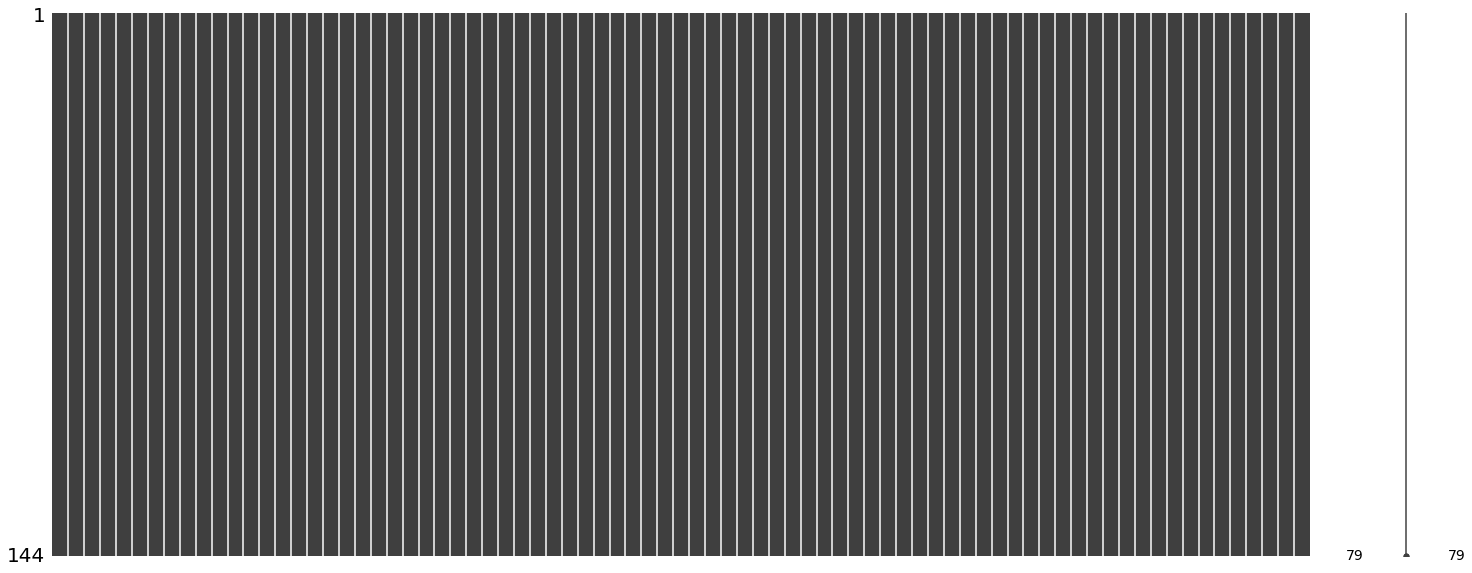

In [7]:
msno.matrix(combined_data)

In [8]:
#Check number of rows and columns, type of each columns
combined_data.info()
#combined_data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2008-01-01 to 2019-12-01
Data columns (total 79 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   aus_population_natural_increase                                                           144 non-null    float64
 1   aus_population_overseas_arrivals                                                          144 non-null    float64
 2   aus_population_net overseas migration                                                     144 non-null    float64
 3   aus_population_estimated resident population                                              144 non-null    float64
 4   aus_beef&veal_slaughterings                                                               144 non-null    float64
 5   aus_beef&veal_average weight          

In [9]:
# Understanding the numeric fields
combined_data.describe()

aus_population_natural_increase  aus_population_overseas_arrivals  \
count                       144.000000                        144.000000   
mean                         12.754167                         40.662500   
std                           1.007029                          6.868158   
min                          10.100000                         15.100000   
25%                          12.100000                         36.725000   
50%                          12.750000                         40.600000   
75%                          13.400000                         44.250000   
max                          14.700000                         54.200000   

       aus_population_net overseas migration  \
count                             144.000000   
mean                               18.850000   
std                                 5.537034   
min                                10.100000   
25%                                14.200000   
50%                                17.950000   
75%                                23.325000   
max                                31.100000   

       aus_population_estimated resident population  \
count                                    144.000000   
mean                                   23286.761806   
std                                     1287.157760   
min                                    21016.100000   
25%                                    22166.825000   
50%                                    23284.850000   
75%                                    24367.275000   
max                                    25523.900000   

       aus_beef&veal_slaughterings  aus_beef&veal_average weight  \
count                   144.000000                    144.000000   
mean                    711.716667                     22.079167   
std                      57.914009                      0.863225   
min                     618.400000                     20.500000   
25%                     671.075000                     21.700000   
50%                     710.050000                     22.100000   
75%                     727.300000                     22.500000   
max                     842.100000                     23.600000   

       aus_beef&veal_production  aus_beef&veal_exports  \
count                144.000000             144.000000   
mean                 188.258333             134.287500   
std                   14.230792              15.806495   
min                  172.400000             114.800000   
25%                  176.900000             120.300000   
50%                  186.500000             128.300000   
75%                  196.000000             147.400000   
max                  221.800000             167.400000   

       aus_apparent consumption  australia cattle numbers  ...  \
count                144.000000                144.000000  ...   
mean                  53.920833              27122.916667  ...   
std                    4.503889               1531.622530  ...   
min                   42.500000              24723.000000  ...   
25%                   49.800000              26176.000000  ...   
50%                   54.400000              27367.000000  ...   
75%                   57.800000              28440.000000  ...   
max                   60.400000              29291.000000  ...   

       us_fed_avg_dressed_cows  us_fed_avg_dressed_bulls and stags  \
count               144.000000                          144.000000   
mean                624.409722                          886.604167   
std                  19.559275                           18.250862   
min                 579.000000                          851.000000   
25%                 607.750000                          874.000000   
50%                 625.500000                          884.500000   
75%                 638.000000                          898.000000   
max                 666.000000                          934.000000   

       us_fed_avg_dressed_calve

- Here as you can notice mean value is more than median value of most columns which is represented by 50%(50th percentile) in index column.

- There is notably a big difference between 75th percentile and max values of certain fields like “First hand sales quantity”,”First hand sales amount”,”Total completions” etc.

- Thus observations 1 and 2 suggests that there are extreme values-Outliers in our data set. We get the same conclusion once we look at the histograms of all the numeric fields.

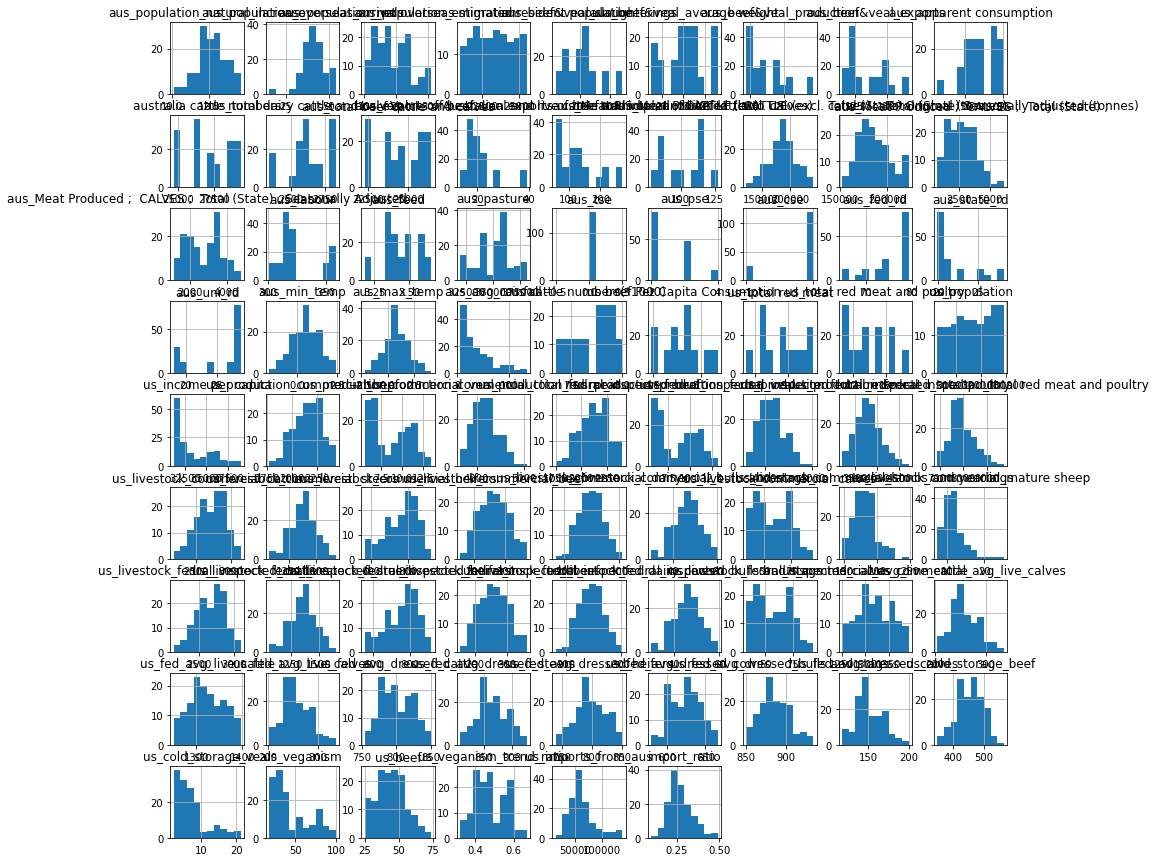

In [10]:
# Histogram of all numeric fields
df_hist = combined_data
df_hist.hist(figsize=(15,15));

### Checking time series properties of target variable y


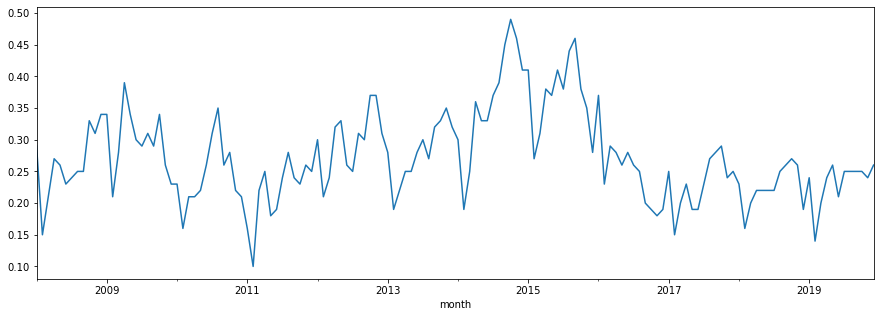

In [11]:
# plot the import ratio trend
_ = combined_data['import_ratio'].plot(figsize=(15, 5))

#color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
#_ = only_y.plot(style='.', figsize=(15,5), color=color_pal[0], title='Import Ratio')



In [8]:
# check if stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(combined_data.import_ratio.dropna())
print('p-value: %f' % result[1])

# 0.164061
#Since the p-value is over 0.05, the data is not stationary

p-value: 0.164061


### Decomposition

For selecting the right model is to see in our plot if the trend and seasonal variation are relatively constant over time, in other words, linear. If yes, then we will select the Additive model. Otherwise, if the trend and seasonal variation increase or decrease over time then we use the Multiplicative model.

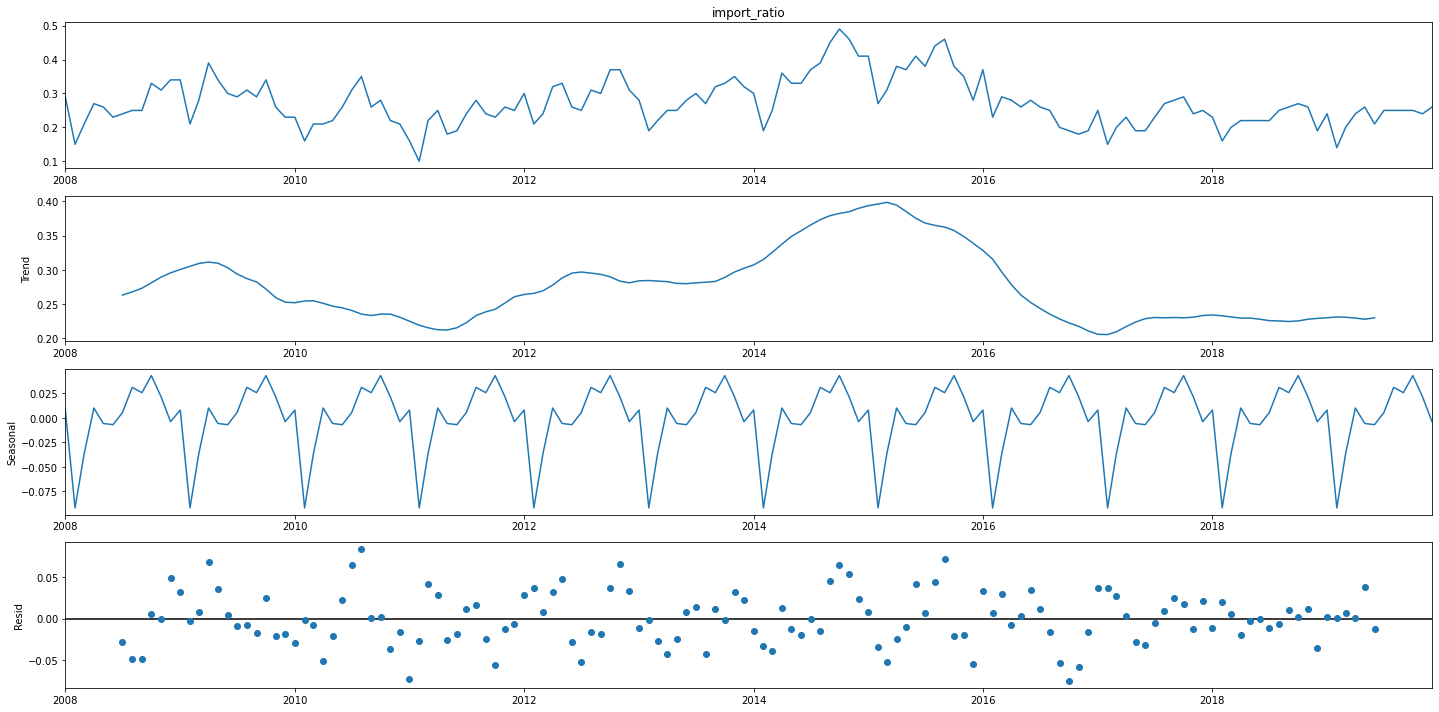

In [9]:
result=seasonal_decompose(combined_data['import_ratio'], model='Additive', period=12)
plt.rcParams['figure.figsize'] = (20.0, 10.0)
result.plot()
plt.show()

We have used the additive model for decomposition which assumes that the time series data is structured in the following manner:

Time Series Data = Trend + Seasonal + Random

We can observe that the seasonal pattern is a regularly repeating pattern and that the trend is not a smooth line.

In [10]:
#import matplotlib.pyplot
#result=seasonal_decompose(combined_data['import_ratio'], model='multiplicable', period=12)
#result.plot()
#plt.rcParams['figure.figsize'] = (20.0, 10.0)
#result.plot()
#plt.show()

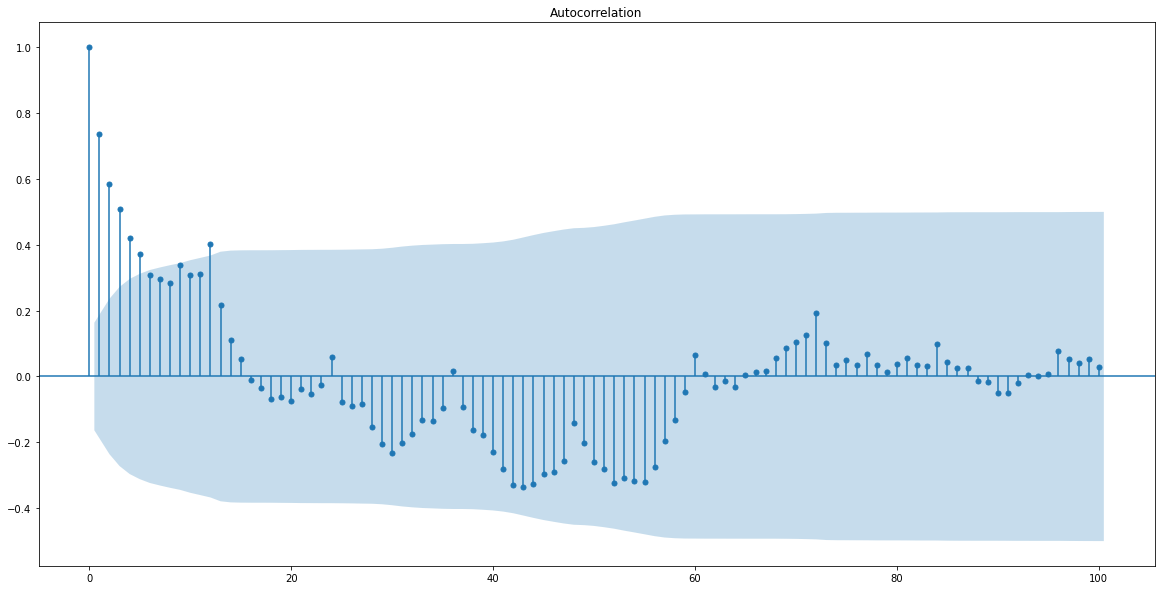

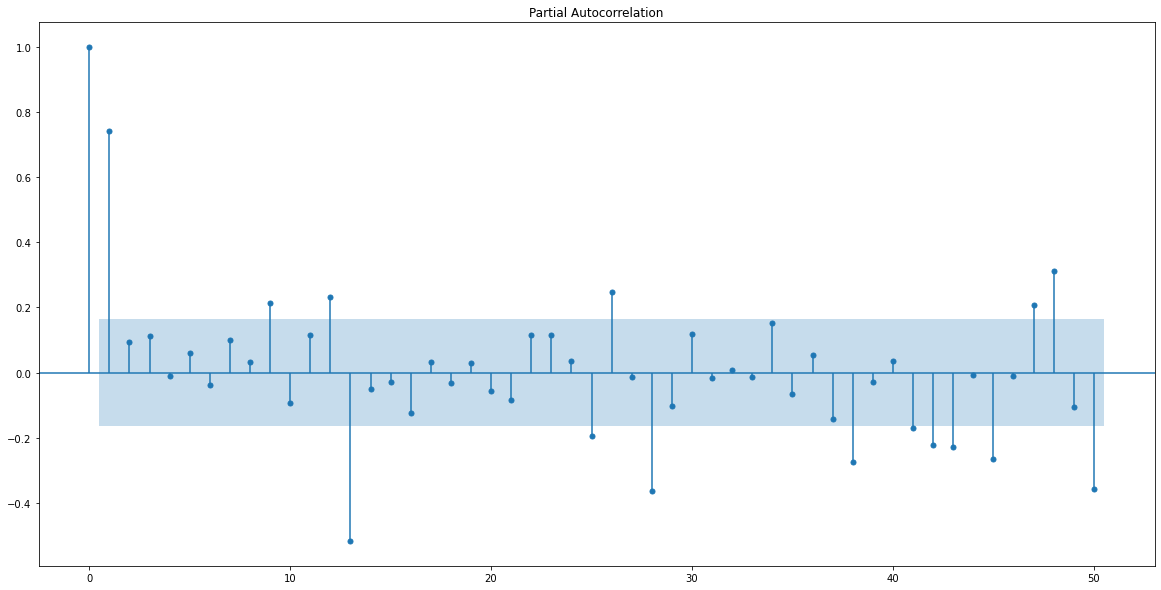

In [11]:
# ACF Plot of Target Variable
from statsmodels.tsa.stattools import pacf
import statsmodels.api
#import statsmodels.graphics.tsaplots.plot_acf
statsmodels.graphics.tsaplots.plot_acf(combined_data['import_ratio'],lags= 100)
plt.show()

# PACF plot of target variable
statsmodels.graphics.tsaplots.plot_pacf(combined_data['import_ratio'], lags=50)
plt.show()

The dataset is non-stationary as can be seen from the ACF and PACF plots

### Outlier Detection


In [12]:
# check the col number of colname
out = np.argwhere(combined_data.columns.isin(['total_us_imports', 'us_imports_from_aus', "us_livestock_commercial_steers"])).ravel()
print(out)

out = np.argwhere(combined_data1.columns.isin(['total_us_imports', 'us_imports_from_aus', "us_livestock_commercial_steers"])).ravel()
print(out)


[46 76 77]
[47 77 78]


#### Change column type

In [14]:
# steer and us_import got object type, so we need to convert it to float which is a type we need for later
combined_data["us_livestock_commercial_steers"] = pd.to_numeric(combined_data.us_livestock_commercial_steers, errors='coerce')
#combined_data["us_livestock_commercial_steers"]
combined_data["total_us_imports"] = pd.to_numeric(combined_data.total_us_imports, errors='coerce')
#combined_data["total_us_imports"]

combined_data1["us_livestock_commercial_steers"] = pd.to_numeric(combined_data1.us_livestock_commercial_steers, errors='coerce')
#combined_data["us_livestock_commercial_steers"]
combined_data1["total_us_imports"] = pd.to_numeric(combined_data1.total_us_imports, errors='coerce')
#combined_data["total_us_imports"]

# get the col type
a = combined_data.columns.to_series().groupby(combined_data.dtypes).groups

b = combined_data1.columns.to_series().groupby(combined_data1.dtypes).groups
#b


# check a specific col type
#c = combined_data.iloc[:,45:48]
#c.dtypes



In [15]:
# Outlier Detection using Inter Quartile Range
def out_iqr(s, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]
    
    
# For comparison, make one array each at varying values of k.
df1 = combined_data
df2 = combined_data1.drop(columns=['month'],axis=1)

iqr1 = df1.apply(out_iqr, k=1.5)
iqr2 = df2.apply(out_iqr, k=1.5)

iqr1.to_csv("out.csv")

iqr1.head(10)
#iqr2.head(10)

aus_population_natural_increase  aus_population_overseas_arrivals  \
month                                                                           
2008-01-01                            False                             False   
2008-02-01                            False                             False   
2008-03-01                            False                             False   
2008-04-01                            False                             False   
2008-05-01                            False                             False   
2008-06-01                            False                             False   
2008-07-01                            False                             False   
2008-08-01                            False                             False   
2008-09-01                            False                             False   
2008-10-01                            False                             False   

            aus_population_net overseas migration  \
month                                               
2008-01-01                                  False   
2008-02-01                                  False   
2008-03-01                                  False   
2008-04-01                                  False   
2008-05-01                                  False   
2008-06-01                                  False   
2008-07-01                                  False   
2008-08-01                                  False   
2008-09-01                                  False   
2008-10-01                                  False   

            aus_population_estimated resident population  \
month                                                      
2008-01-01                                         False   
2008-02-01                                         False   
2008-03-01                                         False   
2008-04-01                                         False   
2008-05-01                                         False   
2008-06-01                                         False   
2008-07-01                                         False   
2008-08-01                                         False   
2008-09-01                                         False   
2008-10-01                                         False   

            aus_beef&veal_slaughterings  aus_beef&veal_average weight  \
month                                                                   
2008-01-01                        False                         False   
2008-02-01                        False                         False   
2008-03-01                        False                         False   
2008-04-01                        False                         False   
2008-05-01                        False                         False   
2008-06-01                        False                         False   
2008-07-01                        False                         False   
2008-08-01                        False                         False   
2008-09-01                        False                         False   
2008-10-01                        False                         False   

            aus_beef&veal_production  aus_beef&veal_exports  \
month                                                         
2008-01-01                     False                  False   
2008-02-01                     False                  False   
2008-03-01                     False                  False   
2008-04-01                     False                  False   
2008-05-01                     False                  False   
2008-06-01                     False                  False   
2008-07-01                     False                  False   
2008-08-01                     False                  False   
2008-09-01                     False                  False   
2008-10-01                     False                  False   

            aus_apparent consumption  australia

In [10]:
#combined_data1.tail(30)

ab, ah, bc, bv, ca, f, n, u,z has large amount of outliers

### Outlier treatment


In [18]:
for column in df1:
    df1[column] = np.where(iqr1[column] == True,'NaN',df1[column])
cols = df1.columns
df1[cols] = df1[cols].apply(pd.to_numeric, errors='coerce')


for column in df2:
    df2[column] = np.where(iqr1[column] == True,'NaN',df2[column])
cols = df2.columns
df2[cols] = df2[cols].apply(pd.to_numeric, errors='coerce')

#df1.tail(30)
#df2.tail(30)

All the identified outliers are replaced by nulls first.

In [19]:
#Use linear interpolation to fill up nulls
no_month_df = df1.interpolate(method='linear', axis=0).bfill().ffill()

month_df = df2.interpolate(method='linear', axis=0).bfill().ffill()
combined_data1['month'] = pd.to_datetime(combined_data1['month'])
month_df = pd.concat([combined_data1['month'],month_df], axis=1)

#no_month_df.tail(30)
#no_month_df.head(5)
#month_df.head(5)
#month_df.tail(30)
#month_df.to_csv("no_outlier.csv")

#month_df.info()

<AxesSubplot:>

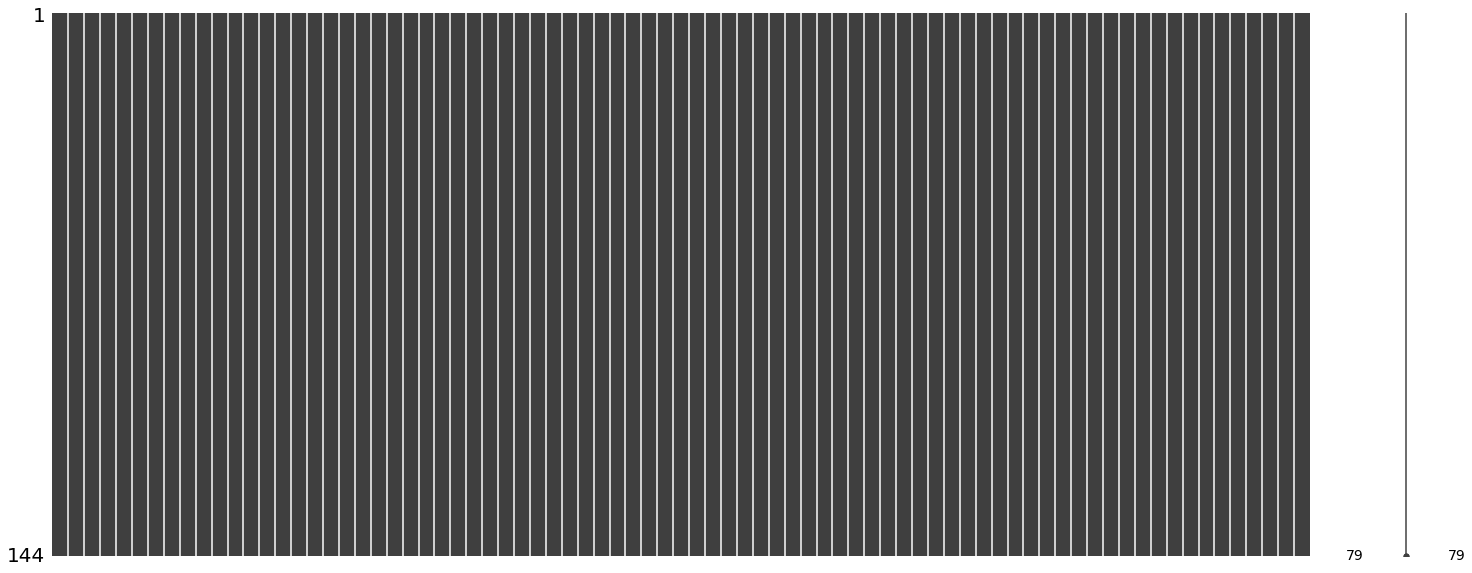

In [22]:
msno.matrix(no_month_df)

## Feature Engineering

refers to the process of creating new variables from existing ones which capture hidden business insights

### Lag features 
- are values at prior time steps
- the features have a lagged impact on the target variable
- The best way to find the optimal number of lags to chose for each field is to look at cross correlation graphs.
- Cross correlation graphs show the correlation between the target variable with various lags of raw features

In [18]:
len(no_month_df.columns)
no_month_df.columns[78]

'import_ratio'

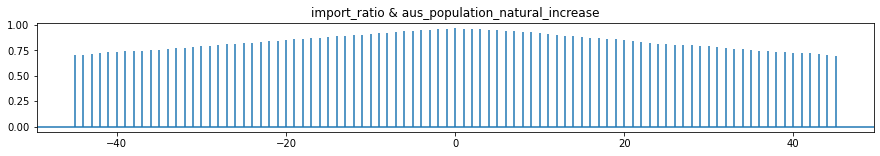

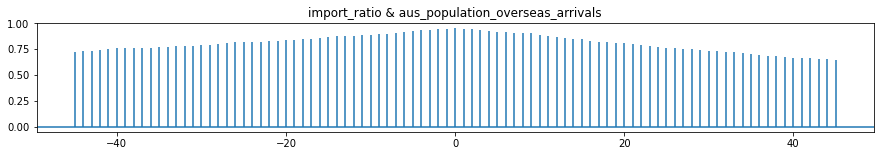

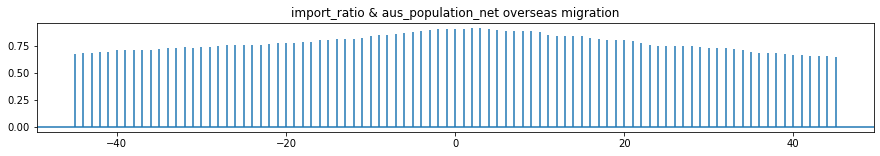

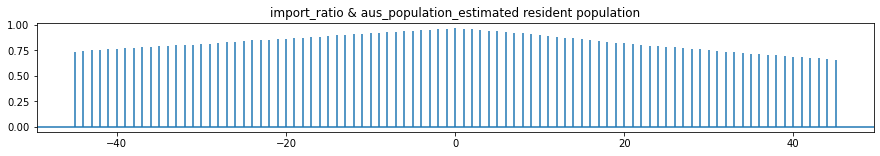

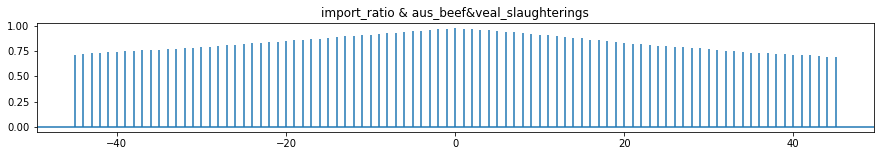

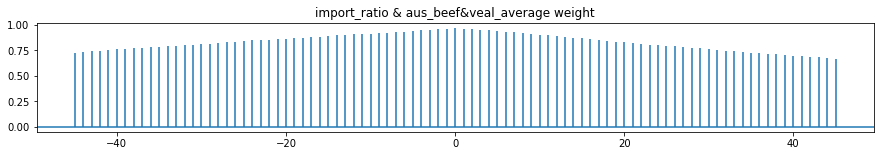

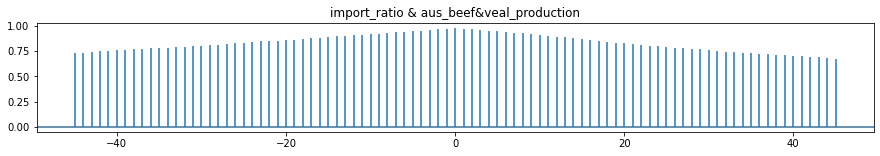

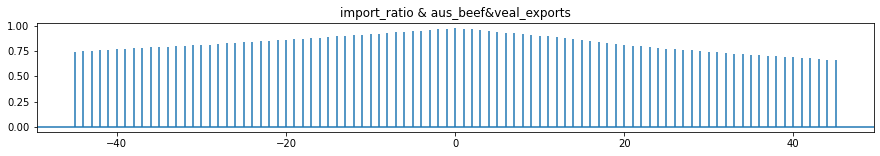

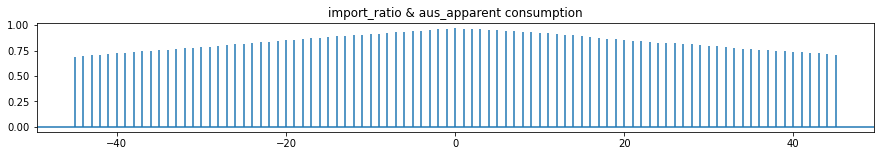

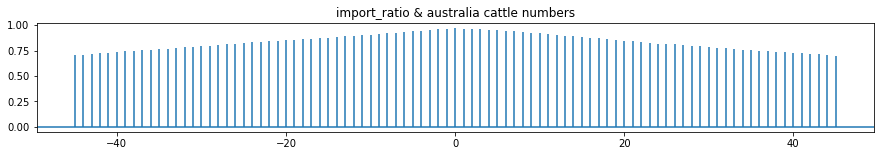

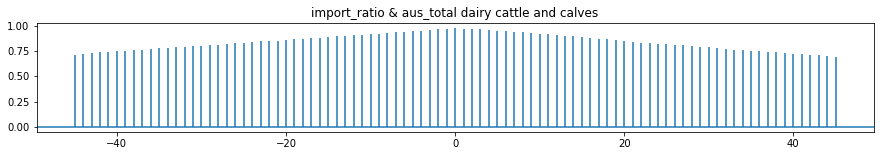

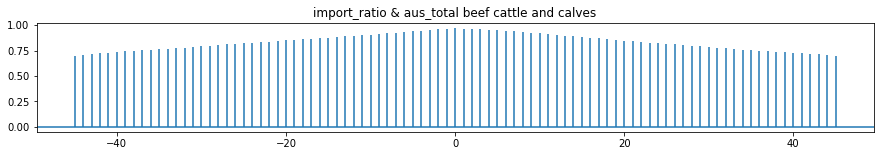

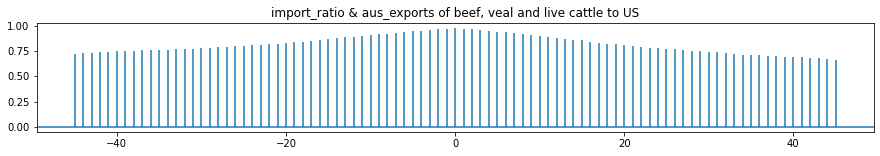

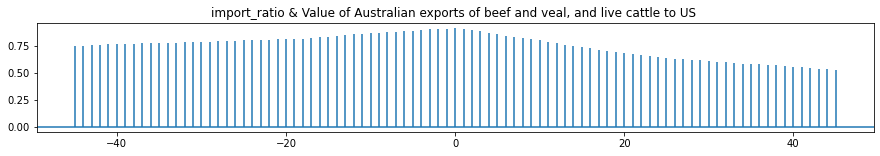

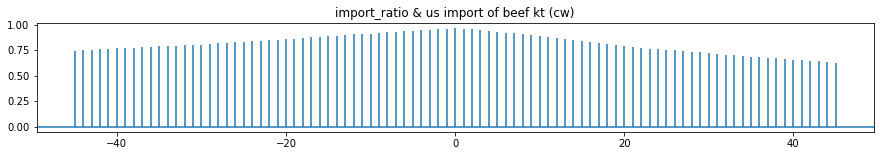

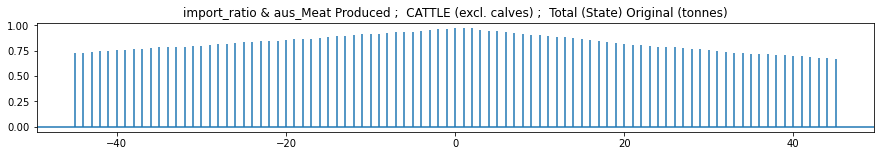

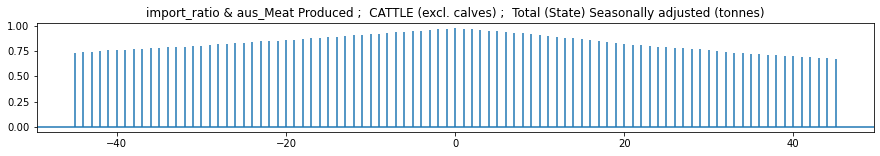

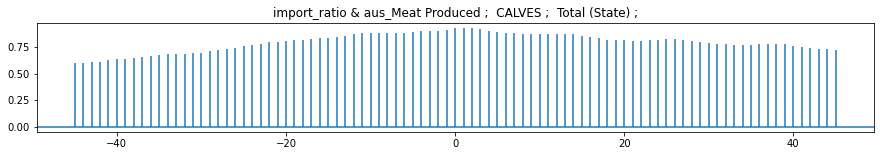

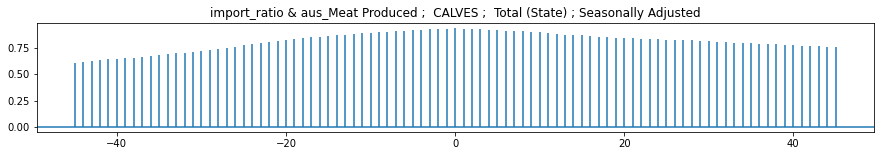

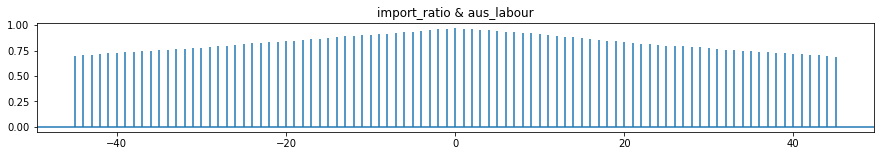

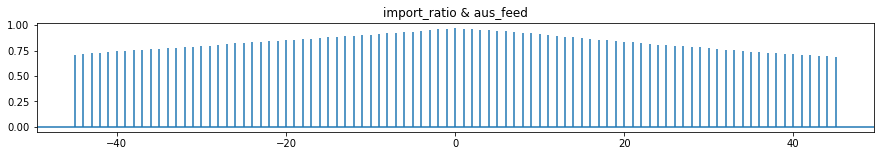

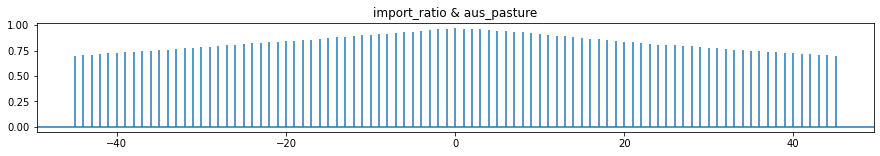

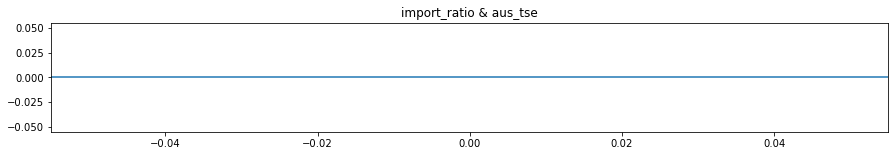

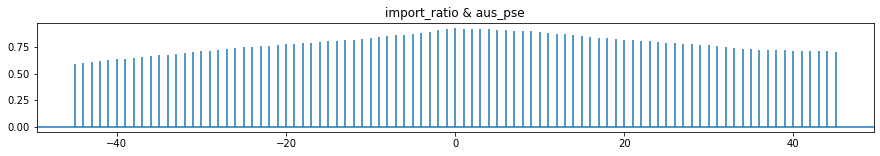

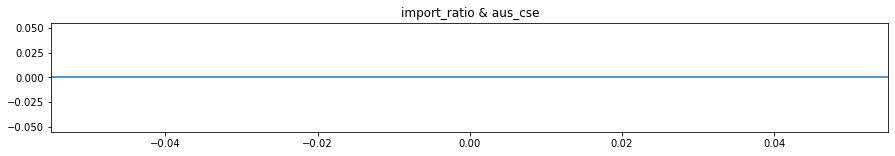

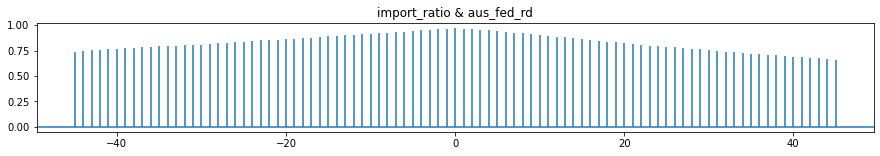

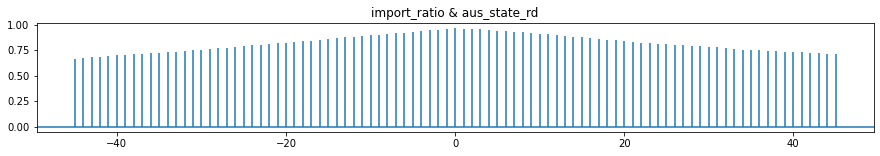

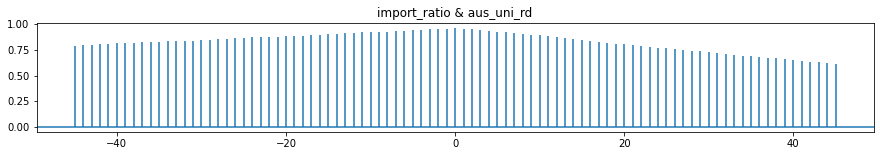

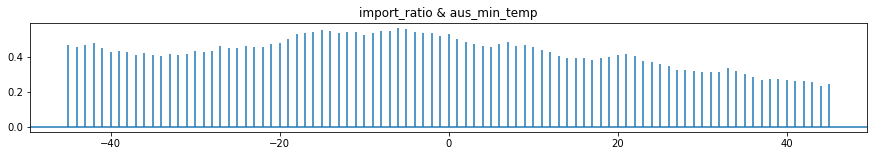

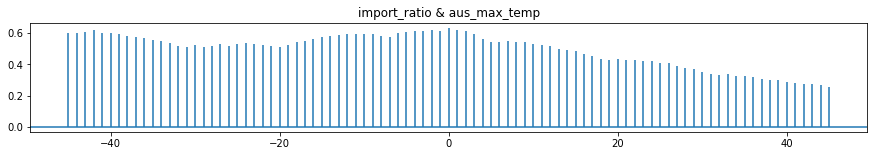

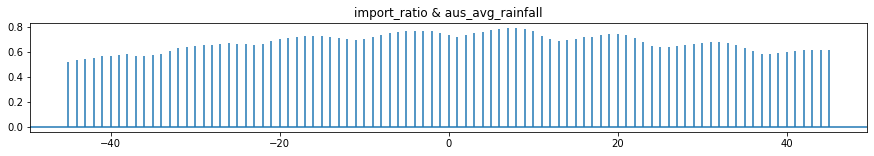

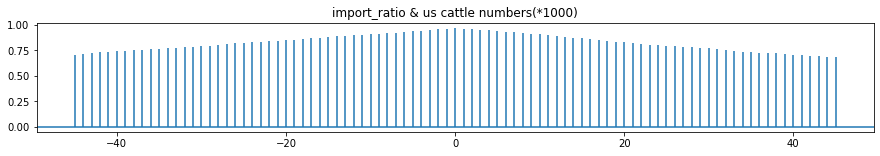

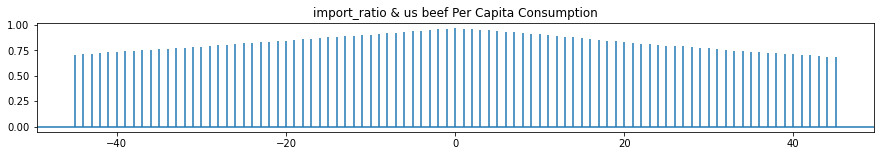

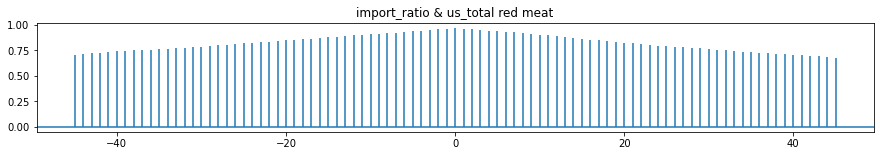

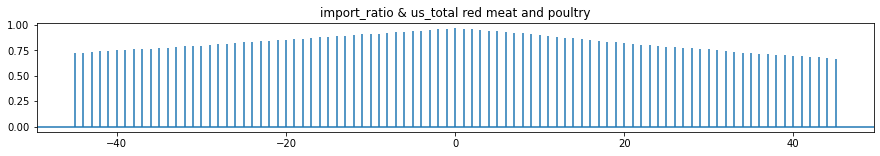

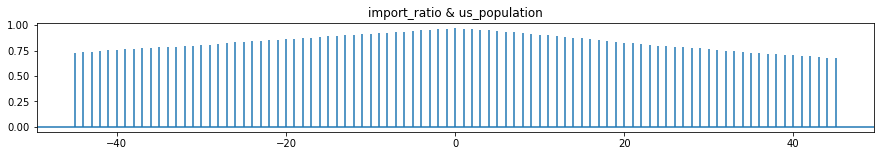

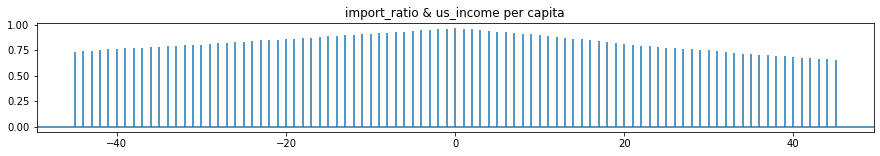

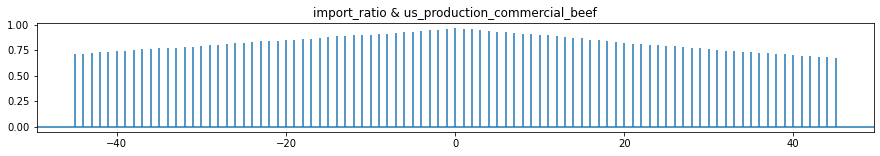

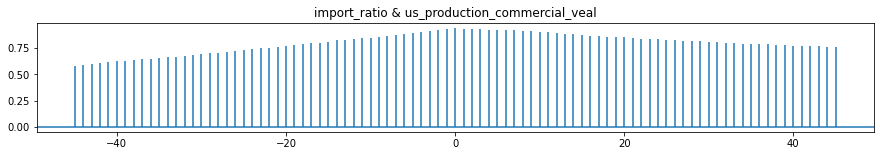

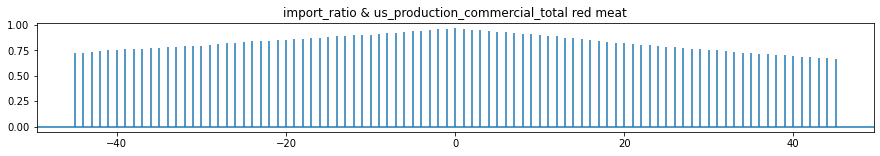

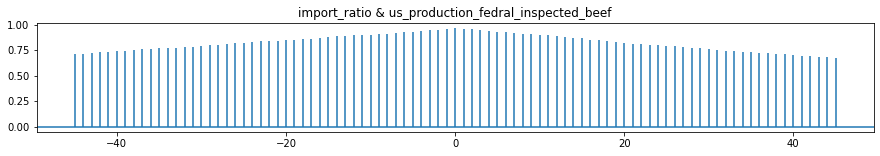

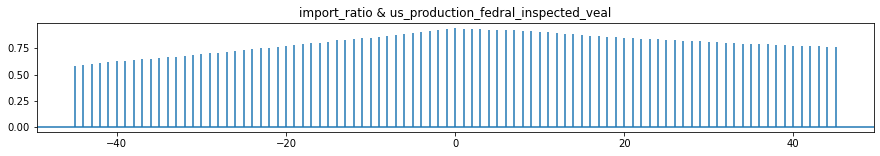

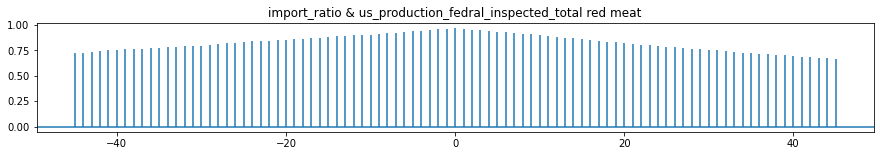

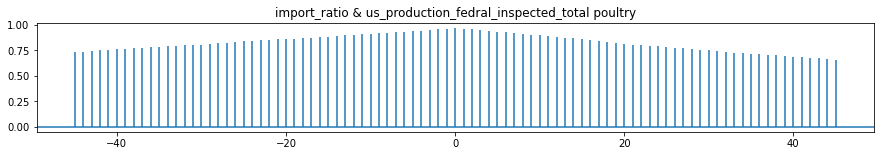

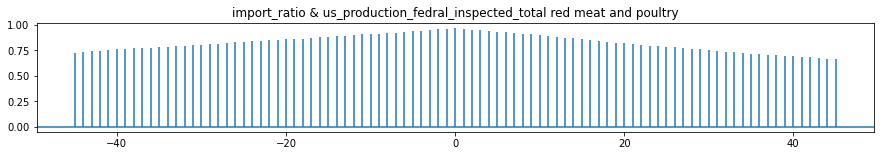

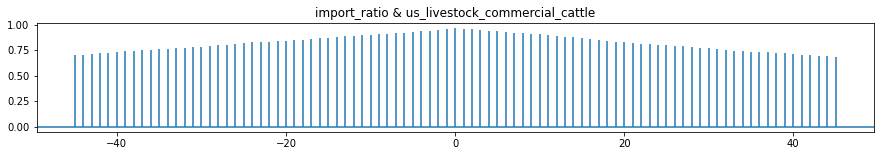

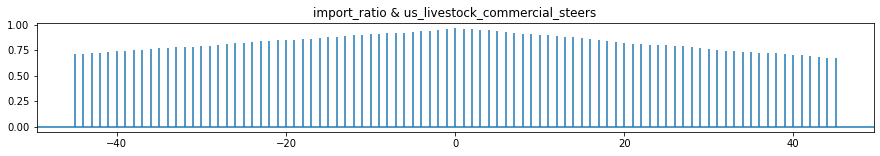

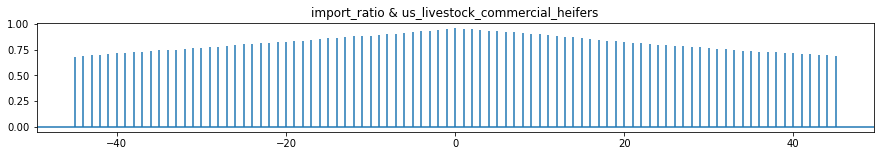

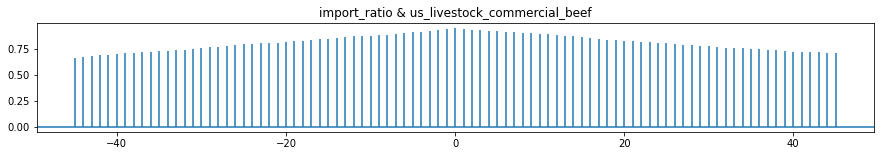

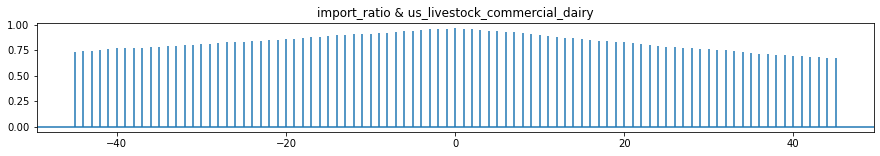

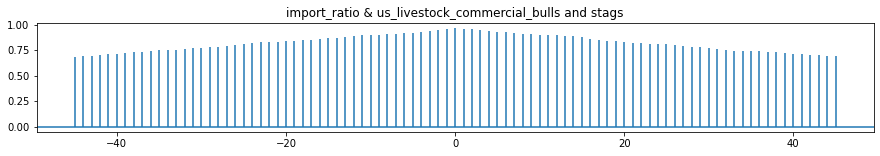

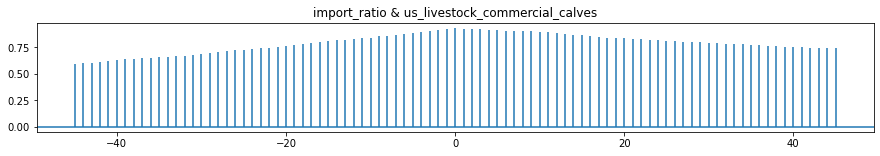

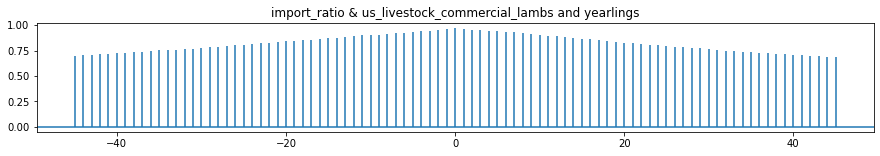

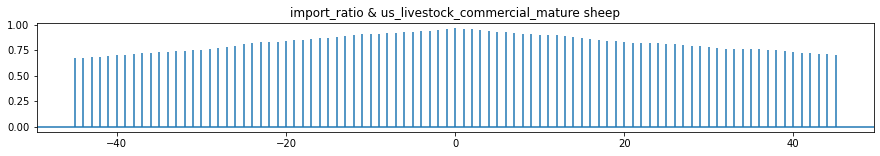

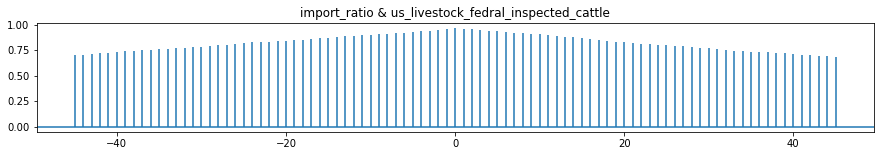

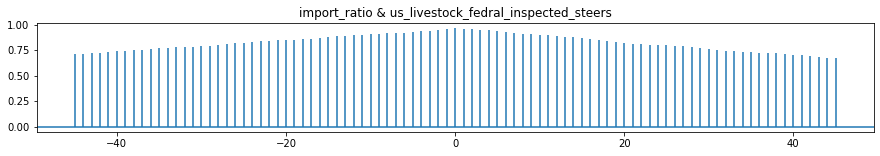

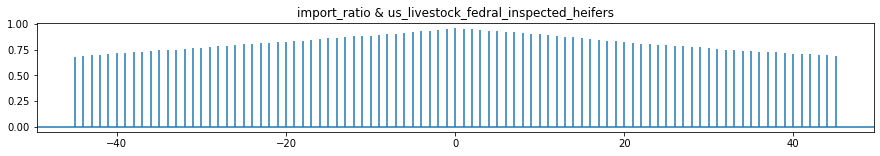

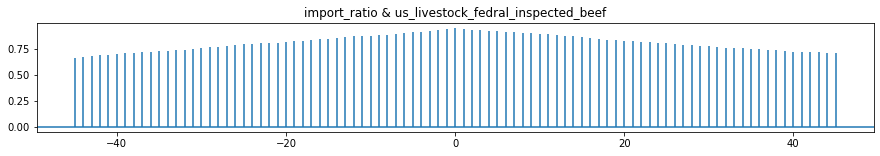

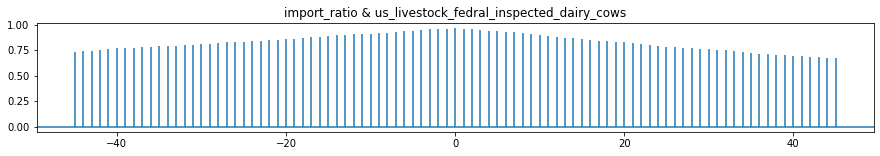

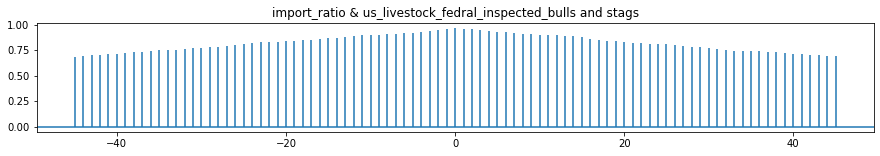

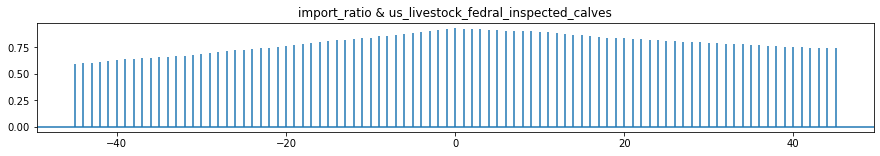

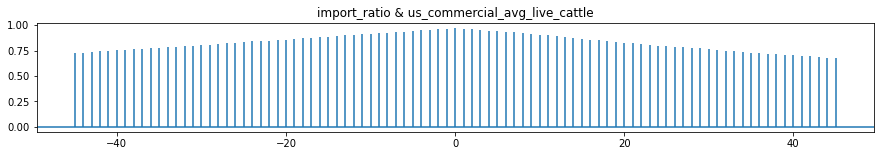

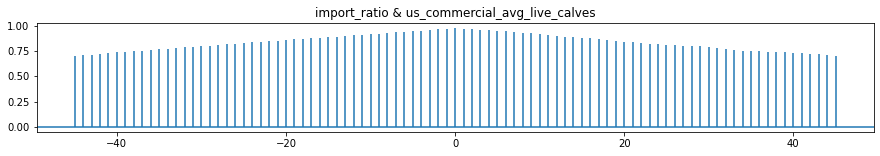

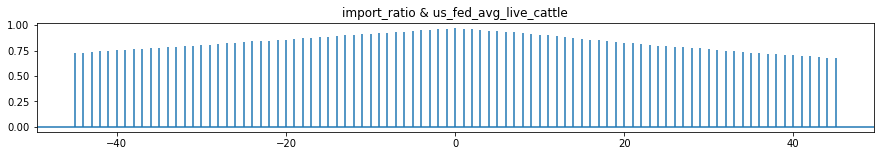

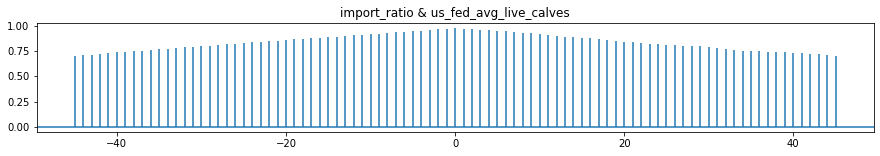

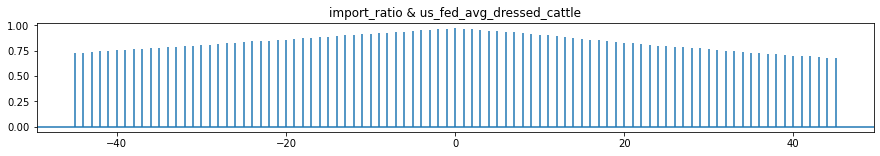

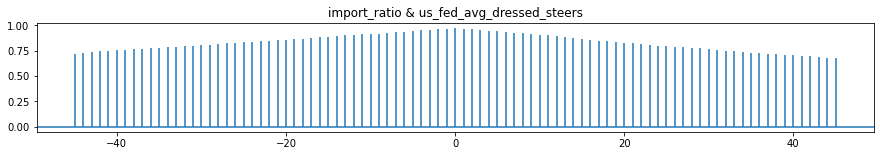

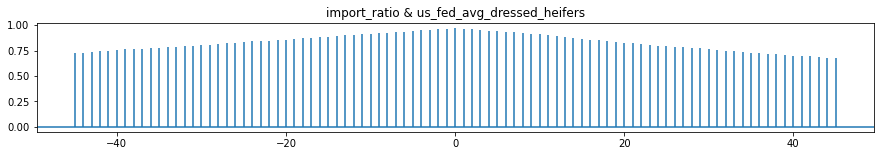

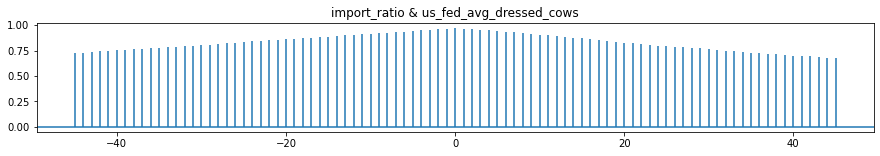

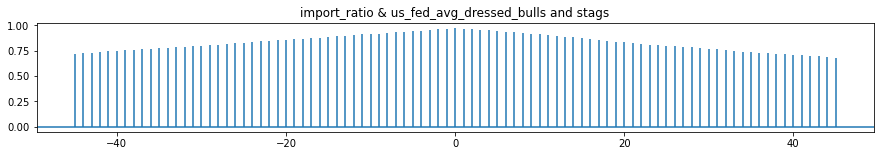

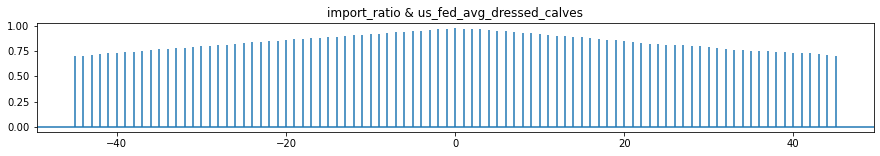

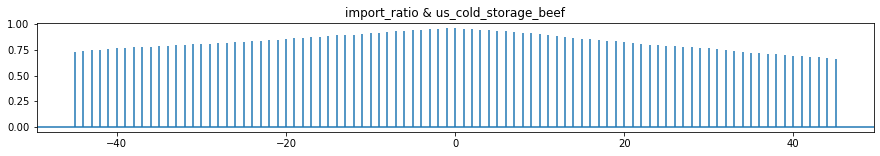

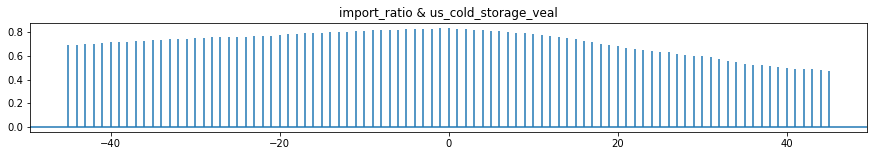

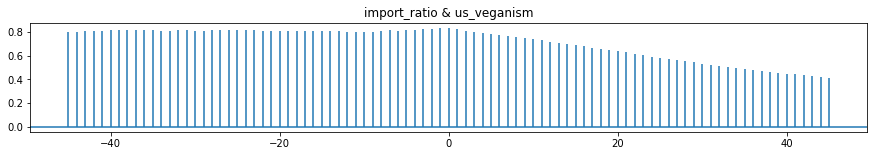

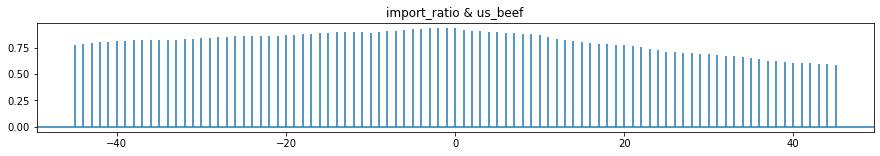

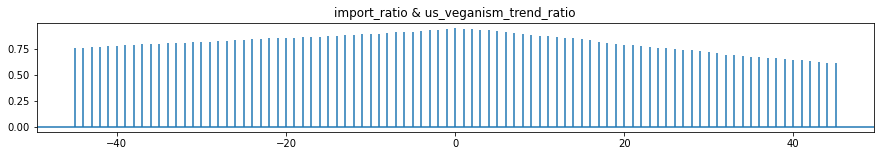

In [19]:
# Check Optimal Number of Lags
for i in range(len(no_month_df.columns)-3):
    plt.figure(i, figsize=(15,2)) # add this statement before your plot
    plt.xcorr(no_month_df.iloc[:,78],no_month_df.iloc[:,i],maxlags=45, usevlines=1)
    plt.title(no_month_df.columns[78] + ' & '+ no_month_df.columns[i])
    plt.show()

In [13]:
def lag_feature(df, lags, new_df_col, target_col):
    tmp = df[new_df_col]
    for i in lags:
        tmp[target_col+'_lag_'+str(i)] = df[target_col].shift(i)
    
    tmp[target_col] = df[target_col]
    return tmp

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            df[col].fillna(0, inplace=True)         
    return df

In [14]:
#### create lag features
# for data with outlier
df = combined_data
new_df_col = df.columns[:-3]
target_col = 'import_ratio'

combined_data_lag = lag_feature(df, [1,2,3,4], new_df_col, target_col)

combined_data_lag = fill_na(combined_data_lag)
combined_data_lag


df1 = combined_data1
new_df_col1 = ['month']
tmp_name = df.columns[:-3]
for i in range(len(tmp_name)):
    new_df_col1.append(tmp_name[i])

target_col1 = 'import_ratio'
combined_data1_lag = lag_feature(df1, [1,2,3,4], new_df_col1, target_col1)
combined_data1_lag = fill_na(combined_data1_lag)
combined_data1_lag




month  aus_population_natural_increase  \
0   2008-01-01                             14.0   
1   2008-02-01                             14.0   
2   2008-03-01                             14.0   
3   2008-04-01                             12.6   
4   2008-05-01                             12.6   
..         ...                              ...   
139 2019-08-01                             10.8   
140 2019-09-01                             10.8   
141 2019-10-01                             11.4   
142 2019-11-01                             11.4   
143 2019-12-01                             11.4   

     aus_population_overseas_arrivals  aus_population_net overseas migration  \
0                                48.9                                   31.1   
1                                48.9                                   31.1   
2                                48.9                                   31.1   
3                                39.4                                   21.7   
4                                39.4                                   21.7   
..                                ...                                    ...   
139                              54.2                                   24.8   
140                              54.2                                   24.8   
141                              50.7                                   14.3   
142                              50.7                                   14.3   
143                              50.7                                   14.3   

     aus_population_estimated resident population  \
0                                         21016.1   
1                                         21060.4   
2                                         21104.6   
3                                         21148.9   
4                                         21182.3   
..                                            ...   
139                                       25401.3   
140                                       25436.8   
141                                       25472.4   
142                                       25498.1   
143                                       25523.9   

     aus_beef&veal_slaughterings  aus_beef&veal_average weight  \
0                          722.7                          20.5   
1                          722.7                          20.5   
2                          722.7                          20.5   
3                          722.7                          20.5   
4                          722.7                          20.5   
..                           ...                           ...   
139                        724.9                          22.8   
140                        724.9                          22.8   
141                        724.9                          22.8   
142                        724.9                          22.8   
143                        724.9                          22.8   

     aus_beef&veal_production  aus_beef&veal_exports  \
0                       177.7                  120.0   
1                       177.7                  120.0   
2                       177.7                  120.0   
3                       177.7                  120.0   
4                       177.7                  120.0   
..                        ...                    ...   
139                     197.7                  155.1   
140                     197.7                  155.1   
141                     197.7                  155.1   
142                     197.7                  155.1   
143                     197.7                  155.1   

     aus_apparent consumption  ...  us_cold_storage_beef  \
0                        57.2  ...                482.51   
1                        57.2  ...                450.78   
2                        57.2  ...                436.55   
3                        57.2  ...                426.71   
4                        57.2  .

In [15]:
# for data without outlier
df2 = no_month_df
new_df_col2 = df2.columns[:-3]
target_col = 'import_ratio'

no_month_df_lag = lag_feature(df2, [1,2,3,4], new_df_col2, target_col)

no_month_df_lag = fill_na(no_month_df_lag)
no_month_df_lag


df3 = month_df
new_df_col3 = ['month']
tmp_name = df2.columns[:-3]
for i in range(len(tmp_name)):
    new_df_col3.append(tmp_name[i])

target_col1 = 'import_ratio'
month_df_lag = lag_feature(df3, [1,2,3,4], new_df_col3, target_col1)
month_df_lag = fill_na(month_df_lag)
month_df_lag


month  aus_population_natural_increase  \
0   2008-01-01                             14.0   
1   2008-02-01                             14.0   
2   2008-03-01                             14.0   
3   2008-04-01                             12.6   
4   2008-05-01                             12.6   
..         ...                              ...   
139 2019-08-01                             10.8   
140 2019-09-01                             10.8   
141 2019-10-01                             11.4   
142 2019-11-01                             11.4   
143 2019-12-01                             11.4   

     aus_population_overseas_arrivals  aus_population_net overseas migration  \
0                                48.9                                   31.1   
1                                48.9                                   31.1   
2                                48.9                                   31.1   
3                                39.4                                   21.7   
4                                39.4                                   21.7   
..                                ...                                    ...   
139                              54.2                                   24.8   
140                              54.2                                   24.8   
141                              50.7                                   14.3   
142                              50.7                                   14.3   
143                              50.7                                   14.3   

     aus_population_estimated resident population  \
0                                         21016.1   
1                                         21060.4   
2                                         21104.6   
3                                         21148.9   
4                                         21182.3   
..                                            ...   
139                                       25401.3   
140                                       25436.8   
141                                       25472.4   
142                                       25498.1   
143                                       25523.9   

     aus_beef&veal_slaughterings  aus_beef&veal_average weight  \
0                          722.7                          20.5   
1                          722.7                          20.5   
2                          722.7                          20.5   
3                          722.7                          20.5   
4                          722.7                          20.5   
..                           ...                           ...   
139                        724.9                          22.8   
140                        724.9                          22.8   
141                        724.9                          22.8   
142                        724.9                          22.8   
143                        724.9                          22.8   

     aus_beef&veal_production  aus_beef&veal_exports  \
0                       177.7                  120.0   
1                       177.7                  120.0   
2                       177.7                  120.0   
3                       177.7                  120.0   
4                       177.7                  120.0   
..                        ...                    ...   
139                     197.7                  155.1   
140                     197.7                  155.1   
141                     197.7                  155.1   
142                     197.7                  155.1   
143                     197.7                  155.1   

     aus_apparent consumption  ...  us_cold_storage_beef  \
0                        57.2  ...                482.51   
1                        57.2  ...                450.78   
2                        57.2  ...                436.55   
3                        57.2  ...                426.71   
4                        57.2  .

## Now we have the data ready for modeling


## Train/Test Split
### Cut off the data after 2018 to use as our tes set. 



In [16]:
# no month: combine_data
test_df = combined_data.iloc[132:144,:]
train_df = combined_data.iloc[:132,:]
X_train, y_train = train_df.iloc[:,:76], train_df.iloc[:,78]
X_test, y_test = test_df.iloc[:,:76], test_df.iloc[:,78]

# Scale the features
#X_train = StandardScaler().fit_transform(X_train)
#X_test = StandardScaler().fit_transform(X_test)

# has month: combine_data1
test_df1 = combined_data1.iloc[132:144,:]
train_df1 = combined_data1.iloc[:132,:]
X_train1, y_train1 = train_df1.iloc[:,:77], train_df1.iloc[:,79]
X_test1, y_test1 = test_df1.iloc[:,:77], test_df1.iloc[:,79]

# no outlier no month: combine_data
test_no_outlier = no_month_df.iloc[132:144,:]
train_no_outlier = no_month_df.iloc[:132,:]
X_train_no_outlier, y_train_no_outlier = train_no_outlier.iloc[:,:76], train_no_outlier.iloc[:,78]
X_test_no_outlier, y_test_no_outlier = test_no_outlier.iloc[:,:76], test_no_outlier.iloc[:,78]

# Scale the features
#X_train_no_outlier = StandardScaler().fit_transform(X_train_no_outlier)
#X_test_no_outlier = StandardScaler().fit_transform(X_test_no_outlier)

# no outlier has month: combine_data
test_no_outlier1 = month_df.iloc[132:144,:]
train_no_outlier1 = month_df.iloc[:132,:]
X_train_no_outlier1, y_train_no_outlier1 = train_no_outlier1.iloc[:,:77], train_no_outlier1.iloc[:,79]
X_test_no_outlier1, y_test_no_outlier1 = test_no_outlier1.iloc[:,:77], test_no_outlier1.iloc[:,79]

test_df.to_csv("test.csv")
train_df.to_csv("train.csv")

#print(X_train)
#y_train1
#X_test1
#test_df1
#X_train_no_outlier.info()

We tune a set of 8 parameters for this model: 
- number of gradient boosted trees, 
- maximum tree depth for base learners, 
- boosting learning rate, 
- minimum loss reduction required to make a further partition on a leaf node 
- minimum sum of weights of all observations required in a child node
- subsample
- colsample_bytree

In [17]:
xgb_Test_Accuracy_Data = pd.DataFrame(columns = ['outlier','n_estimators','max_depth','min_child_weight',
                                                 'gamma','learning_rate','subsample','colsample_bytree',
                                                 'eta','Train Accurcay','Test Accurcay', 'RMSE','MAE'])

In [18]:
outlier = 'all_yes'

# Number of trees
n_estimators = 64

# Maximum number of levels in tree
max_depth = 15

#minimum sum of weights of all observations required in a child
min_child_weight = 0

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.601842
subsample = 0.585681 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.651577 # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

# better simple version
xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#model_all_yes= xgb_reg.fit(X_train, y_train)

evaluation = [(X_train, y_train), (X_test, y_test)]
model_all_yes = xgb_reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(X_train)
#predictions_train = xgb_reg.predict(X_train_no_outlier)

# Calculate the absolute errors
errors_train = abs(predictions_train - y_train)
#errors_train = abs(predictions_train - y_train_no_outlier)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ y_train)
#mape_train = 100 * (errors_train/ y_train_no_outlier)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(X_test)
#predictions_test = xgb_reg.predict(X_test_no_outlier)

# Calculate the absolute errors
errors_test = abs(predictions_test - y_test)
#errors_test = abs(predictions_test - y_test_no_outlier)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ y_test)
#mape_test = 100 * (errors_test/ y_test_no_outlier)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)



xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(X_test)

test_df['predictions'] = predictions
test_df1['predictions'] = predictions


# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(y_test, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(y_test, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  learning_rate  \
0  all_yes           64        15                0     0       0.601842   

   subsample  colsample_bytree  eta  Train Accurcay  Test Accurcay      RMSE  \
0   0.585681          0.651577  0.1        97.59071      95.834202  0.011869   

        MAE  
0  0.009808

In [19]:
np.mean(mape_test)

4.165798480484878

In [28]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(X_train, y_train)

    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    xgb_reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    #mse= mean_squared_error(y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|████████████████████████████████████████████████████████████| 1000/1000 [08:44<00:00,  1.91trial/s, best loss: 0.012224960804486006]
The best hyperparameters are :  

{'colsample_bytree': 0.8616290397073153, 'learning_rate': 0.4024107960054182, 'max_depth': 14.0, 'min_child_weight': 5.0, 'n_estimators': 1429.0, 'subsample': 0.5910023567388423}


## fit model with lag + all features

In [27]:
## data with lag features
## Has outlier
# no month: combine_data
test_df_lag = combined_data_lag.iloc[132:144,:]
train_df_lag = combined_data_lag.iloc[:132,:]
X_train_lag, y_train_lag = train_df_lag.iloc[:,:80], train_df_lag.iloc[:,80]
X_test_lag, y_test_lag = test_df_lag.iloc[:,:80], test_df_lag.iloc[:,80]

# Scale the features
#X_train = StandardScaler().fit_transform(X_train)
#X_test = StandardScaler().fit_transform(X_test)

# has month: combine_data1
test_df1_lag = combined_data1_lag.iloc[132:144,:]
train_df1_lag = combined_data1_lag.iloc[:132,:]
X_train1_lag, y_train1_lag = train_df1_lag.iloc[:,:81], train_df1_lag.iloc[:,81]
X_test1_lag, y_test1_lag = test_df1_lag.iloc[:,:81], test_df1_lag.iloc[:,81]

X_test1_lag

month  aus_population_natural_increase  \
132 2019-01-01                             12.7   
133 2019-02-01                             12.7   
134 2019-03-01                             12.7   
135 2019-04-01                             11.5   
136 2019-05-01                             11.5   
137 2019-06-01                             11.5   
138 2019-07-01                             10.8   
139 2019-08-01                             10.8   
140 2019-09-01                             10.8   
141 2019-10-01                             11.4   
142 2019-11-01                             11.4   
143 2019-12-01                             11.4   

     aus_population_overseas_arrivals  aus_population_net overseas migration  \
132                              51.1                                   20.9   
133                              51.1                                   20.9   
134                              51.1                                   20.9   
135                              41.5                                   12.7   
136                              41.5                                   12.7   
137                              41.5                                   12.7   
138                              54.2                                   24.8   
139                              54.2                                   24.8   
140                              54.2                                   24.8   
141                              50.7                                   14.3   
142                              50.7                                   14.3   
143                              50.7                                   14.3   

     aus_population_estimated resident population  \
132                                       25171.3   
133                                       25211.9   
134                                       25252.4   
135                                       25293.0   
136                                       25317.2   
137                                       25341.5   
138                                       25365.7   
139                                       25401.3   
140                                       25436.8   
141                                       25472.4   
142                                       25498.1   
143                                       25523.9   

     aus_beef&veal_slaughterings  aus_beef&veal_average weight  \
132                        725.3                          22.5   
133                        725.3                          22.5   
134                        725.3                          22.5   
135                        725.3                          22.5   
136                        725.3                          22.5   
137                        725.3                          22.5   
138                        724.9                          22.8   
139                        724.9                          22.8   
140                        724.9                          22.8   
141                        724.9                          22.8   
142                        724.9                          22.8   
143                        724.9                          22.8   

     aus_beef&veal_production  aus_beef&veal_exports  \
132                     196.0                  147.6   
133                     196.0                  147.6   
134                     196.0                  147.6   
135                     196.0                  147.6   
136                     196.0                  147.6   
137                     196.0                  147.6   
138                     197.7                  155.1   
139                     197.7                  155.1   
140                     197.7                  155.1   
141                     197.7                  155.1   
142                     197.7                  155.1   
143                     197.7                  155.1   

     aus_apparent consumpt

In [30]:
outlier = 'all_lag1234_yes'

## Parameter Setting

# Number of trees
n_estimators = 1759

# Maximum number of levels in tree
max_depth = 11

#minimum sum of weights of all observations required in a child
min_child_weight = 5

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.4632216392663074
subsample = 0.4964381902212262 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.7856926935466556  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#model_all_lag_yes= xgb_reg.fit(X_train_lag, y_train_lag)

evaluation = [(X_train_lag, y_train_lag), (X_test_lag, y_test_lag)]
model_all_lag_yes = xgb_reg.fit(X_train_lag, y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(X_train_lag)

# Calculate the absolute errors
errors_train = abs(predictions_train - y_train_lag)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ y_train_lag)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(X_test_lag)

# Calculate the absolute errors
errors_test = abs(predictions_test - y_test_lag)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ y_test_lag)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(X_test_lag)

test_df_lag['predictions'] = predictions
test_df1_lag['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(y_test_lag, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(y_test_lag, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0          all_yes           64        15                0     0   
0  all_lag1234_yes         1759        11                5     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.601842   0.585681          0.651577  0.1        97.59071   
0       0.463222   0.496438          0.785693  0.1        88.20690   

   Test Accurcay      RMSE       MAE  
0      95.834202  0.011869  0.009808  
0      89.992982  0.025534  0.020715

In [49]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(X_train_lag, y_train_lag)

    evaluation = [(X_train_lag, y_train_lag), (X_test_lag, y_test_lag)]
    
    xgb_reg.fit(X_train_lag, y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(X_test_lag)
    rmse = np.sqrt(mean_squared_error(y_test_lag, predictions))
    mae = mean_absolute_error(y_test_lag, predictions)
    #mse= mean_squared_error(y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|██████████| 1000/1000 [04:40<00:00,  3.57trial/s, best loss: 0.010304922068299796]
The best hyperparameters are :  

{'colsample_bytree': 0.7856926935466556, 'learning_rate': 0.4632216392663074, 'max_depth': 11.0, 'min_child_weight': 5.0, 'n_estimators': 1759.0, 'subsample': 0.4964381902212262}


### Feature Selection
- based on feature score from xgboost
- based on shap value

In [28]:
X_train.shape 
# there are 76 features in total

(132, 76)

In [32]:
### Based Feature score from XGBoost (Gain)
from numpy import sort
from sklearn.feature_selection import SelectFromModel


thresholds = sort(model_all_yes.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_all_yes, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    
    # train model
    selection_model = xgb.XGBRegressor()
    #selection_model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
    #                               max_depth = max_depth, min_child_weight = min_child_weight,
    #                               gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
    #                               eta = eta, seed = seed)
    
    selection_model.fit(select_X_train, y_train)
    
    evaluation = [(select_X_train, y_train), (select_X_test, y_test)]
    
    #selection_model.fit(select_X_train, y_train,
    #                    eval_set=evaluation, eval_metric="rmse",
    #                    early_stopping_rounds=10,verbose=False)
    
    # eval model
    #select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    
    #accuracy = accuracy_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    errors_test = abs(y_pred - y_test)
    mape_test = 100 * (errors_test/ y_test)
    mape = np.mean(mape_test)
    
    #print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Thresh=%.8f, n=%d, RMSE: %.8f, MAE: %.8f, MAPE: %.8f" % (thresh, select_X_train.shape[1], rmse, mae, mape))

Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00000000, n=76, RMSE: 0.03154282, MAE: 0.02345437, MAPE: 11.75939877
Thresh=0.00001167, n=65, RMSE: 0.02739452, MAE: 0.02031924, MAPE: 10.29154490
Thresh=0.00001230, n=64, RMSE: 0.02727379, MAE: 0.02036348, MAPE

From above output we can see that :

no metric & mse metric for all_yes:
- Thresh=0.00049075, n=29, RMSE: 0.02233834, MAE: 0.01457127, MAPE: 7.79528960
- Thresh=0.00006716, n=59, RMSE: 0.02432796, MAE: 0.01904817, MAPE: 9.30896135
we try n=29

no metric & mse metric for all_yes:
- Thresh=0.00049075, n=29, RMSE: 0.02233834, MAE: 0.01457127, MAPE: 7.79528960
- Thresh=0.00006716, n=59, RMSE: 0.02432796, MAE: 0.01904817, MAPE: 9.30896135
we try n=29

provide the overall best performance

In [33]:
importances = list(zip(model_all_yes.feature_importances_, X_train.columns))
importances.sort(reverse=True)
importances
#pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

[(0.47131976, 'us_livestock_commercial_cattle'),
 (0.18954171, 'us_total red meat and poultry'),
 (0.06493114, 'us_livestock_fedral_inspected_bulls and stags'),
 (0.057640385, 'aus_beef&veal_slaughterings'),
 (0.05508407, 'aus_avg_rainfall'),
 (0.039072208, 'aus_total dairy cattle and calves'),
 (0.036366448, 'us_veganism'),
 (0.022757273, 'us beef Per Capita Consumption'),
 (0.008563596, 'us_fed_avg_dressed_steers'),
 (0.0061975643, 'us_population'),
 (0.0057268473, 'us_cold_storage_beef'),
 (0.0056812307, 'us_veganism_trend_ratio'),
 (0.0047323294, 'us_commercial_avg_live_calves'),
 (0.0034371207, 'us_livestock_commercial_bulls and stags'),
 (0.002925601, 'aus_pse'),
 (0.002883688, 'us_livestock_commercial_heifers'),
 (0.002510166, 'us_income per capita'),
 (0.0024862795, 'us_production_fedral_inspected_total red meat'),
 (0.002058586, 'us_cold_storage_veal'),
 (0.0011071243, 'us_livestock_fedral_inspected_steers'),
 (0.0010199329, 'us_production_fedral_inspected_veal'),
 (0.00101733

In [34]:
x = model_all_yes.get_booster().get_score(importance_type = "gain")
sortedx = {k:v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
np.array([k for k, v in sortedx.items()])

array(['us_livestock_commercial_cattle', 'us_total red meat and poultry',
       'us_livestock_fedral_inspected_bulls and stags',
       'aus_beef&veal_slaughterings', 'aus_avg_rainfall',
       'aus_total dairy cattle and calves', 'us_veganism',
       'us beef Per Capita Consumption', 'us_fed_avg_dressed_steers',
       'us_population', 'us_cold_storage_beef', 'us_veganism_trend_ratio',
       'us_commercial_avg_live_calves',
       'us_livestock_commercial_bulls and stags', 'aus_pse',
       'us_livestock_commercial_heifers', 'us_income per capita',
       'us_production_fedral_inspected_total red meat',
       'us_cold_storage_veal', 'us_livestock_fedral_inspected_steers',
       'us_production_fedral_inspected_veal', 'us_beef',
       'us_livestock_fedral_inspected_dairy_cows',
       'us_livestock_commercial_lambs and yearlings',
       'us_fed_avg_live_calves',
       'us_production_fedral_inspected_total poultry', 'aus_pasture',
       'us_production_fedral_inspected_total red 

In [31]:
a = ['us_livestock_commercial_cattle',
       'us_livestock_fedral_inspected_bulls and stags',
       'us_total red meat and poultry', 'aus_avg_rainfall',
       'aus_beef&veal_slaughterings', 'aus_total dairy cattle and calves',
       'us_veganism', 'us beef Per Capita Consumption',
       'us_cold_storage_beef', 'us_population',
       'us_fed_avg_dressed_steers', 'us_veganism_trend_ratio',
       'us_livestock_commercial_bulls and stags',
       'us_commercial_avg_live_calves', 'us_livestock_commercial_heifers',
       'us_cold_storage_veal', 'aus_pse',
       'us_production_fedral_inspected_total red meat',
       'us_income per capita', 'us_production_fedral_inspected_veal',
       'us_beef', 'us_livestock_fedral_inspected_steers',
       'us_fed_avg_live_calves', 'aus_population_net overseas migration',
       'us_livestock_commercial_lambs and yearlings',
       'us_production_fedral_inspected_total red meat and poultry',
       'us_livestock_fedral_inspected_dairy_cows',
       'us_production_fedral_inspected_total poultry', 'aus_pasture']
len(a)

29

In [ ]:
x = model_all_yes.get_booster().get_score(importance_type = "weight")
#{k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}

#### Refit Model with selected features

In [29]:
# create subdf from original dataset

selected_features_29 = ['us_livestock_commercial_cattle',
       'us_livestock_fedral_inspected_bulls and stags',
       'us_total red meat and poultry', 'aus_avg_rainfall',
       'aus_beef&veal_slaughterings', 'aus_total dairy cattle and calves',
       'us_veganism', 'us beef Per Capita Consumption',
       'us_cold_storage_beef', 'us_population',
       'us_fed_avg_dressed_steers', 'us_veganism_trend_ratio',
       'us_livestock_commercial_bulls and stags',
       'us_commercial_avg_live_calves', 'us_livestock_commercial_heifers',
       'us_cold_storage_veal', 'aus_pse',
       'us_production_fedral_inspected_total red meat',
       'us_income per capita', 'us_production_fedral_inspected_veal',
       'us_beef', 'us_livestock_fedral_inspected_steers',
       'us_fed_avg_live_calves', 'aus_population_net overseas migration',
       'us_livestock_commercial_lambs and yearlings',
       'us_production_fedral_inspected_total red meat and poultry',
       'us_livestock_fedral_inspected_dairy_cows',
       'us_production_fedral_inspected_total poultry', 'aus_pasture', 'import_ratio']

selected_features_29_month = ['month','us_livestock_commercial_cattle',
       'us_livestock_fedral_inspected_bulls and stags',
       'us_total red meat and poultry', 'aus_avg_rainfall',
       'aus_beef&veal_slaughterings', 'aus_total dairy cattle and calves',
       'us_veganism', 'us beef Per Capita Consumption',
       'us_cold_storage_beef', 'us_population',
       'us_fed_avg_dressed_steers', 'us_veganism_trend_ratio',
       'us_livestock_commercial_bulls and stags',
       'us_commercial_avg_live_calves', 'us_livestock_commercial_heifers',
       'us_cold_storage_veal', 'aus_pse',
       'us_production_fedral_inspected_total red meat',
       'us_income per capita', 'us_production_fedral_inspected_veal',
       'us_beef', 'us_livestock_fedral_inspected_steers',
       'us_fed_avg_live_calves', 'aus_population_net overseas migration',
       'us_livestock_commercial_lambs and yearlings',
       'us_production_fedral_inspected_total red meat and poultry',
       'us_livestock_fedral_inspected_dairy_cows',
       'us_production_fedral_inspected_total poultry', 'aus_pasture', 'import_ratio']

# select from original data
# no month: combine_data
selected_df = combined_data[selected_features_29]
selected_test_df = selected_df.iloc[132:144,:]
selected_train_df = selected_df.iloc[:132,:]

selected_X_train, selected_y_train = selected_train_df.iloc[:,:29], selected_train_df.iloc[:,29]
selected_X_test, selected_y_test = selected_test_df.iloc[:,:29], selected_test_df.iloc[:,29]

# Scale the features
#selected_X_train = StandardScaler().fit_transform(selected_X_train)
#selected_X_test = StandardScaler().fit_transform(selected_X_test)

# has month: combine_data1
selected_df1 = combined_data1[selected_features_29_month]
selected_test_df1 = selected_df1.iloc[132:144,:]
selected_train_df1 = selected_df1.iloc[:132,:]

selected_X_train1, selected_y_train1 = selected_train_df1.iloc[:,:30], selected_train_df1.iloc[:,30]
selected_X_test1, selected_y_test1 = selected_test_df1.iloc[:,:30], selected_test_df1.iloc[:,30]
selected_X_test1


month  us_livestock_commercial_cattle  \
132 2019-01-01                          2831.4   
133 2019-02-01                          2454.4   
134 2019-03-01                          2648.7   
135 2019-04-01                          2829.4   
136 2019-05-01                          2938.9   
137 2019-06-01                          2808.0   
138 2019-07-01                          2939.6   
139 2019-08-01                          2926.0   
140 2019-09-01                          2676.0   
141 2019-10-01                          2977.6   
142 2019-11-01                          2774.2   
143 2019-12-01                          2751.1   

     us_livestock_fedral_inspected_bulls and stags  \
132                                           37.8   
133                                           32.2   
134                                           39.9   
135                                           46.9   
136                                           48.1   
137                                           49.3   
138                                           47.2   
139                                           49.8   
140                                           48.8   
141                                           51.1   
142                                           47.1   
143                                           40.5   

     us_total red meat and poultry  aus_avg_rainfall  \
132                           18.7              49.2   
133                           18.7              48.9   
134                           18.7              56.2   
135                           18.7              21.1   
136                           18.7              15.7   
137                           18.7              15.9   
138                           18.7              10.5   
139                           18.7               8.6   
140                           18.7               6.8   
141                           18.7               8.3   
142                           18.7              11.9   
143                           18.7              15.4   

     aus_beef&veal_slaughterings  aus_total dairy cattle and calves  \
132                        725.3                               2341   
133                        725.3                               2341   
134                        725.3                               2341   
135                        725.3                               2341   
136                        725.3                               2341   
137                        725.3                               2341   
138                        724.9                               2341   
139                        724.9                               2341   
140                        724.9                               2341   
141                        724.9                               2341   
142                        724.9                               2341   
143                        724.9                               2341   

     us_veganism  us beef Per Capita Consumption  us_cold_storage_beef  ...  \
132           81                            4.83                495.62  ...   
133           80                            4.83                510.21  ...   
134           76                            4.83                473.98  ...   
135           77                            4.83                451.94  ...   
136           73                            4.83                430.22  ...   
137           78                            4.83                405.15  ...   
138           74                            4.83                405.65  ...   
139           80                            4.83                454.46  ...   
140           75                            4.83                469.88  ...   
141           80                            4.83                468.98  ...   
142          100                            4.83                466.27  ...   
143           96                            4.83      

In [37]:
100%|██████████| 1000/1000 [05:20<00:00,  3.12trial/s, best loss: 0.011331607267838743]
The best hyperparameters are :  

{'colsample_bytree': 0.9658984157453812, 'learning_rate': 0.6709129459905866, 
 'max_depth': 15.0, 'min_child_weight': 10.0, 'n_estimators': 2376.0, 'subsample': 0.6701116382338849}

SyntaxError: invalid syntax (3163339942.py, line 1)

In [47]:
outlier = '29_sel_yes'

## Parameter Setting

# Number of trees
n_estimators = 2376

# Maximum number of levels in tree
max_depth = 15

#minimum sum of weights of all observations required in a child
min_child_weight = 10

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.6709129459905866
subsample = 0.6701116382338849 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.9658984157453812  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results


xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed, n_jobs=-1)

#Fit the regressor to the training set
#model_sel_yes= xgb_reg.fit(selected_X_train, selected_y_train)

evaluation = [(selected_X_train, selected_y_train), (selected_X_test, selected_y_test)]
model_sel_yes = xgb_reg.fit(selected_X_train, selected_y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(selected_X_train)

# Calculate the absolute errors
errors_train = abs(predictions_train - selected_y_train)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ selected_y_train)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(selected_X_test)

# Calculate the absolute errors
errors_test = abs(predictions_test - selected_y_test)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ selected_y_test)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(selected_X_test)

selected_test_df['predictions'] = predictions
selected_test_df1['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(selected_y_test, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(selected_y_test, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0          all_yes           64        15                0     0   
0  all_lag1234_yes         1759        11                5     0   
0          all_yes           64        15                0     0   
0       29_sel_yes         2376        15               10     0   
0           all_no         1166        11                9     0   
0       all_lag_no          491        10                9     0   
0       29_sel_yes         2376        15               10     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.601842   0.585681          0.651577  0.1       97.590710   
0       0.463222   0.496438          0.785693  0.1       88.206900   
0       0.601842   0.585681          0.651577  0.1       97.590710   
0       0.670913   0.670112          0.965898  0.1       91.566951   
0       0.799824   0.616601          0.822760  0.1       90.667720   
0       0.643296   0.721568          0.994372  0.1       93.770743   
0       0.670913   0.670112          0.965898  0.1       91.566951   

   Test Accurcay      RMSE       MAE  
0      95.834202  0.011869  0.009808  
0      89.992982  0.025534  0.020715  
0      95.834202  0.011869  0.009808  
0      96.193957  0.011332  0.008686  
0      95.690541  0.011295  0.009531  
0      96.684175  0.009930  0.007311  
0      96.193957  0.011332  0.008686

In [64]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(selected_X_train, selected_y_train)

    evaluation = [( selected_X_train, selected_y_train), ( selected_X_test, selected_y_test)]
    
    xgb_reg.fit(selected_X_train, selected_y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(selected_X_test)
    rmse = np.sqrt(mean_squared_error(selected_y_test, predictions))
    mae = mean_absolute_error(selected_y_test, predictions)
    #mse= mean_squared_error(selected_y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|██████████| 1000/1000 [05:20<00:00,  3.12trial/s, best loss: 0.011331607267838743]
The best hyperparameters are :  

{'colsample_bytree': 0.9658984157453812, 'learning_rate': 0.6709129459905866, 'max_depth': 15.0, 'min_child_weight': 10.0, 'n_estimators': 2376.0, 'subsample': 0.6701116382338849}


### Modeling for data has no outlier

In [20]:
outlier = 'all_no'

# Number of trees
n_estimators = 1166

# Maximum number of levels in tree
max_depth = 11

#minimum sum of weights of all observations required in a child
min_child_weight = 9

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.799824
subsample = 0.616601 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.82276  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

# better simple version
xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)


#model_all_no = xgb_reg.fit(X_train_no_outlier, y_train_no_outlier)

evaluation = [(X_train_no_outlier, y_train_no_outlier), (X_test_no_outlier, y_test_no_outlier)]
    
model_all_no= xgb_reg.fit(X_train_no_outlier, y_train_no_outlier,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)



# Train Data
# Use the forest's predict method on the train data
#predictions_train = xgb_reg.predict(X_train)
predictions_train = xgb_reg.predict(X_train_no_outlier)

# Calculate the absolute errors
#errors_train = abs(predictions_train - y_train)
errors_train = abs(predictions_train - y_train_no_outlier)

# Calculate mean absolute percentage error (MAPE)
#mape_train = 100 * (errors_train/ y_train)
mape_train = 100 * (errors_train/ y_train_no_outlier)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(X_test_no_outlier)

# Calculate the absolute errors
errors_test = abs(predictions_test - y_test_no_outlier)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ y_test_no_outlier)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)



xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set


## simple one
#predictions = xgb_reg.predict(X_test)
predictions = xgb_reg.predict(X_test_no_outlier)

test_no_outlier['predictions'] = predictions
test_no_outlier1['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(y_test_no_outlier, predictions))

#print("RMSE: %f" % (mse))
# market share ratio prediction came out to be around 0.022613.
# the lower the better

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(y_test_no_outlier, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae
xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  learning_rate  \
0  all_yes           64        15                0     0       0.601842   
0   all_no         1166        11                9     0       0.799824   

   subsample  colsample_bytree  eta  Train Accurcay  Test Accurcay      RMSE  \
0   0.585681          0.651577  0.1        97.59071      95.834202  0.011869   
0   0.616601          0.822760  0.1        90.66772      95.690541  0.011295   

        MAE  
0  0.009808  
0  0.009531

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(X_train_no_outlier, y_train_no_outlier)

    evaluation = [(X_train_no_outlier, y_train_no_outlier), (X_test_no_outlier, y_test_no_outlier)]
    
    xgb_reg.fit(X_train_no_outlier, y_train_no_outlier,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(X_test_no_outlier)
    rmse = np.sqrt(mean_squared_error(y_test_no_outlier, predictions))
    mae = mean_absolute_error(y_test_no_outlier, predictions)
    #mse= mean_squared_error(y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

## fit model with lag + all features (no outlier)

In [33]:
## data with lag features
# no outlier no month: combine_data
test_no_outlier_lag = no_month_df_lag.iloc[132:144,:]
train_no_outlier_lag = no_month_df_lag.iloc[:132,:]
X_train_no_outlier_lag, y_train_no_outlier_lag = train_no_outlier_lag.iloc[:,:80], train_no_outlier_lag.iloc[:,80]
X_test_no_outlier_lag, y_test_no_outlier_lag = test_no_outlier_lag.iloc[:,:80], test_no_outlier_lag.iloc[:,80]
# 3lags = 79

# Scale the features
#X_train_no_outlier = StandardScaler().fit_transform(X_train_no_outlier)
#X_test_no_outlier = StandardScaler().fit_transform(X_test_no_outlier)

# no outlier has month: combine_data
test_no_outlier1_lag = month_df_lag.iloc[132:144,:]
train_no_outlier1_lag = month_df_lag.iloc[:132,:]
X_train_no_outlier1_lag, y_train_no_outlier1_lag = train_no_outlier1_lag.iloc[:,:81], train_no_outlier1_lag.iloc[:,81]
X_test_no_outlier1_lag, y_test_no_outlier1_lag = test_no_outlier1_lag.iloc[:,:81], test_no_outlier1_lag.iloc[:,81]
# 3lags = 80
X_test_no_outlier1_lag


month  aus_population_natural_increase  \
132 2019-01-01                             12.7   
133 2019-02-01                             12.7   
134 2019-03-01                             12.7   
135 2019-04-01                             11.5   
136 2019-05-01                             11.5   
137 2019-06-01                             11.5   
138 2019-07-01                             10.8   
139 2019-08-01                             10.8   
140 2019-09-01                             10.8   
141 2019-10-01                             11.4   
142 2019-11-01                             11.4   
143 2019-12-01                             11.4   

     aus_population_overseas_arrivals  aus_population_net overseas migration  \
132                              51.1                                   20.9   
133                              51.1                                   20.9   
134                              51.1                                   20.9   
135                              41.5                                   12.7   
136                              41.5                                   12.7   
137                              41.5                                   12.7   
138                              54.2                                   24.8   
139                              54.2                                   24.8   
140                              54.2                                   24.8   
141                              50.7                                   14.3   
142                              50.7                                   14.3   
143                              50.7                                   14.3   

     aus_population_estimated resident population  \
132                                       25171.3   
133                                       25211.9   
134                                       25252.4   
135                                       25293.0   
136                                       25317.2   
137                                       25341.5   
138                                       25365.7   
139                                       25401.3   
140                                       25436.8   
141                                       25472.4   
142                                       25498.1   
143                                       25523.9   

     aus_beef&veal_slaughterings  aus_beef&veal_average weight  \
132                        725.3                          22.5   
133                        725.3                          22.5   
134                        725.3                          22.5   
135                        725.3                          22.5   
136                        725.3                          22.5   
137                        725.3                          22.5   
138                        724.9                          22.8   
139                        724.9                          22.8   
140                        724.9                          22.8   
141                        724.9                          22.8   
142                        724.9                          22.8   
143                        724.9                          22.8   

     aus_beef&veal_production  aus_beef&veal_exports  \
132                     196.0                  147.6   
133                     196.0                  147.6   
134                     196.0                  147.6   
135                     196.0                  147.6   
136                     196.0                  147.6   
137                     196.0                  147.6   
138                     197.7                  155.1   
139                     197.7                  155.1   
140                     197.7                  155.1   
141                     197.7                  155.1   
142                     197.7                  155.1   
143                     197.7                  155.1   

     aus_apparent consumpt

In [ ]:
100%|████████████████████████████████████████████████████████████| 1000/1000 [05:43<00:00,  2.91trial/s, best loss: 0.010700767859577435]
The best hyperparameters are :  

{'colsample_bytree': 0.6004900952603819, 'learning_rate': 0.6673658581026318, 
 'max_depth': 13.0, 'min_child_weight': 7.0, 'n_estimators': 992.0, 'subsample': 0.24333494727292587}


In [40]:
outlier = 'all_lag1234_no'

# Number of trees
n_estimators = 491

# Maximum number of levels in tree
max_depth = 10

#minimum sum of weights of all observations required in a child
min_child_weight = 9

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.6432955034876437
subsample = 0.7215675005710183 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.9943716692323514  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

# better simple version
xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)


#model_all_no_lag = xgb_reg.fit(X_train_no_outlier, y_train_no_outlier)

evaluation = [(X_train_no_outlier_lag, y_train_no_outlier_lag), (X_test_no_outlier_lag, y_test_no_outlier_lag)]
    
model_all_no_lag = xgb_reg.fit(X_train_no_outlier_lag, y_train_no_outlier_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)



# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(X_train_no_outlier_lag)

# Calculate the absolute errors
#errors_train = abs(predictions_train - y_train)
errors_train = abs(predictions_train - y_train_no_outlier_lag)

# Calculate mean absolute percentage error (MAPE)
#mape_train = 100 * (errors_train/ y_train)
mape_train = 100 * (errors_train/ y_train_no_outlier_lag)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(X_test_no_outlier_lag)

# Calculate the absolute errors
errors_test = abs(predictions_test - y_test_no_outlier_lag)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ y_test_no_outlier_lag)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)



xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set


## simple one
#predictions = xgb_reg.predict(X_test)
predictions = xgb_reg.predict(X_test_no_outlier_lag)

test_no_outlier_lag['predictions'] = predictions
test_no_outlier1_lag['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(y_test_no_outlier_lag, predictions))


xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(y_test_no_outlier_lag, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae
xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0         all_yes           64        15                0     0   
0          all_no         1166        11                9     0   
0      all_lag_no          491        10                9     0   
0  all_lag1234_no          992        13                7     0   
0  all_lag1234_no          491        10                9     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.601842   0.585681          0.651577  0.1       97.590710   
0       0.799824   0.616601          0.822760  0.1       90.667720   
0       0.643296   0.721568          0.994372  0.1       93.770743   
0       0.667366   0.243335          0.600490  0.1       86.952741   
0       0.643296   0.721568          0.994372  0.1       93.770743   

   Test Accurcay      RMSE       MAE  
0      95.834202  0.011869  0.009808  
0      95.690541  0.011295  0.009531  
0      96.684175  0.009930  0.007311  
0      95.593594  0.010701  0.009263  
0      96.684175  0.009930  0.007311

In [41]:
np.mean(mape_test)

3.3158254303647623

In [37]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(X_train_no_outlier_lag, y_train_no_outlier_lag)

    evaluation = [(X_train_no_outlier_lag, y_train_no_outlier_lag), (X_test_no_outlier_lag, y_test_no_outlier_lag)]
    
    xgb_reg.fit(X_train_no_outlier_lag, y_train_no_outlier_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(X_test_no_outlier_lag)
    rmse = np.sqrt(mean_squared_error(y_test_no_outlier_lag, predictions))
    mae = mean_absolute_error(y_test_no_outlier_lag, predictions)
    #mse= mean_squared_error(y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|████████████████████████████████████████████████████████████| 1000/1000 [05:43<00:00,  2.91trial/s, best loss: 0.010700767859577435]
The best hyperparameters are :  

{'colsample_bytree': 0.6004900952603819, 'learning_rate': 0.6673658581026318, 'max_depth': 13.0, 'min_child_weight': 7.0, 'n_estimators': 992.0, 'subsample': 0.24333494727292587}


### Feature Selection for data without outlier

In [43]:
X_train_no_outlier.shape 

(132, 76)

In [31]:
### Based Feature score from XGBoost (Gain)
from numpy import sort
from sklearn.feature_selection import SelectFromModel


thresholds = sort(model_all_no.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_all_no, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_no_outlier)
    select_X_test = selection.transform(X_test_no_outlier)
    
    # train model
    selection_model = xgb.XGBRegressor()
    #selection_model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
    #                               max_depth = max_depth, min_child_weight = min_child_weight,
    #                               gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
    #                               eta = eta, seed = seed)
    
    selection_model.fit(select_X_train, y_train_no_outlier)
    
    evaluation = [(select_X_train, y_train_no_outlier), (select_X_test, y_test_no_outlier)]
    
    #selection_model.fit(select_X_train, y_train_no_outlier,
    #                    eval_set=evaluation, eval_metric="rmse",
    #                    early_stopping_rounds=10,verbose=False)
    
    # eval model
    #select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    
    #accuracy = accuracy_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_no_outlier, y_pred))
    mae = mean_absolute_error(y_test_no_outlier, y_pred)
    
    errors_test = abs(y_pred - y_test_no_outlier)
    mape_test = 100 * (errors_test/ y_test_no_outlier)
    mape = np.mean(mape_test)
    
    #print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Thresh=%.8f, n=%d, RMSE: %.8f, MAE: %.8f, MAPE: %.8f" % (thresh, select_X_train.shape[1], rmse, mae, mape))

Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE: 13.03066028
Thresh=0.00000000, n=76, RMSE: 0.03223721, MAE: 0.02744660, MAPE

From above output we can see that :

no metric
- Thresh=0.02374437, n=11, RMSE: 0.01964301, MAE: 0.01564124, MAPE: 7.89176831
- Thresh=0.00986537, n=29, RMSE: 0.01965574, MAE: 0.01510445, MAPE: 7.35071589



- Thresh=0.00834254, n=31, RMSE: 0.01867307, MAE: 0.01426458, MAPE: 7.09737422
- Thresh=0.00858538, n=30, RMSE: 0.01875031, MAE: 0.01426907, MAPE: 7.10535150
- Thresh=0.00986537, n=29, RMSE: 0.01932495, MAE: 0.01427659, MAPE: 7.04842130
- Thresh=0.02374437, n=11, RMSE: 0.01964301, MAE: 0.01564124, MAPE: 7.89176831

mse metric:
- Thresh=0.02374437, n=11, RMSE: 0.01919180, MAE: 0.01508863, MAPE: 7.65871969



- Thresh=0.00834254, n=31, RMSE: 0.01867337, MAE: 0.01426457, MAPE: 7.09740696
- Thresh=0.00858538, n=30, RMSE: 0.01875045, MAE: 0.01426908, MAPE: 7.10537179
- Thresh=0.02374437, n=11, RMSE: 0.01919180, MAE: 0.01508863, MAPE: 7.65871969
- Thresh=0.00986537, n=29, RMSE: 0.01932539, MAE: 0.01427695, MAPE: 7.04861537

try 11 this time
try n=31, 30, 29

n=8 provide the best performance

provide the overall best performance

In [32]:
importances = list(zip(model_all_no.feature_importances_, X_train_no_outlier.columns))
importances.sort(reverse=True)
pd.DataFrame(importances).to_csv('old_12m_xgboost_importance_rank.csv')
importances
#pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

[(0.19027099, 'us_veganism'),
 (0.15018429, 'aus_total dairy cattle and calves'),
 (0.06781397, 'us_commercial_avg_live_calves'),
 (0.041435793, 'aus_exports of beef, veal and live cattle to US'),
 (0.035175532, 'us_veganism_trend_ratio'),
 (0.032890726, 'us_fed_avg_dressed_steers'),
 (0.027979897, 'aus_avg_rainfall'),
 (0.026414579, 'aus_feed'),
 (0.025831, 'us_production_fedral_inspected_total poultry'),
 (0.02468558, 'aus_min_temp'),
 (0.02374437, 'us_livestock_commercial_lambs and yearlings'),
 (0.02338493, 'aus_total beef cattle and calves'),
 (0.021849848, 'us_livestock_commercial_mature sheep'),
 (0.021730177,
  'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)'),
 (0.02122914, 'us_livestock_commercial_steers'),
 (0.020101119, 'us_production_commercial_total red meat'),
 (0.018903304, 'us_production_commercial_beef'),
 (0.017840156, 'aus_max_temp'),
 (0.017525198, 'us_livestock_commercial_dairy'),
 (0.017170014, 'us_fed_avg_dressed_calves'),
 (0.0164

In [33]:
x = model_all_no.get_booster().get_score(importance_type = "gain")
sortedx = {k:v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
np.array([k for k, v in sortedx.items()])

array(['us_veganism', 'aus_total dairy cattle and calves',
       'us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_veganism_trend_ratio', 'us_fed_avg_dressed_steers',
       'aus_avg_rainfall', 'aus_feed',
       'us_production_fedral_inspected_total poultry', 'aus_min_temp',
       'us_livestock_commercial_lambs and yearlings',
       'aus_total beef cattle and calves',
       'us_livestock_commercial_mature sheep',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
       'us_livestock_commercial_steers',
       'us_production_commercial_total red meat',
       'us_production_commercial_beef', 'aus_max_temp',
       'us_livestock_commercial_dairy', 'us_fed_avg_dressed_calves',
       'us_fed_avg_dressed_heifers', 'us_production_commercial_veal',
       'us_cold_storage_beef',
       'aus_population_estimated resident population',
       'us_cold_storage_veal', 'aus_pasture',
       'us_livestock

In [52]:
selected_features_31 = ['us_veganism', 'aus_total dairy cattle and calves',
       'us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_veganism_trend_ratio', 'us_fed_avg_dressed_steers',
       'aus_avg_rainfall', 'aus_feed',
       'us_production_fedral_inspected_total poultry', 'aus_min_temp',
       'us_livestock_commercial_lambs and yearlings',
       'aus_total beef cattle and calves',
       'us_livestock_commercial_mature sheep',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
       'us_livestock_commercial_steers',
       'us_production_commercial_total red meat',
       'us_production_commercial_beef', 'aus_max_temp',
       'us_livestock_commercial_dairy', 'us_fed_avg_dressed_calves',
       'us_fed_avg_dressed_heifers', 'us_production_commercial_veal',
       'us_cold_storage_beef',
       'aus_population_estimated resident population',
       'us_cold_storage_veal', 'aus_pasture',
       'us_livestock_fedral_inspected_heifers',
       'aus_population_natural_increase', 'us cattle numbers(*1000)',
       'us_commercial_avg_live_cattle', 'us_fed_avg_live_calves','import_ratio']


selected_features_31_month = ['month','us_veganism', 'aus_total dairy cattle and calves',
       'us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_veganism_trend_ratio', 'us_fed_avg_dressed_steers',
       'aus_avg_rainfall', 'aus_feed',
       'us_production_fedral_inspected_total poultry', 'aus_min_temp',
       'us_livestock_commercial_lambs and yearlings',
       'aus_total beef cattle and calves',
       'us_livestock_commercial_mature sheep',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
       'us_livestock_commercial_steers',
       'us_production_commercial_total red meat',
       'us_production_commercial_beef', 'aus_max_temp',
       'us_livestock_commercial_dairy', 'us_fed_avg_dressed_calves',
       'us_fed_avg_dressed_heifers', 'us_production_commercial_veal',
       'us_cold_storage_beef',
       'aus_population_estimated resident population',
       'us_cold_storage_veal', 'aus_pasture',
       'us_livestock_fedral_inspected_heifers',
       'aus_population_natural_increase', 'us cattle numbers(*1000)',
       'us_commercial_avg_live_cattle', 'us_fed_avg_live_calves','import_ratio']


selected_features_11 = ['us_veganism', 'aus_total dairy cattle and calves',
       'us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_veganism_trend_ratio', 'us_fed_avg_dressed_steers',
       'aus_avg_rainfall', 'aus_feed',
       'us_production_fedral_inspected_total poultry', 'aus_min_temp',
       'us_livestock_commercial_lambs and yearlings','import_ratio']


selected_features_11_month = ['month','us_veganism', 'aus_total dairy cattle and calves',
       'us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_veganism_trend_ratio', 'us_fed_avg_dressed_steers',
       'aus_avg_rainfall', 'aus_feed',
       'us_production_fedral_inspected_total poultry', 'aus_min_temp',
       'us_livestock_commercial_lambs and yearlings','import_ratio']


# no outlier no month: combine_data
selected_df_no_outlier = no_month_df[selected_features_11]
selected_test_no_outlier = selected_df_no_outlier.iloc[132:144,:]
selected_train_no_outlier = selected_df_no_outlier.iloc[:132,:]

selected_X_train_no_outlier, selected_y_train_no_outlier = selected_train_no_outlier.iloc[:,:11], selected_train_no_outlier.iloc[:,11]
selected_X_test_no_outlier, selected_y_test_no_outlier = selected_test_no_outlier.iloc[:,:11], selected_test_no_outlier.iloc[:,11]

# Scale the features
#selected_X_train_no_outlier = StandardScaler().fit_transform(X_train_no_outlier)
#selected_X_test_no_outlier = StandardScaler().fit_transform(X_test_no_outlier)

# no outlier has month: combine_data
selected_df_no_outlier1 = month_df[selected_features_11_month]
selected_test_no_outlier1 = selected_df_no_outlier1.iloc[132:144,:]
selected_train_no_outlier1 = selected_df_no_outlier1.iloc[:132,:]

selected_X_train_no_outlier1, selected_y_train_no_outlier1 = selected_train_no_outlier1.iloc[:,:12], selected_train_no_outlier1.iloc[:,12]
selected_X_test_no_outlier1, selected_y_test_no_outlier1 = selected_test_no_outlier1.iloc[:,:12], selected_test_no_outlier1.iloc[:,12]
selected_X_test_no_outlier1


month  us_veganism  aus_total dairy cattle and calves  \
132 2019-01-01           81                               2341   
133 2019-02-01           80                               2341   
134 2019-03-01           76                               2341   
135 2019-04-01           77                               2341   
136 2019-05-01           73                               2341   
137 2019-06-01           78                               2341   
138 2019-07-01           74                               2341   
139 2019-08-01           80                               2341   
140 2019-09-01           75                               2341   
141 2019-10-01           80                               2341   
142 2019-11-01          100                               2341   
143 2019-12-01           96                               2341   

     us_commercial_avg_live_calves  \
132                          212.0   
133                          220.0   
134                          219.0   
135                          241.0   
136                          235.0   
137                          223.0   
138                          205.0   
139                          206.0   
140                          216.0   
141                          222.0   
142                          227.0   
143                          228.0   

     aus_exports of beef, veal and live cattle to US  us_veganism_trend_ratio  \
132                                             20.1                     0.53   
133                                             20.1                     0.56   
134                                             20.1                     0.57   
135                                             20.1                     0.59   
136                                             20.1                     0.58   
137                                             20.1                     0.60   
138                                             20.0                     0.58   
139                                             20.0                     0.59   
140                                             20.0                     0.57   
141                                             20.0                     0.56   
142                                             20.0                     0.61   
143                                             20.0                     0.58   

     us_fed_avg_dressed_steers  aus_avg_rainfall    aus_feed  \
132                        886              49.2  3371992.25   
133                        879              48.9  3371992.25   
134                        867              56.2  3371992.25   
135                        859              21.1  3371992.25   
136                        847              15.7  3371992.25   
137                        851              15.9  3371992.25   
138                        866              10.5  3371992.25   
139                        881               8.6  3371992.25   
140                        894               6.8  3371992.25   
141                        902               8.3  3371992.25   
142                        911              11.9  3371992.25   
143                        905              15.4  3371992.25   

     us_production_fedral_inspected_total poultry  aus_min_temp  \
132                                       4280.47          2.45   
133                                       3772.45          0.71   
134                                       3940.61          1.90   
135                                       4128.35          1.24   
136                                       4377.95          0.25   
137                                       4057.52         -0.02   
138                                       4419.19          1.01   
139                                       4407.73         -0.23   
140                                       4200.52          0.15   
141                                       4075.32          1.42   
142                            

In [53]:
outlier = '11_sel_no'

## Parameter Setting

# Number of trees
n_estimators = 747

# Maximum number of levels in tree
max_depth = 15

#minimum sum of weights of all observations required in a child
min_child_weight = 9

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.6207851602336372
subsample = 0.2889218174608228 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.8186268633876634  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results


xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed, n_jobs=-1)

#Fit the regressor to the training set
#model_sel_no= xgb_reg.fit(selected_X_train_no_outlier, selected_y_train_no_outlier)

evaluation = [(selected_X_train_no_outlier, selected_y_train_no_outlier), (selected_X_test_no_outlier, selected_y_test_no_outlier)]
model_sel_no = xgb_reg.fit(selected_X_train_no_outlier, selected_y_train_no_outlier,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(selected_X_train_no_outlier)

# Calculate the absolute errors
errors_train = abs(predictions_train - selected_y_train_no_outlier)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ selected_y_train_no_outlier)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(selected_X_test_no_outlier)

# Calculate the absolute errors
errors_test = abs(predictions_test - selected_y_test_no_outlier)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ selected_y_test_no_outlier)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(selected_X_test_no_outlier)

selected_test_no_outlier['predictions'] = predictions
selected_test_no_outlier1['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(selected_y_test_no_outlier, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(selected_y_test_no_outlier, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0         all_yes           64        15                0     0   
0          all_no         1166        11                9     0   
0      all_lag_no          491        10                9     0   
0  all_lag1234_no          992        13                7     0   
0  all_lag1234_no          491        10                9     0   
0       11_sel_no          747        15                9     0   
0   shp_10_sel_no          442        12                2     0   
0       11_sel_no          747        15                9     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.601842   0.585681          0.651577  0.1       97.590710   
0       0.799824   0.616601          0.822760  0.1       90.667720   
0       0.643296   0.721568          0.994372  0.1       93.770743   
0       0.667366   0.243335          0.600490  0.1       86.952741   
0       0.643296   0.721568          0.994372  0.1       93.770743   
0       0.620785   0.288922          0.818627  0.1       89.905457   
0       0.452821   0.717822          0.960855  0.1       99.732093   
0       0.620785   0.288922          0.818627  0.1       89.905457   

   Test Accurcay      RMSE       MAE  
0      95.834202  0.011869  0.009808  
0      95.690541  0.011295  0.009531  
0      96.684175  0.009930  0.007311  
0      95.593594  0.010701  0.009263  
0      96.684175  0.009930  0.007311  
0      95.944531  0.010989  0.009458  
0      96.632192  0.008388  0.006753  
0      95.944531  0.010989  0.009458

In [37]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(selected_X_train_no_outlier, selected_y_train_no_outlier)

    evaluation = [(selected_X_train_no_outlier, selected_y_train_no_outlier), (selected_X_test_no_outlier, selected_y_test_no_outlier)]
    
    xgb_reg.fit(selected_X_train_no_outlier, selected_y_train_no_outlier,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(selected_X_test_no_outlier)
    rmse = np.sqrt(mean_squared_error(selected_y_test_no_outlier, predictions))
    mae = mean_absolute_error(selected_y_test_no_outlier, predictions)
    #mse= mean_squared_error(selected_y_test_no_outlier, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|████████████████████████████████████████████████████████████| 1000/1000 [05:25<00:00,  3.07trial/s, best loss: 0.010988919075585631]
The best hyperparameters are :  

{'colsample_bytree': 0.8186268633876634, 'learning_rate': 0.6207851602336372, 'max_depth': 15.0, 'min_child_weight': 9.0, 'n_estimators': 747.0, 'subsample': 0.2889218174608228}


## Featuer Selection Using SHAP

In [44]:
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0         all_yes           64        15                0     0   
0          all_no         1166        11                9     0   
0      all_lag_no          491        10                9     0   
0  all_lag1234_no          992        13                7     0   
0  all_lag1234_no          491        10                9     0   
0       11_sel_no          747        15                9     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.601842   0.585681          0.651577  0.1       97.590710   
0       0.799824   0.616601          0.822760  0.1       90.667720   
0       0.643296   0.721568          0.994372  0.1       93.770743   
0       0.667366   0.243335          0.600490  0.1       86.952741   
0       0.643296   0.721568          0.994372  0.1       93.770743   
0       0.620785   0.288922          0.818627  0.1       89.905457   

   Test Accurcay      RMSE       MAE  
0      95.834202  0.011869  0.009808  
0      95.690541  0.011295  0.009531  
0      96.684175  0.009930  0.007311  
0      95.593594  0.010701  0.009263  
0      96.684175  0.009930  0.007311  
0      95.944531  0.010989  0.009458

In [44]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

out1 = global_shap_importance(model_all_no, X_test_no_outlier)

features = np.array(out1["features"])
importance = np.array(out1["importance"])
sig_features = []
for i in range(len(out1)):
    if importance[i] != 0.0:
        sig_features.append(features[i])
        
sig_features

['aus_total dairy cattle and calves',
 'us_production_commercial_total red meat',
 'us_livestock_commercial_steers',
 'us_commercial_avg_live_calves',
 'aus_avg_rainfall',
 'aus_exports of beef, veal and live cattle to US',
 'us_veganism',
 'us_production_commercial_veal',
 'us_livestock_commercial_lambs and yearlings',
 'aus_feed',
 'us_fed_avg_dressed_heifers',
 'us_veganism_trend_ratio',
 'us_fed_avg_dressed_steers',
 'us_livestock_commercial_mature sheep',
 'us_livestock_commercial_dairy',
 'aus_max_temp',
 'us_commercial_avg_live_cattle',
 'us_fed_avg_dressed_calves',
 'us_cold_storage_beef',
 'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)']

In [40]:
model_BorutaShap_model = XGBRegressor()

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model_BorutaShap_model,
                              importance_measure='shap',
                              classification=False)

#Feature_Selector.fit(X=X_train, y=y_train, n_trials=100, sample=False,
#                     train_or_test = 'test', verbose=True, random_state = 517)

Feature_Selector.fit(X=X_train_no_outlier, y=y_train_no_outlier, n_trials=100, verbose=True, random_state = 517)

  0%|          | 0/100 [00:00<?, ?it/s]

9 attributes confirmed important: ['us_commercial_avg_live_calves', 'us_livestock_commercial_steers', 'us_veganism_trend_ratio', 'aus_beef&veal_production', 'aus_beef&veal_exports', 'us_livestock_commercial_beef', 'aus_population_natural_increase', 'us_veganism', 'aus_exports of beef, veal and live cattle to US']
66 attributes confirmed unimportant: ['aus_beef&veal_slaughterings', 'us_commercial_avg_live_cattle', 'us_income per capita', 'aus_Meat Produced ;  CALVES ;  Total (State) ;', 'us beef Per Capita Consumption', 'us_livestock_commercial_bulls and stags', 'aus_avg_rainfall', 'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)', 'us_total red meat', 'us_livestock_commercial_heifers', 'aus_pasture', 'us_fed_avg_dressed_cattle', 'aus_cse', 'us_cold_storage_veal', 'aus_labour', 'aus_min_temp', 'us import of beef kt (cw)', 'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)', 'us_total red meat and poultry', 'us_producti

In [22]:
selected_features_shap_all = ['aus_total dairy cattle and calves',
                              'us_production_commercial_total red meat',
                              'us_livestock_commercial_steers',
                              'us_commercial_avg_live_calves',
                              'aus_avg_rainfall',
                              'aus_exports of beef, veal and live cattle to US',
                              'us_veganism',
                              'us_production_commercial_veal',
                              'us_livestock_commercial_lambs and yearlings',
                              'aus_feed',
                              'us_fed_avg_dressed_heifers',
                              'us_veganism_trend_ratio',
                              'us_fed_avg_dressed_steers',
                              'us_livestock_commercial_mature sheep',
                              'us_livestock_commercial_dairy',
                              'aus_max_temp',
                              'us_commercial_avg_live_cattle',
                              'us_fed_avg_dressed_calves',
                              'us_cold_storage_beef',
                              'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
                              'import_ratio']

selected_features_shap_month_all = ['month','aus_total dairy cattle and calves',
                              'us_production_commercial_total red meat',
                              'us_livestock_commercial_steers',
                              'us_commercial_avg_live_calves',
                              'aus_avg_rainfall',
                              'aus_exports of beef, veal and live cattle to US',
                              'us_veganism',
                              'us_production_commercial_veal',
                              'us_livestock_commercial_lambs and yearlings',
                              'aus_feed',
                              'us_fed_avg_dressed_heifers',
                              'us_veganism_trend_ratio',
                              'us_fed_avg_dressed_steers',
                              'us_livestock_commercial_mature sheep',
                              'us_livestock_commercial_dairy',
                              'aus_max_temp',
                              'us_commercial_avg_live_cattle',
                              'us_fed_avg_dressed_calves',
                              'us_cold_storage_beef',
                              'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
                              'import_ratio']



selected_features_shap_9 = ['us_commercial_avg_live_calves', 'us_livestock_commercial_steers', 
                           'us_veganism_trend_ratio', 'aus_beef&veal_production', 'aus_beef&veal_exports', 
                           'us_livestock_commercial_beef', 'aus_population_natural_increase', 'us_veganism', 
                           'aus_exports of beef, veal and live cattle to US','import_ratio']

selected_features_shap_month_9 = ['month','us_commercial_avg_live_calves', 'us_livestock_commercial_steers', 
                                 'us_veganism_trend_ratio', 'aus_beef&veal_production', 'aus_beef&veal_exports', 
                                 'us_livestock_commercial_beef', 'aus_population_natural_increase', 'us_veganism', 
                                 'aus_exports of beef, veal and live cattle to US','import_ratio']


selected_features_shap_10 = ['us_commercial_avg_live_calves', 'us_livestock_commercial_steers', 
                           'us_veganism_trend_ratio', 'aus_beef&veal_production', 'aus_beef&veal_exports', 
                           'us_livestock_commercial_beef', 'aus_population_natural_increase', 'us_veganism', 
                           'aus_exports of beef, veal and live cattle to US','aus_total dairy cattle and calves',
                            'import_ratio']

selected_features_shap_month_10 = ['month','us_commercial_avg_live_calves', 'us_livestock_commercial_steers', 
                                 'us_veganism_trend_ratio', 'aus_beef&veal_production', 'aus_beef&veal_exports', 
                                 'us_livestock_commercial_beef', 'aus_population_natural_increase', 'us_veganism', 
                                 'aus_exports of beef, veal and live cattle to US',
                                  'aus_total dairy cattle and calves','import_ratio']



# no outlier no month: combine_data
selected_df_no_outlier = no_month_df[selected_features_shap_10]
selected_test_no_outlier = selected_df_no_outlier.iloc[132:144,:]
selected_train_no_outlier = selected_df_no_outlier.iloc[:132,:]

selected_X_train_no_outlier, selected_y_train_no_outlier = selected_train_no_outlier.iloc[:,:10], selected_train_no_outlier.iloc[:,10]
selected_X_test_no_outlier, selected_y_test_no_outlier = selected_test_no_outlier.iloc[:,:10], selected_test_no_outlier.iloc[:,10]

# Scale the features
#selected_X_train_no_outlier = StandardScaler().fit_transform(X_train_no_outlier)
#selected_X_test_no_outlier = StandardScaler().fit_transform(X_test_no_outlier)

# no outlier has month: combine_data
selected_df_no_outlier1 = month_df[selected_features_shap_month_10]
selected_test_no_outlier1 = selected_df_no_outlier1.iloc[132:144,:]
selected_train_no_outlier1 = selected_df_no_outlier1.iloc[:132,:]

selected_X_train_no_outlier1, selected_y_train_no_outlier1 = selected_train_no_outlier1.iloc[:,:11], selected_train_no_outlier1.iloc[:,11]
selected_X_test_no_outlier1, selected_y_test_no_outlier1 = selected_test_no_outlier1.iloc[:,:11], selected_test_no_outlier1.iloc[:,11]
selected_X_test_no_outlier1



month  us_commercial_avg_live_calves  us_livestock_commercial_steers  \
132 2019-01-01                          212.0                         1376.88   
133 2019-02-01                          220.0                         1174.78   
134 2019-03-01                          219.0                         1240.30   
135 2019-04-01                          241.0                         1436.82   
136 2019-05-01                          235.0                         1543.99   
137 2019-06-01                          223.0                         1477.02   
138 2019-07-01                          205.0                         1511.93   
139 2019-08-01                          206.0                         1461.99   
140 2019-09-01                          216.0                         1277.93   
141 2019-10-01                          222.0                         1392.84   
142 2019-11-01                          227.0                         1332.98   
143 2019-12-01                          228.0                         1309.32   

     us_veganism_trend_ratio  aus_beef&veal_production  aus_beef&veal_exports  \
132                     0.53                     196.0                  147.6   
133                     0.56                     196.0                  147.6   
134                     0.57                     196.0                  147.6   
135                     0.59                     196.0                  147.6   
136                     0.58                     196.0                  147.6   
137                     0.60                     196.0                  147.6   
138                     0.58                     197.7                  155.1   
139                     0.59                     197.7                  155.1   
140                     0.57                     197.7                  155.1   
141                     0.56                     197.7                  155.1   
142                     0.61                     197.7                  155.1   
143                     0.58                     197.7                  155.1   

     us_livestock_commercial_beef  aus_population_natural_increase  \
132                        261.90                             12.7   
133                        228.68                             12.7   
134                        251.74                             12.7   
135                        271.19                             11.5   
136                        271.71                             11.5   
137                        262.57                             11.5   
138                        266.56                             10.8   
139                        265.32                             10.8   
140                        258.27                             10.8   
141                        313.33                             11.4   
142                        298.08                             11.4   
143                        287.52                             11.4   

     us_veganism  aus_exports of beef, veal and live cattle to US  \
132           81                                             20.1   
133           80                                             20.1   
134           76                                             20.1   
135           77                                             20.1   
136           73                                             20.1   
137           78                                             20.1   
138           74                                             20.0   
139           80                                             20.0   
140           75                                             20.0   
141           80                                             20.0   
142          100                                             20.0   
143           96                                             20.0   

     aus_total dairy cattle and calves  
132                               2341  
133       

In [38]:
outlier = 'shp_10_sel_no'

## Parameter Setting

# Number of trees
n_estimators = 442

# Maximum number of levels in tree
max_depth = 12

#minimum sum of weights of all observations required in a child
min_child_weight = 2

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.452820652420337
subsample = 0.7178215007663663 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.9608547439078996  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results


xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed, n_jobs=-1)

#Fit the regressor to the training set
#model_shap_sel_no= xgb_reg.fit(selected_X_train_no_outlier, selected_y_train_no_outlier)

evaluation = [(selected_X_train_no_outlier, selected_y_train_no_outlier), (selected_X_test_no_outlier, selected_y_test_no_outlier)]
model_shap_sel_no = xgb_reg.fit(selected_X_train_no_outlier, selected_y_train_no_outlier,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(selected_X_train_no_outlier)

# Calculate the absolute errors
errors_train = abs(predictions_train - selected_y_train_no_outlier)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ selected_y_train_no_outlier)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(selected_X_test_no_outlier)

# Calculate the absolute errors
errors_test = abs(predictions_test - selected_y_test_no_outlier)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ selected_y_test_no_outlier)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(selected_X_test_no_outlier)

selected_test_no_outlier['predictions'] = predictions
selected_test_no_outlier1['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(selected_y_test_no_outlier, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(selected_y_test_no_outlier, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  learning_rate  \
0        all_yes           64        15                0     0       0.601842   
0         all_no         1166        11                9     0       0.799824   
0  shp_10_sel_no          442        12                2     0       0.452821   
0  best_lag12_no         1728        11                6     0       0.611881   
0  shp_10_sel_no          442        12                2     0       0.452821   

   subsample  colsample_bytree  eta  Train Accurcay  Test Accurcay      RMSE  \
0   0.585681          0.651577  0.1       97.590710      95.834202  0.011869   
0   0.616601          0.822760  0.1       90.667720      95.690541  0.011295   
0   0.717822          0.960855  0.1       99.732093      96.632192  0.008388   
0   0.623888          0.519941  0.1       94.970775      97.122920  0.008128   
0   0.717822          0.960855  0.1       99.732093      96.632192  0.008388   

        MAE  
0  0.009808  
0  0.009531  
0  0.006753  
0  0.006378  
0  0.006753

In [55]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(selected_X_train_no_outlier, selected_y_train_no_outlier)

    evaluation = [(selected_X_train_no_outlier, selected_y_train_no_outlier), (selected_X_test_no_outlier, selected_y_test_no_outlier)]
    
    xgb_reg.fit(selected_X_train_no_outlier, selected_y_train_no_outlier,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(selected_X_test_no_outlier)
    rmse = np.sqrt(mean_squared_error(selected_y_test_no_outlier, predictions))
    mae = mean_absolute_error(selected_y_test_no_outlier, predictions)
    #mse= mean_squared_error(selected_y_test_no_outlier, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|████████████████████████████████████████████████████████████| 1000/1000 [07:08<00:00,  2.34trial/s, best loss: 0.008711510864002946]
The best hyperparameters are :  

{'colsample_bytree': 0.996020837651683, 'learning_rate': 0.7913628993547899, 'max_depth': 13.0, 'min_child_weight': 7.0, 'n_estimators': 1396.0, 'subsample': 0.6785420447391814}


# Found the best model then add lag features

In [24]:
selected_df_no_outlier.shape

(144, 11)

In [25]:
# create lag features for the best subset
lag_list = [1,2]

df = selected_df_no_outlier
new_df_col = df.columns[:-1]
target_col = 'import_ratio'

best_lag = lag_feature(df, lag_list, new_df_col, target_col)

best_lag = fill_na(best_lag)
best_lag



df1 = selected_df_no_outlier1
new_df_col1 = ['month']
tmp_name = df.columns[:-1]
for i in range(len(tmp_name)):
    new_df_col1.append(tmp_name[i])

target_col1 = 'import_ratio'

best_lag1 = lag_feature(df1, lag_list, new_df_col1, target_col1)
best_lag1 = fill_na(best_lag1)
best_lag1

month  us_commercial_avg_live_calves  us_livestock_commercial_steers  \
0   2008-01-01                          269.0                         1415.89   
1   2008-02-01                          272.0                         1295.97   
2   2008-03-01                          273.0                         1348.49   
3   2008-04-01                          278.0                         1519.27   
4   2008-05-01                          275.0                         1548.21   
..         ...                            ...                             ...   
139 2019-08-01                          206.0                         1461.99   
140 2019-09-01                          216.0                         1277.93   
141 2019-10-01                          222.0                         1392.84   
142 2019-11-01                          227.0                         1332.98   
143 2019-12-01                          228.0                         1309.32   

     us_veganism_trend_ratio  aus_beef&veal_production  aus_beef&veal_exports  \
0                       0.49                     177.7                  120.0   
1                       0.60                     177.7                  120.0   
2                       0.50                     177.7                  120.0   
3                       0.54                     177.7                  120.0   
4                       0.49                     177.7                  120.0   
..                       ...                       ...                    ...   
139                     0.59                     197.7                  155.1   
140                     0.57                     197.7                  155.1   
141                     0.56                     197.7                  155.1   
142                     0.61                     197.7                  155.1   
143                     0.58                     197.7                  155.1   

     us_livestock_commercial_beef  aus_population_natural_increase  \
0                          314.64                             14.0   
1                          255.12                             14.0   
2                          262.20                             14.0   
3                          286.80                             12.6   
4                          319.74                             12.6   
..                            ...                              ...   
139                        265.32                             10.8   
140                        258.27                             10.8   
141                        313.33                             11.4   
142                        298.08                             11.4   
143                        287.52                             11.4   

     us_veganism  aus_exports of beef, veal and live cattle to US  \
0             33                                             20.5   
1             49                                             20.5   
2             40                                             20.5   
3             32                                             20.5   
4             25                                             20.5   
..           ...                                              ...   
139           80                                             20.0   
140           75                                             20.0   
141           80                                             20.0   
142          100                                             20.0   
143           96                                             20.0   

     aus_total dairy cattle and calves  import_ratio_lag_1  \
0                                 2537                0.00   
1                                 2537                0.29   
2                                 2537                0.15   
3                                 2537                0.21   
4                                 2537                0.27   
..                   

In [26]:
## best feature with lag features
## Has outlier
# no month: 
stop_idx = best_lag.shape[1]-1

best_test_df_lag = best_lag.iloc[132:144,:]
best_train_df_lag = best_lag.iloc[:132,:]
best_X_train_lag, best_y_train_lag = best_train_df_lag.iloc[:,:stop_idx], best_train_df_lag.iloc[:,stop_idx]
best_X_test_lag, best_y_test_lag = best_test_df_lag.iloc[:,:stop_idx], best_test_df_lag.iloc[:,stop_idx]
# 3lags = 13

# has month: 
stop_idx1 = best_lag1.shape[1]-1

best_test_df1_lag = best_lag1.iloc[132:144,:]
best_train_df1_lag = best_lag1.iloc[:132,:]
best_X_train1_lag, best_y_train1_lag = best_train_df1_lag.iloc[:,:stop_idx1], best_train_df1_lag.iloc[:,stop_idx1]
best_X_test1_lag, best_y_test1_lag = best_test_df1_lag.iloc[:,:stop_idx1], best_test_df1_lag.iloc[:,stop_idx1]
# 3lags = 14

best_X_test_lag

us_commercial_avg_live_calves  us_livestock_commercial_steers  \
month                                                                       
2019-01-01                          212.0                         1376.88   
2019-02-01                          220.0                         1174.78   
2019-03-01                          219.0                         1240.30   
2019-04-01                          241.0                         1436.82   
2019-05-01                          235.0                         1543.99   
2019-06-01                          223.0                         1477.02   
2019-07-01                          205.0                         1511.93   
2019-08-01                          206.0                         1461.99   
2019-09-01                          216.0                         1277.93   
2019-10-01                          222.0                         1392.84   
2019-11-01                          227.0                         1332.98   
2019-12-01                          228.0                         1309.32   

            us_veganism_trend_ratio  aus_beef&veal_production  \
month                                                           
2019-01-01                     0.53                     196.0   
2019-02-01                     0.56                     196.0   
2019-03-01                     0.57                     196.0   
2019-04-01                     0.59                     196.0   
2019-05-01                     0.58                     196.0   
2019-06-01                     0.60                     196.0   
2019-07-01                     0.58                     197.7   
2019-08-01                     0.59                     197.7   
2019-09-01                     0.57                     197.7   
2019-10-01                     0.56                     197.7   
2019-11-01                     0.61                     197.7   
2019-12-01                     0.58                     197.7   

            aus_beef&veal_exports  us_livestock_commercial_beef  \
month                                                             
2019-01-01                  147.6                        261.90   
2019-02-01                  147.6                        228.68   
2019-03-01                  147.6                        251.74   
2019-04-01                  147.6                        271.19   
2019-05-01                  147.6                        271.71   
2019-06-01                  147.6                        262.57   
2019-07-01                  155.1                        266.56   
2019-08-01                  155.1                        265.32   
2019-09-01                  155.1                        258.27   
2019-10-01                  155.1                        313.33   
2019-11-01                  155.1                        298.08   
2019-12-01                  155.1                        287.52   

            aus_population_natural_increase  us_veganism  \
month                                                      
2019-01-01                             12.7           81   
2019-02-01                             12.7           80   
2019-03-01                             12.7           76   
2019-04-01                             11.5           77   
2019-05-01                             11.5           73   
2019-06-01                             11.5           78   
2019-07-01                             10.8           74   
2019-08-01                             10.8           80   
2019-09-01                             10.8           75   
2019-10-01                             11.4           80   
2019-11-01                             11.4          100   
2019-12-01                             11.4           96   

            aus_exports of beef, veal and live cattle to US  \
month                                                         
2019-01-01                                             20.1   
2019-02-01                                           

100%|████████████████████████████████████████████████████████████| 1500/1500 [10:12<00:00,  2.45trial/s, best loss: 0.008127898024793183]
The best hyperparameters are :  

{'colsample_bytree': 0.5199414145165807, 'learning_rate': 0.611880591296312, 
 'max_depth': 11.0, 'min_child_weight': 6.0, 'n_estimators': 979.0, 'subsample': 0.6238881916650874}


In [27]:
outlier = 'best_lag12_no'

## Parameter Setting

# Number of trees
n_estimators = 1728

# Maximum number of levels in tree
max_depth = 11

#minimum sum of weights of all observations required in a child
min_child_weight = 6

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.611880591296312
subsample = 0.6238881916650874 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.5199414145165807  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#best_model= xgb_reg.fit(X_train_lag, y_train_lag)

evaluation = [(best_X_train_lag, best_y_train_lag), (best_X_test_lag, best_y_test_lag)]
best_model = xgb_reg.fit(best_X_train_lag, best_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(best_X_train_lag)

# Calculate the absolute errors
errors_train = abs(predictions_train - best_y_train_lag)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ best_y_train_lag)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(best_X_test_lag)

# Calculate the absolute errors
errors_test = abs(predictions_test - best_y_test_lag)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ best_y_test_lag)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(best_X_test_lag)

best_test_df_lag['predictions'] = predictions
best_test_df1_lag['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(best_y_test_lag, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(best_y_test_lag, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  learning_rate  \
0        all_yes           64        15                0     0       0.601842   
0         all_no         1166        11                9     0       0.799824   
0  shp_10_sel_no          442        12                2     0       0.452821   
0  best_lag12_no         1728        11                6     0       0.611881   

   subsample  colsample_bytree  eta  Train Accurcay  Test Accurcay      RMSE  \
0   0.585681          0.651577  0.1       97.590710      95.834202  0.011869   
0   0.616601          0.822760  0.1       90.667720      95.690541  0.011295   
0   0.717822          0.960855  0.1       99.732093      96.632192  0.008388   
0   0.623888          0.519941  0.1       94.970775      97.122920  0.008128   

        MAE  
0  0.009808  
0  0.009531  
0  0.006753  
0  0.006378

In [81]:
np.mean(mape_test)

2.877080271086486

In [32]:
best_X_test_lag

us_commercial_avg_live_calves  us_livestock_commercial_steers  \
month                                                                       
2019-01-01                          212.0                         1376.88   
2019-02-01                          220.0                         1174.78   
2019-03-01                          219.0                         1240.30   
2019-04-01                          241.0                         1436.82   
2019-05-01                          235.0                         1543.99   
2019-06-01                          223.0                         1477.02   
2019-07-01                          205.0                         1511.93   
2019-08-01                          206.0                         1461.99   
2019-09-01                          216.0                         1277.93   
2019-10-01                          222.0                         1392.84   
2019-11-01                          227.0                         1332.98   
2019-12-01                          228.0                         1309.32   

            us_veganism_trend_ratio  aus_beef&veal_production  \
month                                                           
2019-01-01                     0.53                     196.0   
2019-02-01                     0.56                     196.0   
2019-03-01                     0.57                     196.0   
2019-04-01                     0.59                     196.0   
2019-05-01                     0.58                     196.0   
2019-06-01                     0.60                     196.0   
2019-07-01                     0.58                     197.7   
2019-08-01                     0.59                     197.7   
2019-09-01                     0.57                     197.7   
2019-10-01                     0.56                     197.7   
2019-11-01                     0.61                     197.7   
2019-12-01                     0.58                     197.7   

            aus_beef&veal_exports  us_livestock_commercial_beef  \
month                                                             
2019-01-01                  147.6                        261.90   
2019-02-01                  147.6                        228.68   
2019-03-01                  147.6                        251.74   
2019-04-01                  147.6                        271.19   
2019-05-01                  147.6                        271.71   
2019-06-01                  147.6                        262.57   
2019-07-01                  155.1                        266.56   
2019-08-01                  155.1                        265.32   
2019-09-01                  155.1                        258.27   
2019-10-01                  155.1                        313.33   
2019-11-01                  155.1                        298.08   
2019-12-01                  155.1                        287.52   

            aus_population_natural_increase  us_veganism  \
month                                                      
2019-01-01                             12.7           81   
2019-02-01                             12.7           80   
2019-03-01                             12.7           76   
2019-04-01                             11.5           77   
2019-05-01                             11.5           73   
2019-06-01                             11.5           78   
2019-07-01                             10.8           74   
2019-08-01                             10.8           80   
2019-09-01                             10.8           75   
2019-10-01                             11.4           80   
2019-11-01                             11.4          100   
2019-12-01                             11.4           96   

            aus_exports of beef, veal and live cattle to US  \
month                                                         
2019-01-01                                             20.1   
2019-02-01                                           

In [79]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(best_X_train_lag, best_y_train_lag)

    evaluation = [(best_X_train_lag, best_y_train_lag), (best_X_test_lag, best_y_test_lag)]
    
    xgb_reg.fit(best_X_train_lag, best_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(best_X_test_lag)
    rmse = np.sqrt(mean_squared_error(best_y_test_lag, predictions))
    mae = mean_absolute_error(best_y_test_lag, predictions)
    #mse= mean_squared_error(y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1500,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|████████████████████████████████████████████████████████████| 1500/1500 [10:12<00:00,  2.45trial/s, best loss: 0.008127898024793183]
The best hyperparameters are :  

{'colsample_bytree': 0.5199414145165807, 'learning_rate': 0.611880591296312, 'max_depth': 11.0, 'min_child_weight': 6.0, 'n_estimators': 979.0, 'subsample': 0.6238881916650874}


## Prediction Plots

In [49]:
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0          all_yes           64        15                0     0   
0  all_lag1234_yes         1759        11                5     0   
0       29_sel_yes         2376        15               10     0   
0           all_no         1166        11                9     0   
0       all_lag_no          491        10                9     0   
0           all_no         1166        11                9     0   
0       all_lag_no          491        10                9     0   
0        31_sel_no         2812        14                9     0   

  learning_rate subsample colsample_bytree  eta Train Accurcay Test Accurcay  \
0      0.601842  0.585681         0.651577  0.1        97.5907       95.8342   
0      0.463222  0.496438         0.785693  0.1        95.9132       96.0706   
0      0.670913  0.670112         0.965898  0.1         91.567        96.194   
0      0.799824  0.616601          0.82276  0.1        90.6677       95.6905   
0      0.643296  0.721568         0.994372  0.1        93.7707       96.6842   
0      0.799824  0.616601          0.82276  0.1        90.6677       95.6905   
0      0.643296  0.721568         0.994372  0.1        93.7707       96.6842   
0       0.69386  0.643586         0.694428  0.1        90.2737       95.9724   

         RMSE         MAE  
0   0.0118693  0.00980804  
0   0.0103049  0.00847351  
0   0.0113316  0.00868624  
0   0.0112954  0.00953065  
0  0.00993007  0.00731126  
0   0.0112954  0.00953065  
0  0.00993007  0.00731126  
0   0.0101663   0.0085443

In [83]:
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0         all_yes           64        15                0     0   
0          all_no         1166        11                9     0   
0      all_lag_no          491        10                9     0   
0  all_lag1234_no          992        13                7     0   
0  all_lag1234_no          491        10                9     0   
0       11_sel_no          747        15                9     0   
0   shp_10_sel_no          442        12                2     0   
0       11_sel_no          747        15                9     0   
0   shp_10_sel_no          442        12                2     0   
0   best_lag12_no         1728        14                0     0   
0   best_lag12_no         1728        14                0     0   
0   best_lag12_no         1728        11                6     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.601842   0.585681          0.651577  0.1       97.590710   
0       0.799824   0.616601          0.822760  0.1       90.667720   
0       0.643296   0.721568          0.994372  0.1       93.770743   
0       0.667366   0.243335          0.600490  0.1       86.952741   
0       0.643296   0.721568          0.994372  0.1       93.770743   
0       0.620785   0.288922          0.818627  0.1       89.905457   
0       0.452821   0.717822          0.960855  0.1       99.732093   
0       0.620785   0.288922          0.818627  0.1       89.905457   
0       0.452821   0.717822          0.960855  0.1       99.732093   
0       0.660057   0.621353          0.528326  0.1       99.765542   
0       0.660057   0.621353          0.528326  0.1       99.765542   
0       0.611881   0.623888          0.519941  0.1       94.970775   

   Test Accurcay      RMSE       MAE  
0      95.834202  0.011869  0.009808  
0      95.690541  0.011295  0.009531  
0      96.684175  0.009930  0.007311  
0      95.593594  0.010701  0.009263  
0      96.684175  0.009930  0.007311  
0      95.944531  0.010989  0.009458  
0      96.632192  0.008388  0.006753  
0      95.944531  0.010989  0.009458  
0      96.632192  0.008388  0.006753  
0      97.032878  0.008208  0.006344  
0      97.032878  0.008208  0.006344  
0      97.122920  0.008128  0.006378

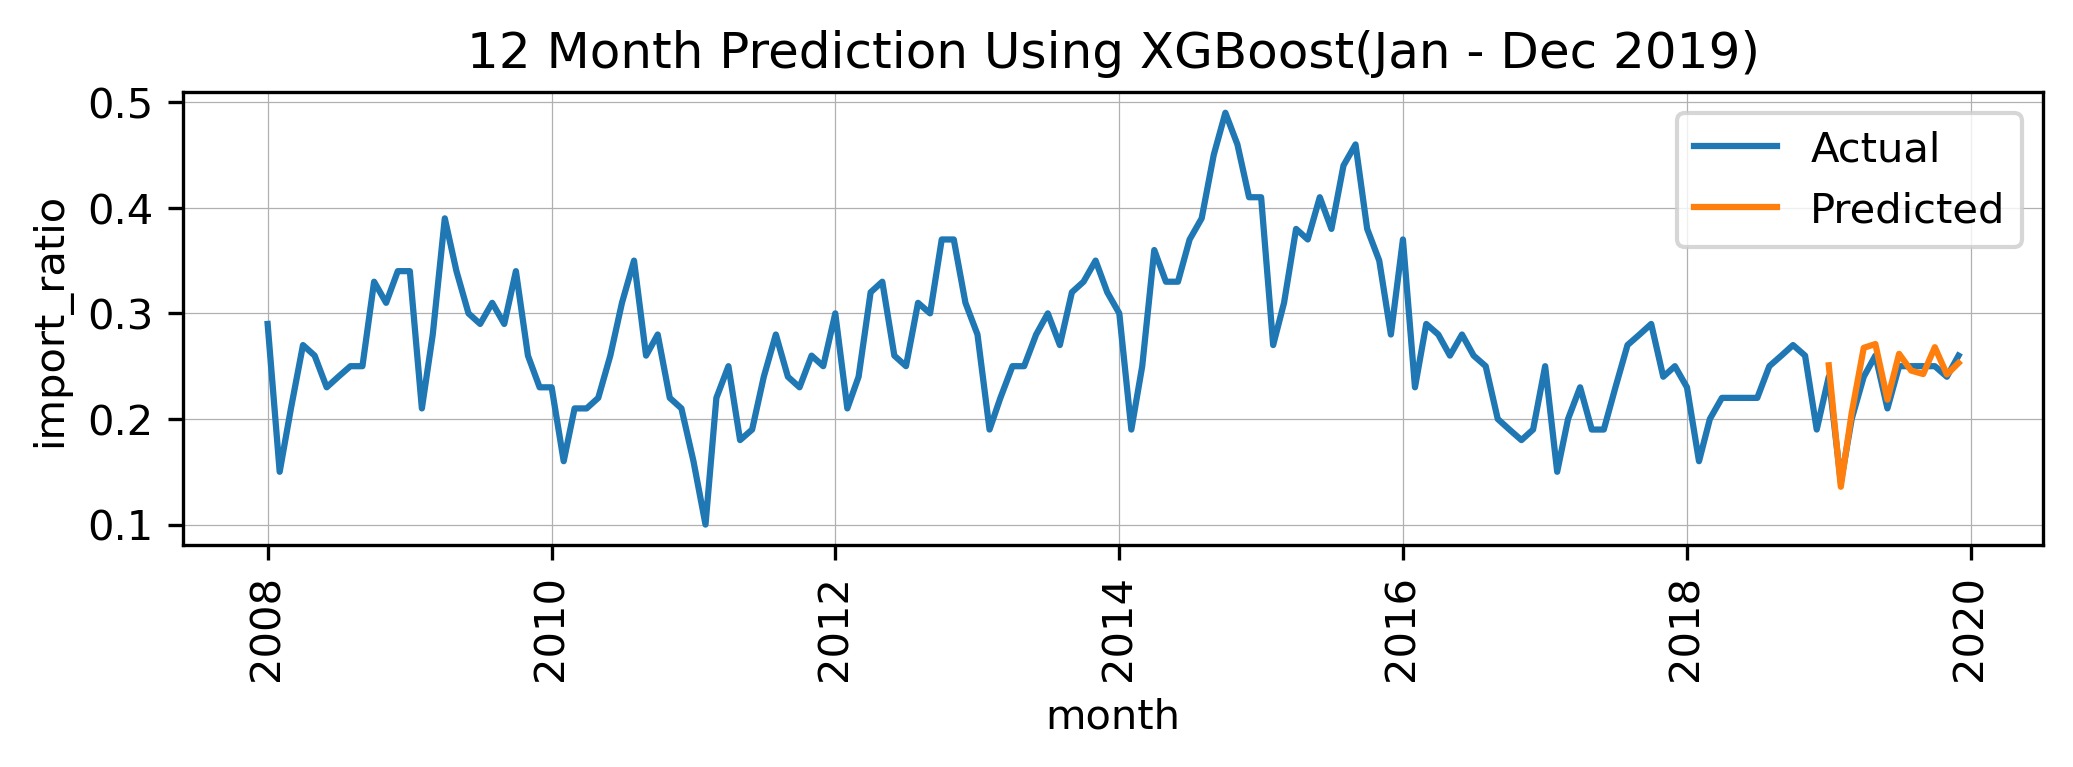

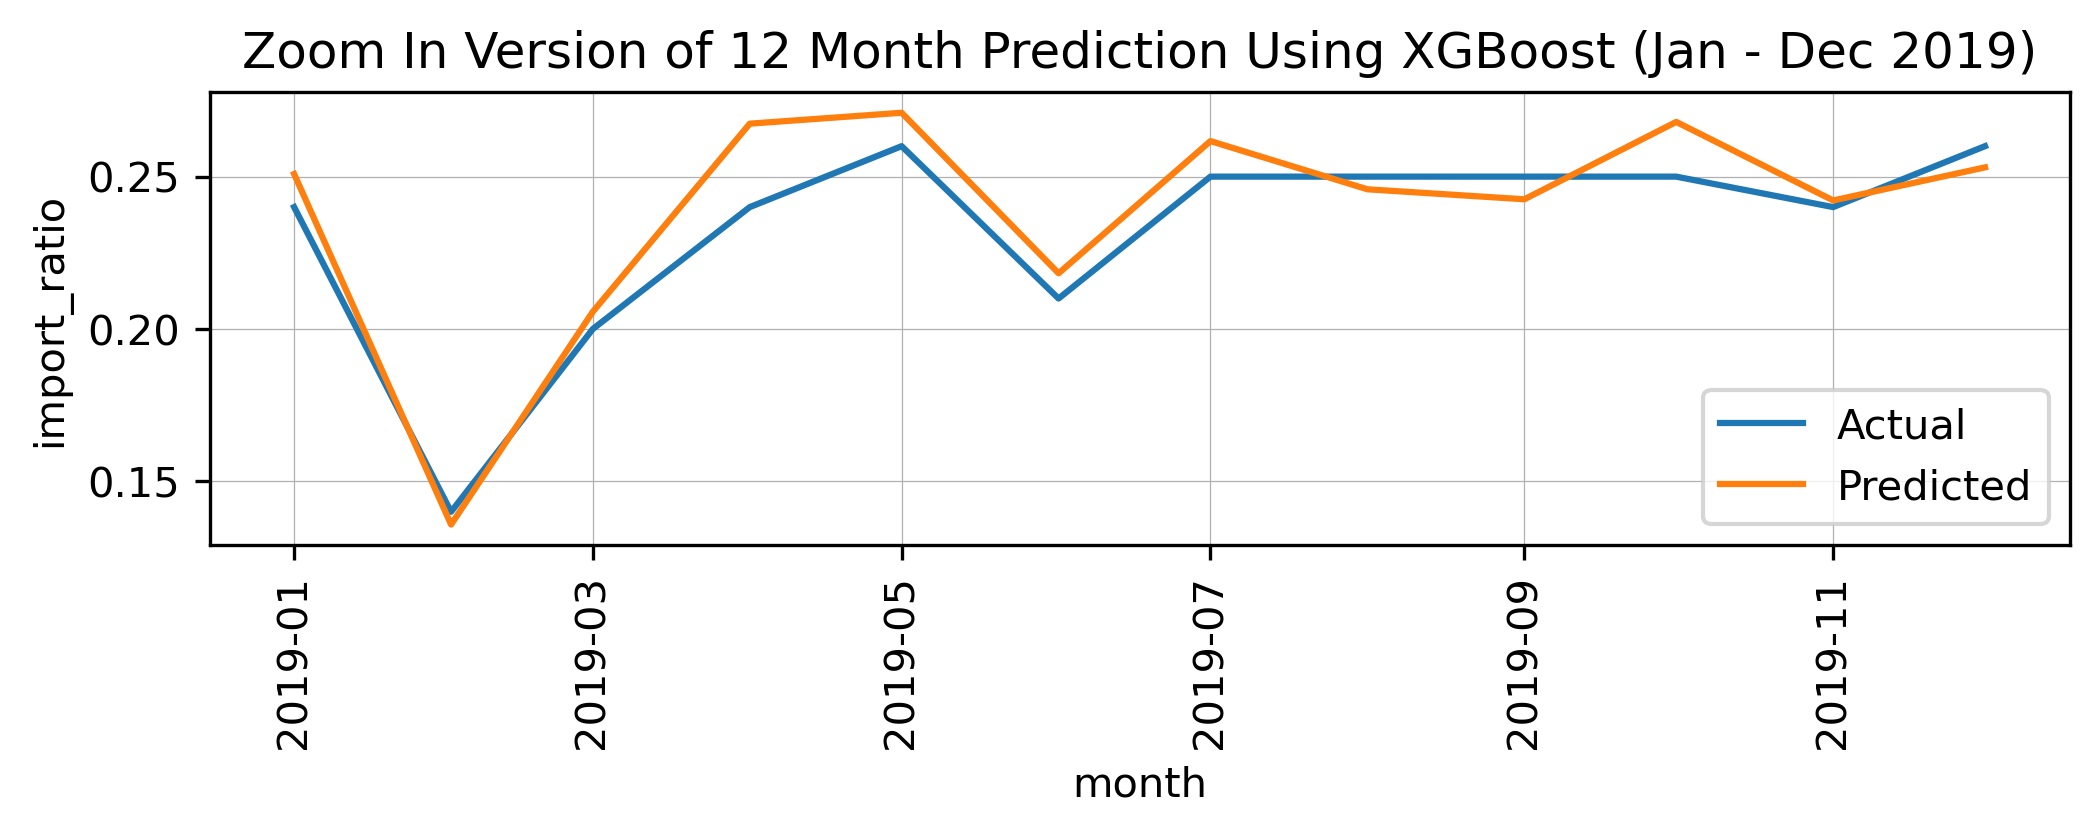

In [84]:
# HAS OUTLIER - all feature
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=combined_data1, x='month', y='import_ratio')
sns.lineplot(data=test_df1, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost(Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_df1, x='month', y='import_ratio')
sns.lineplot(data=test_df1, x='month', y='predictions').set_title("Zoom In Version of 12 Month Prediction Using XGBoost (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)


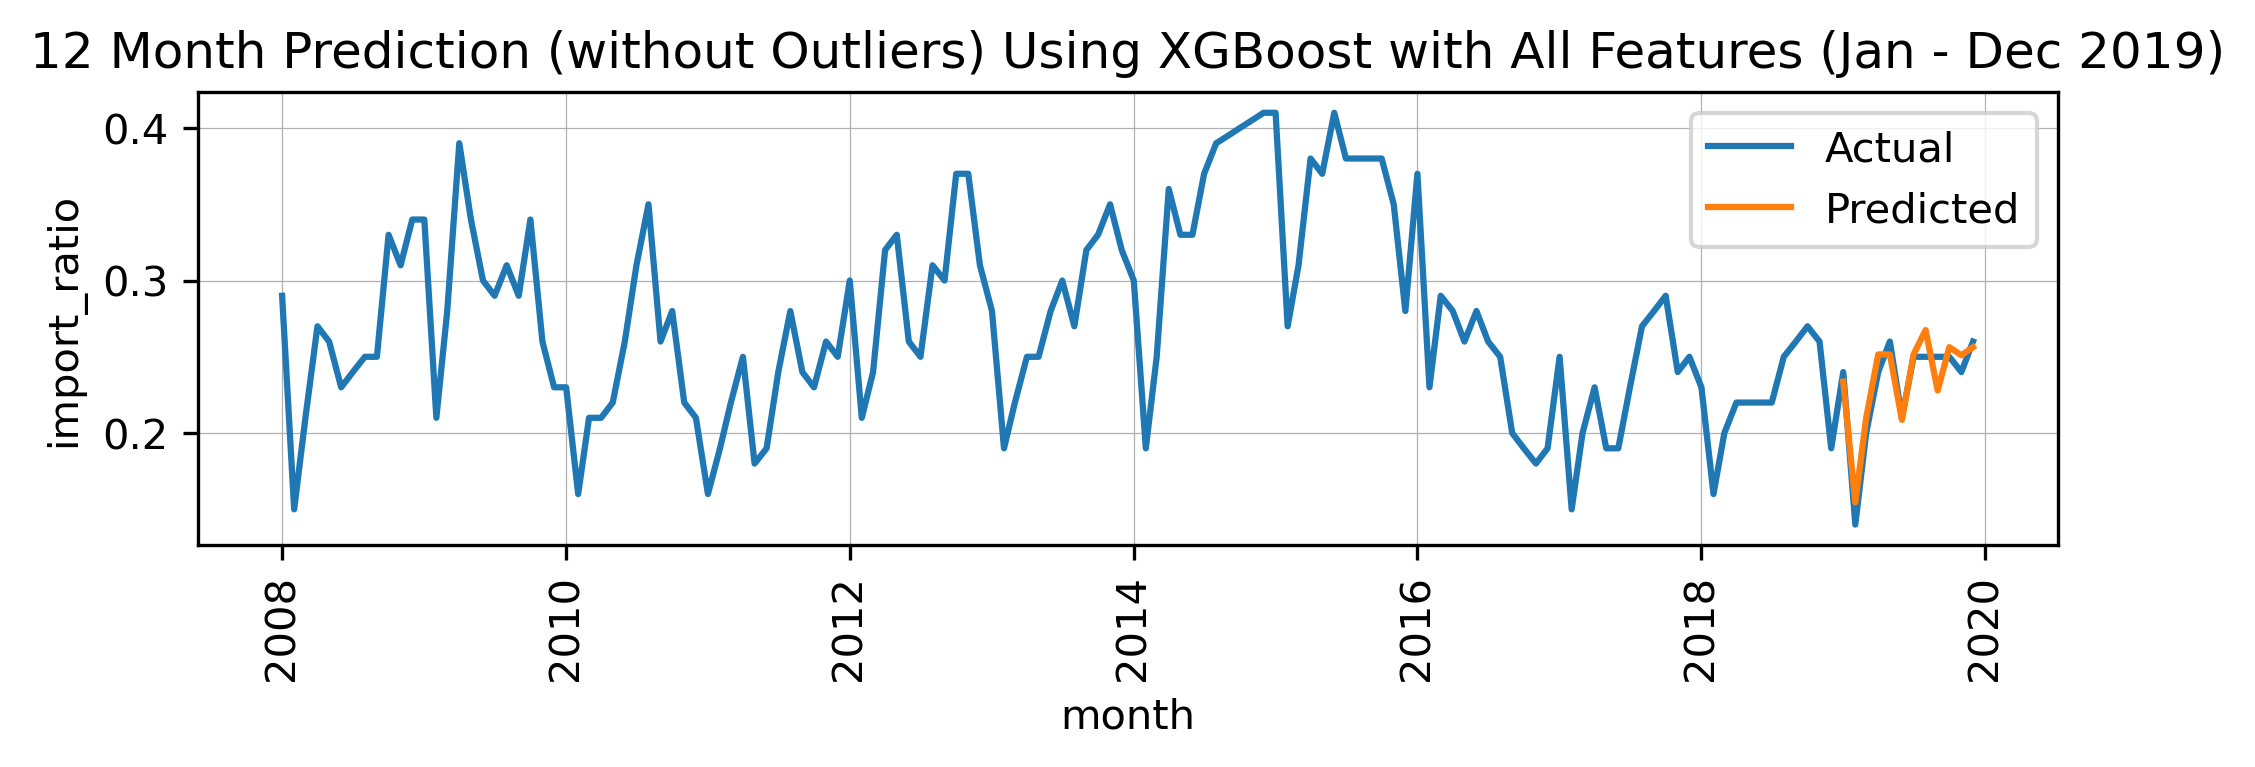

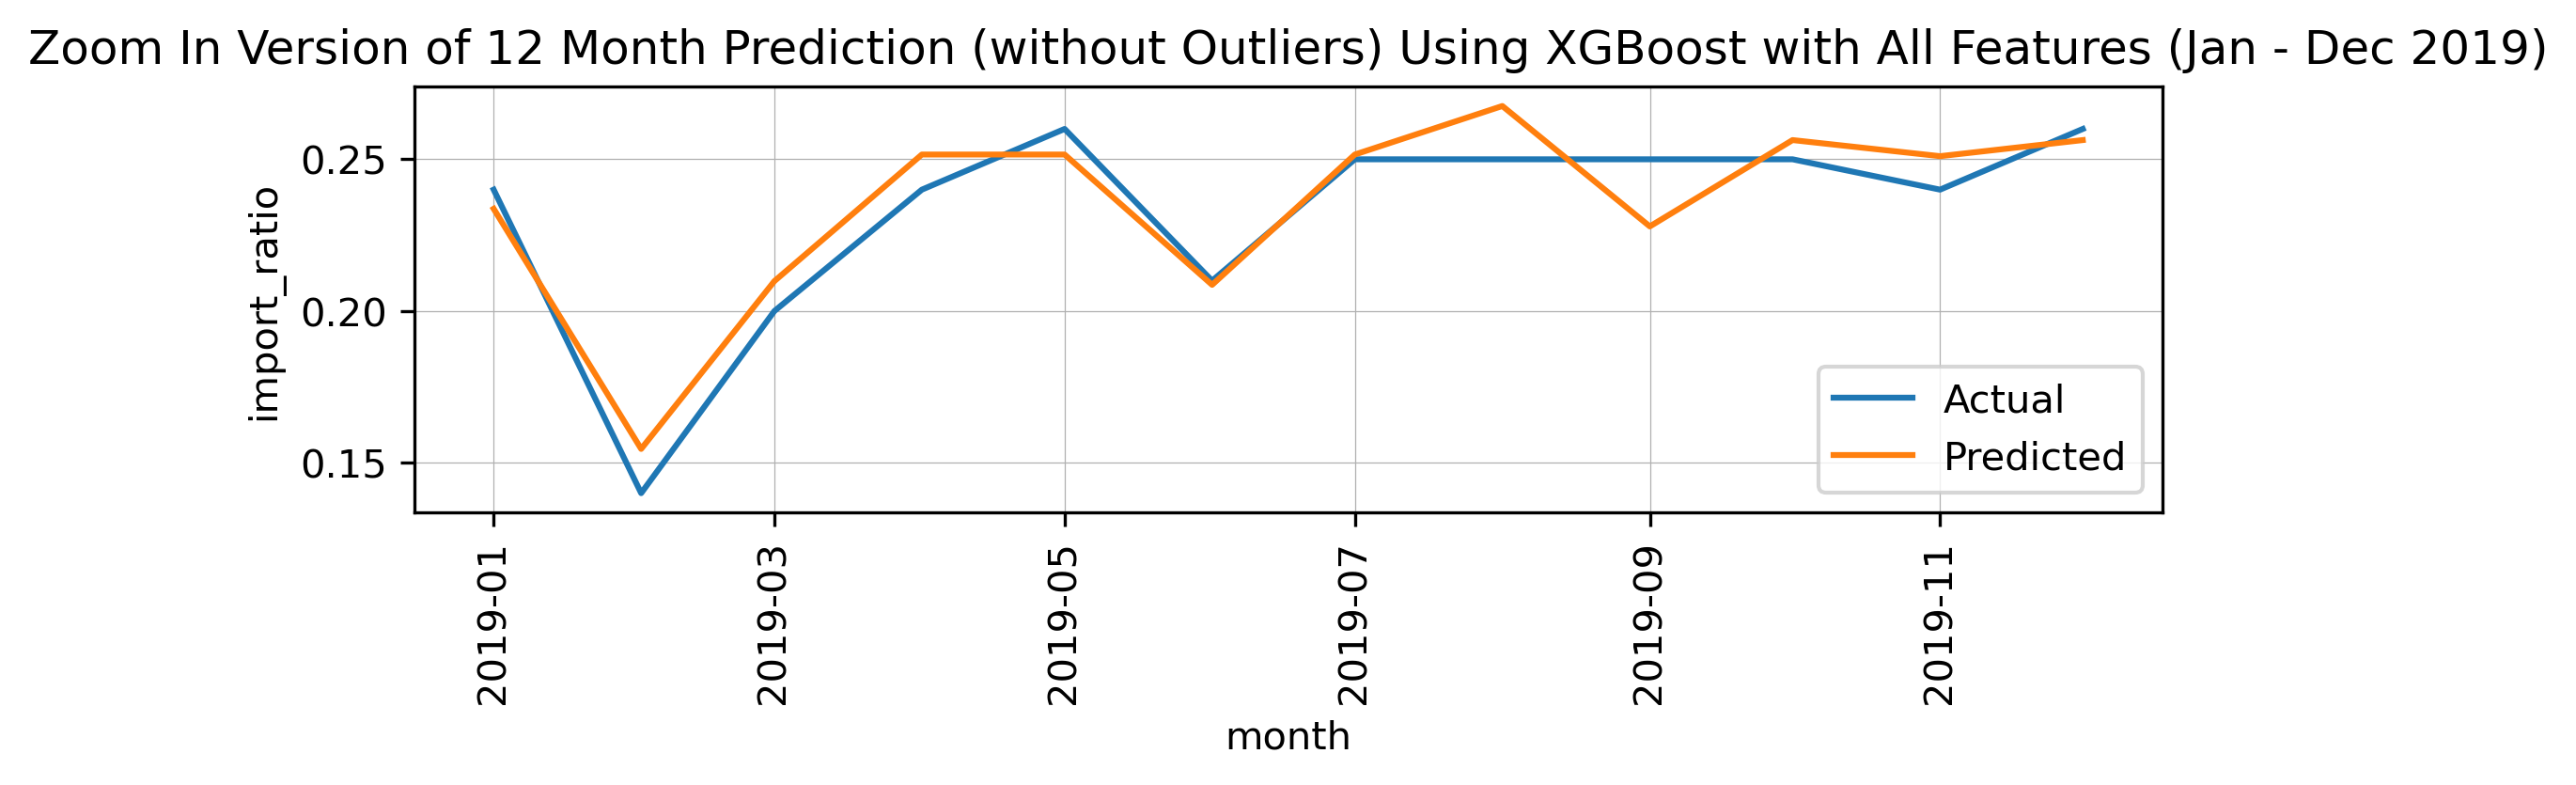

In [85]:
# _no_outlier simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=month_df, x='month', y='import_ratio')
sns.lineplot(data=test_no_outlier1, x='month', y='predictions').set_title("12 Month Prediction (without Outliers) Using XGBoost with All Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_no_outlier1, x='month', y='import_ratio')
sns.lineplot(data=test_no_outlier1, x='month', y='predictions').set_title("Zoom In Version of 12 Month Prediction (without Outliers) Using XGBoost with All Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

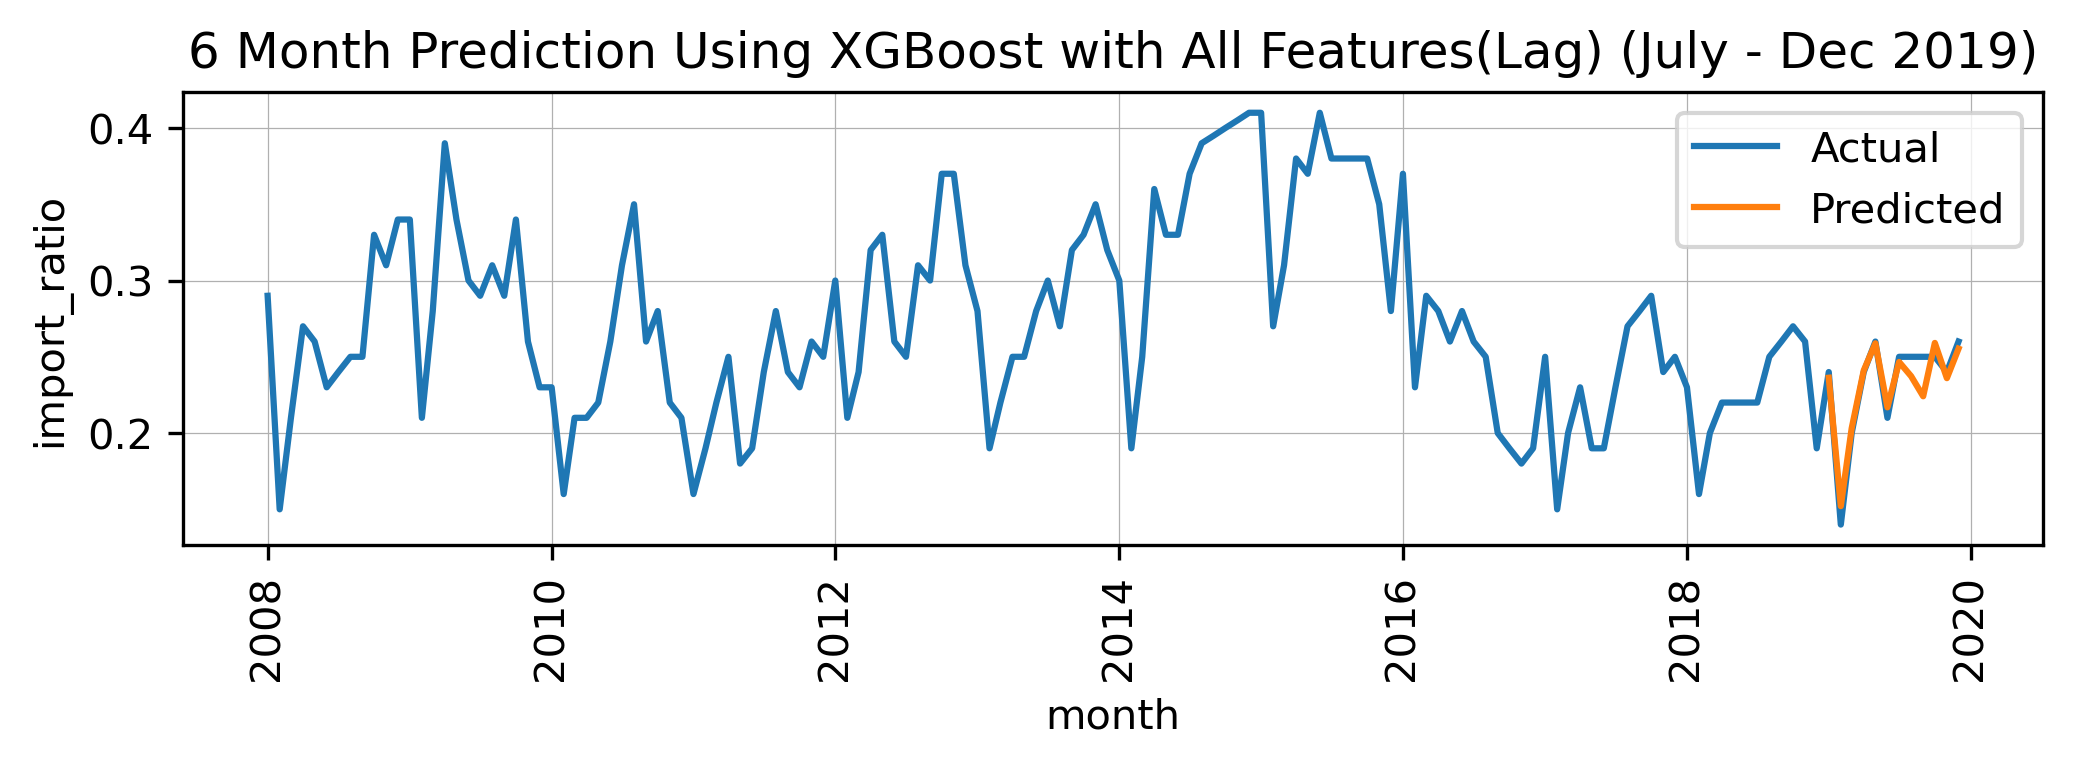

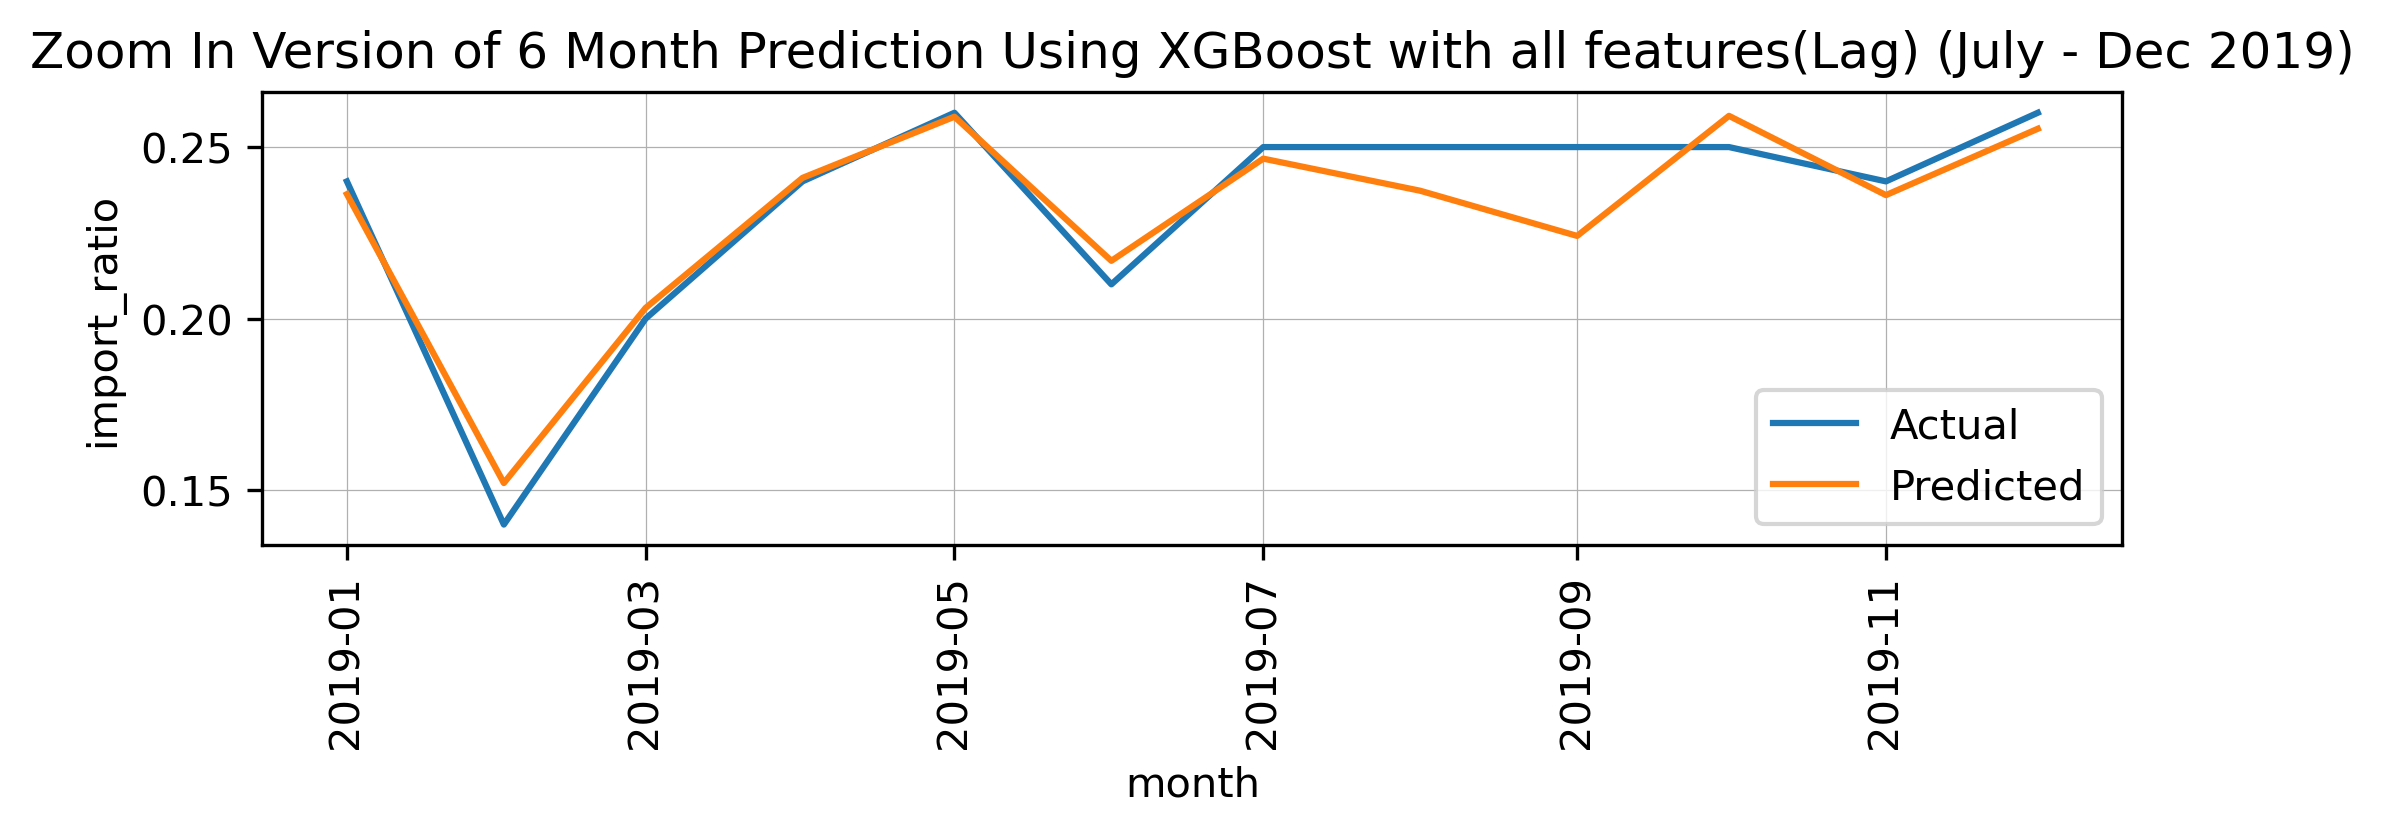

In [86]:
# NO OUTLIER - all feature + LAG
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=month_df_lag, x='month', y='import_ratio')
sns.lineplot(data=test_no_outlier1_lag, x='month', y='predictions').set_title("6 Month Prediction Using XGBoost with All Features(Lag) (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_no_outlier1_lag, x='month', y='import_ratio')
sns.lineplot(data=test_no_outlier1_lag, x='month', y='predictions').set_title("Zoom In Version of 6 Month Prediction Using XGBoost with all features(Lag) (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [54]:
sel_no_df1 = selected_df_no_outlier1
sel_test_no_df1 = selected_test_no_outlier1

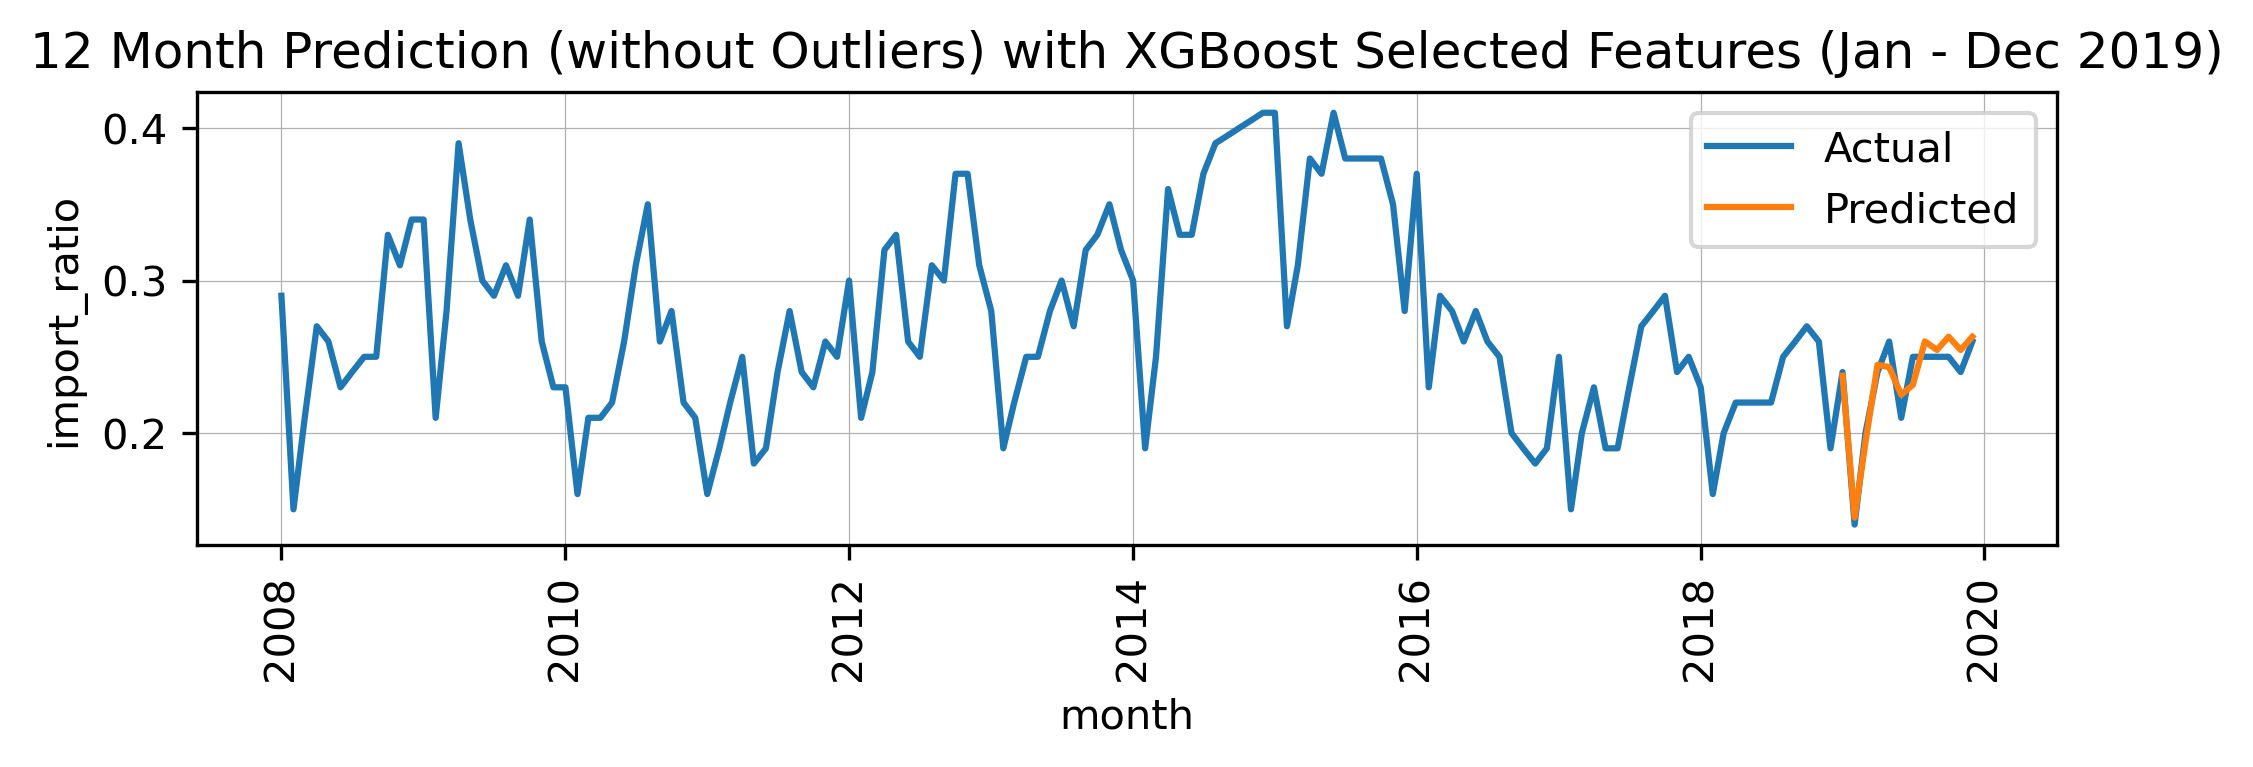

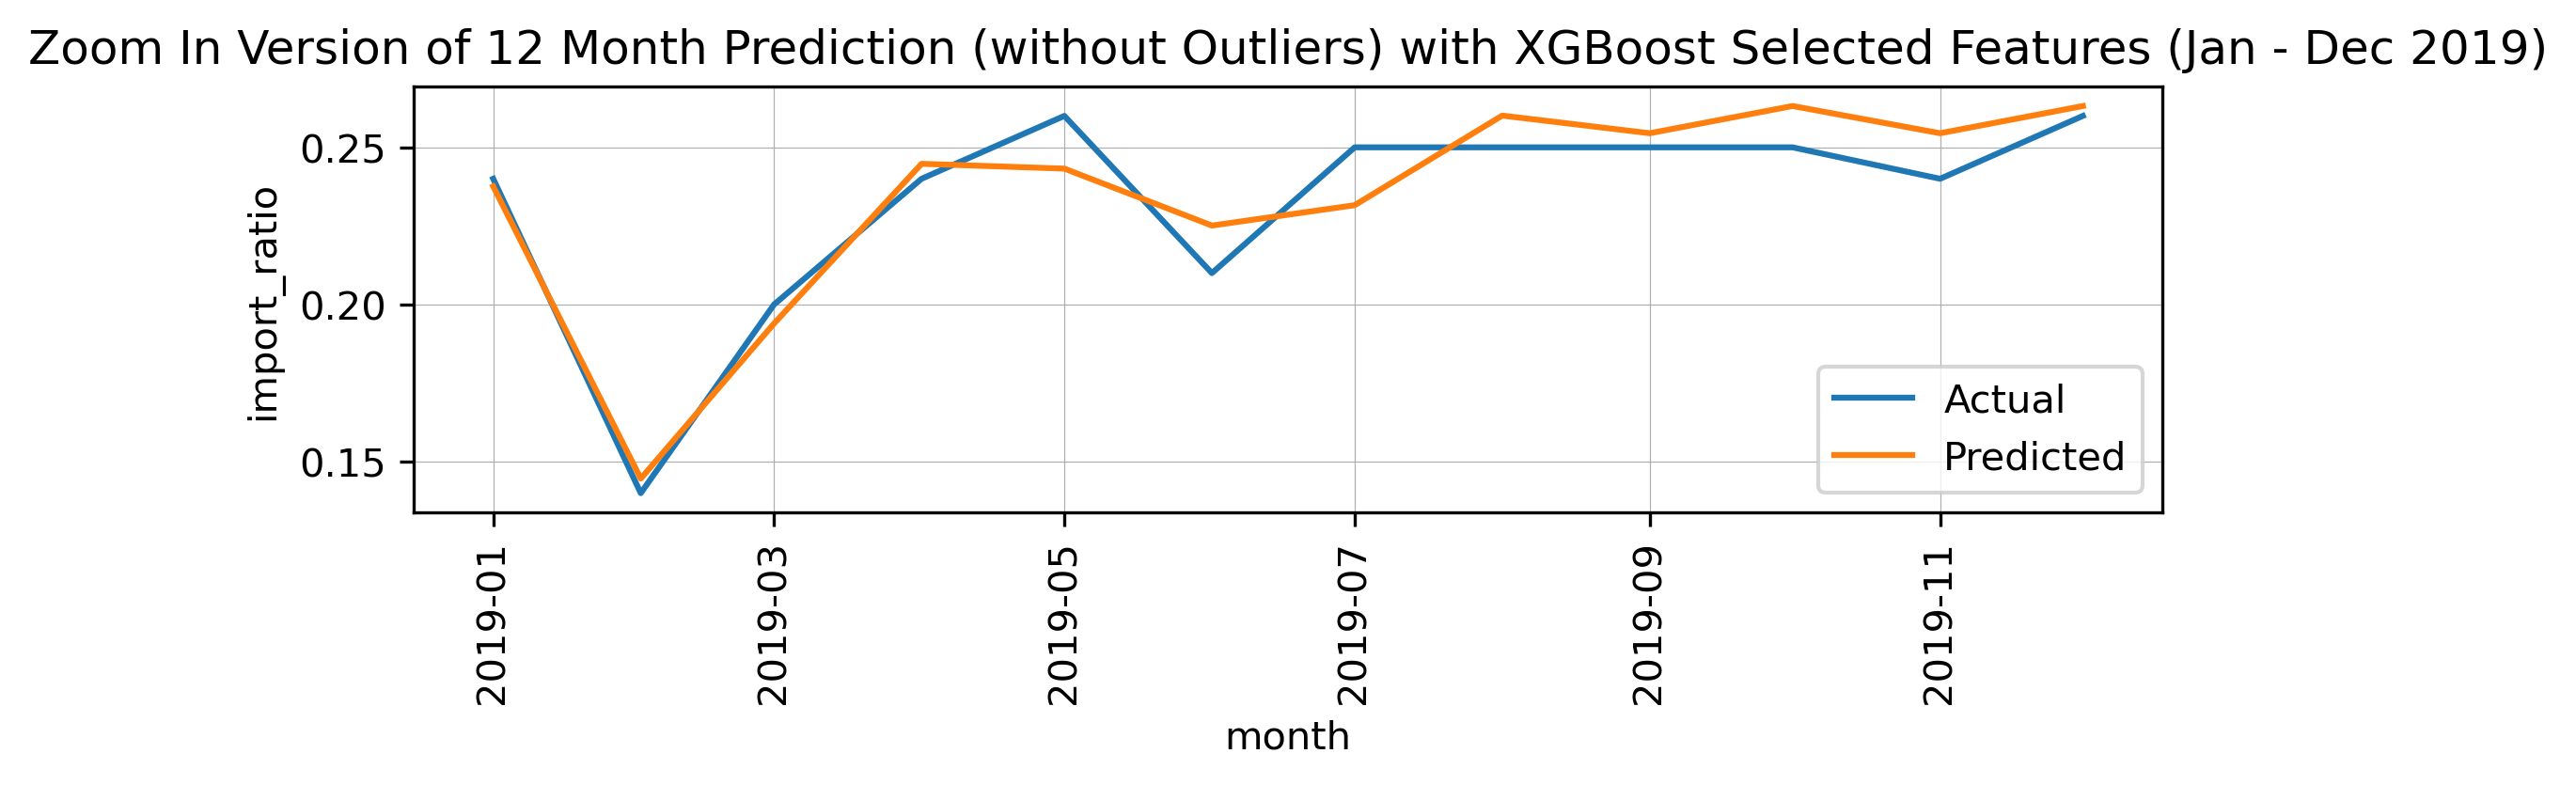

In [87]:
# NO OUTLIER - selected features(11)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=sel_no_df1, x='month', y='import_ratio')
sns.lineplot(data=sel_test_no_df1, x='month', y='predictions').set_title("12 Month Prediction (without Outliers) with XGBoost Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=sel_test_no_df1, x='month', y='import_ratio')
sns.lineplot(data=sel_test_no_df1, x='month', y='predictions').set_title("Zoom In Version of 12 Month Prediction (without Outliers) with XGBoost Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

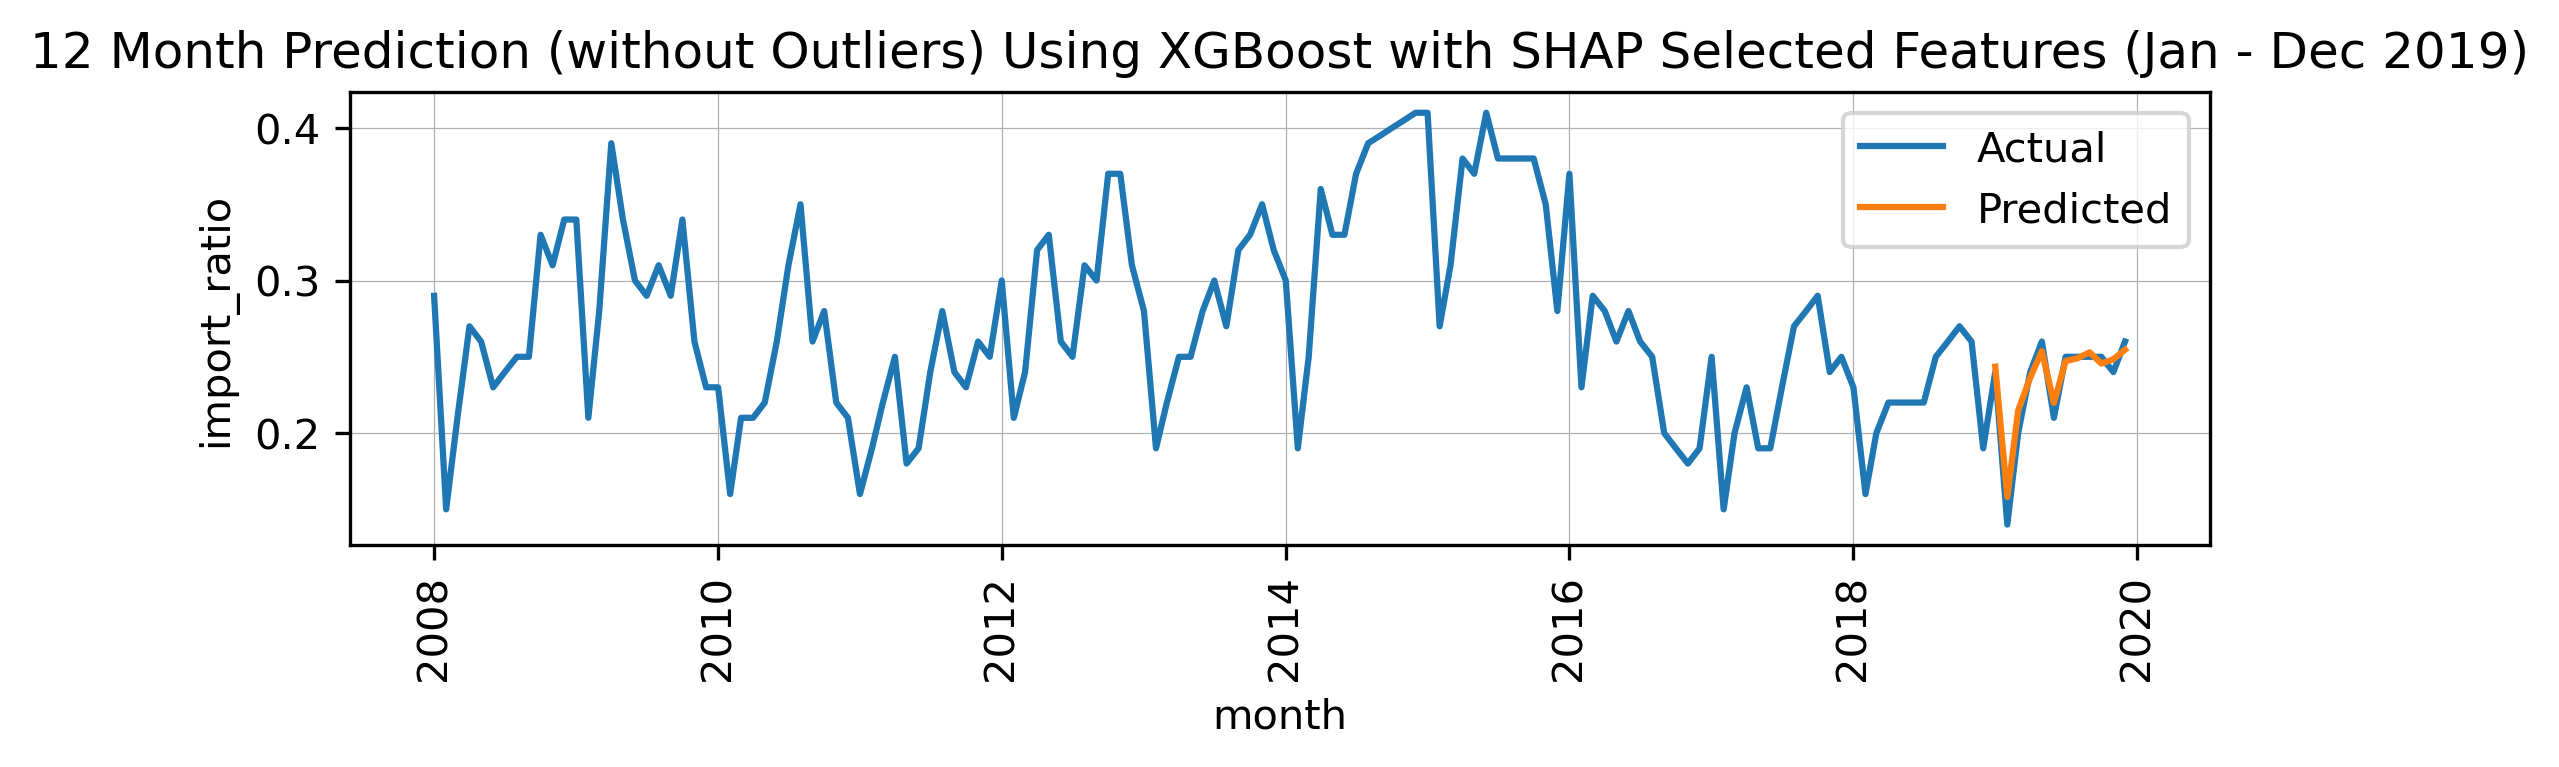

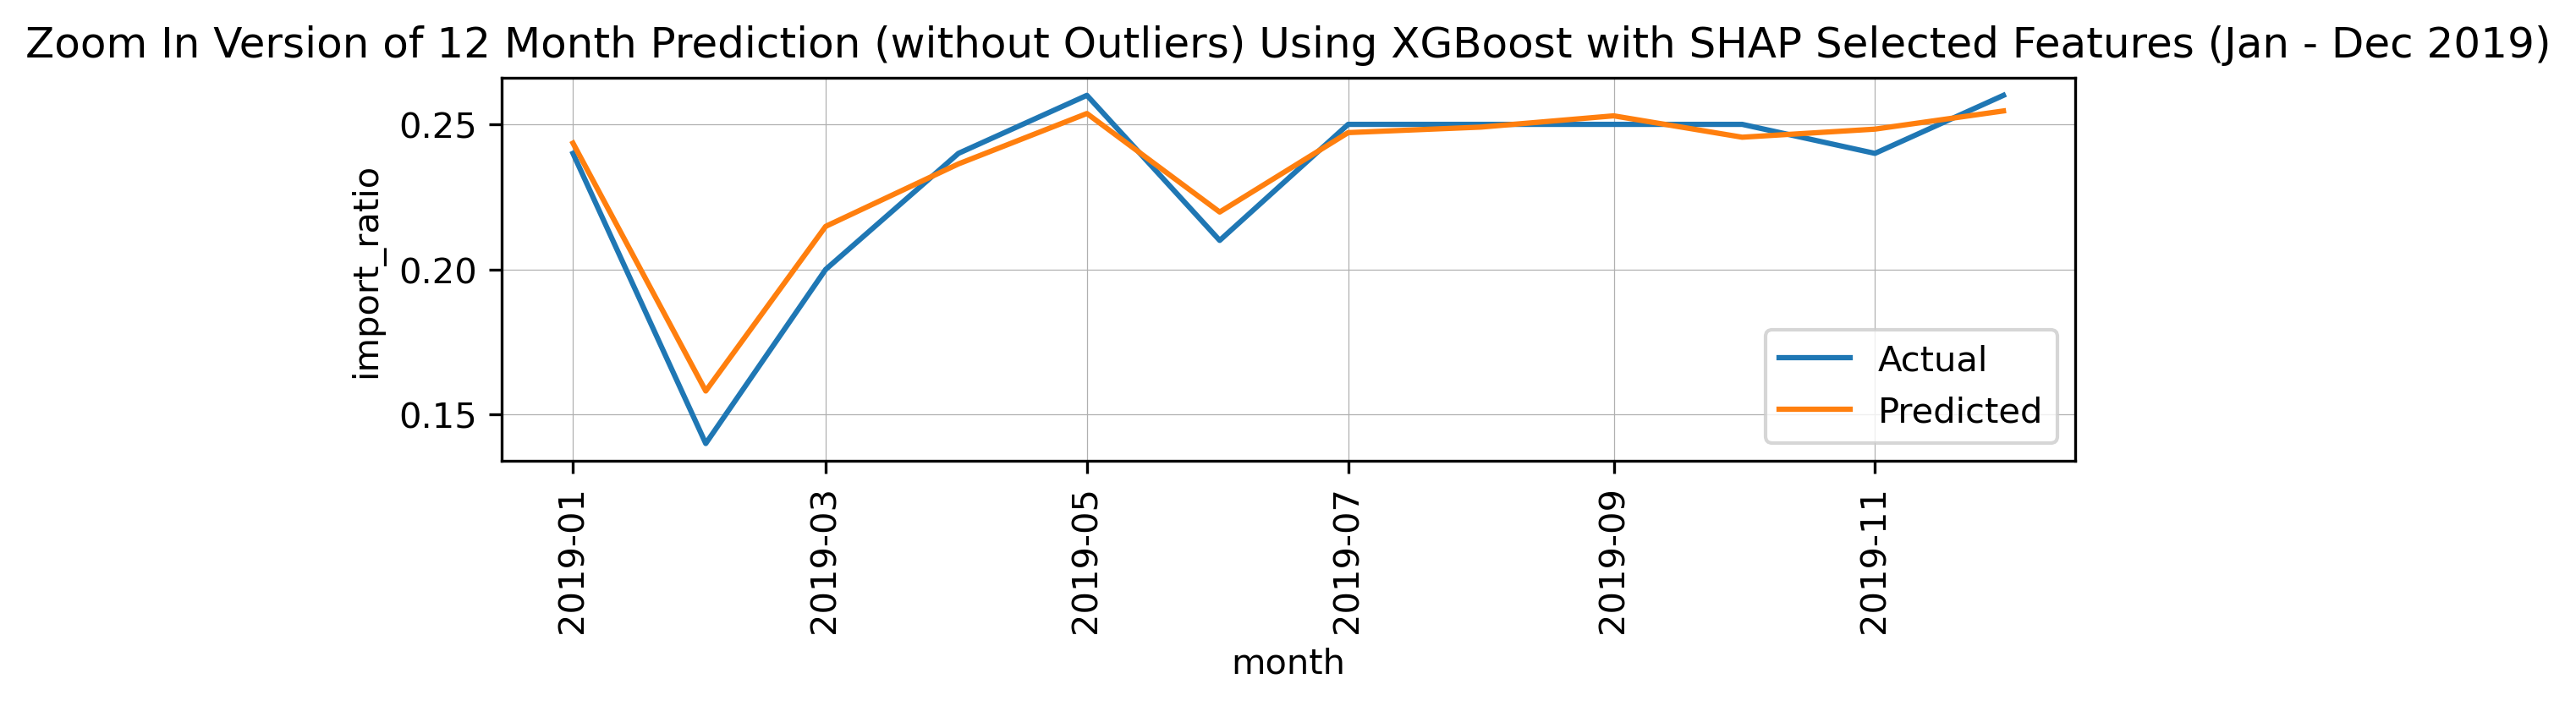

In [88]:
# NO OUTLIER - shap selected features(10)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=selected_df_no_outlier1, x='month', y='import_ratio')
sns.lineplot(data=selected_test_no_outlier1, x='month', y='predictions').set_title("12 Month Prediction (without Outliers) Using XGBoost with SHAP Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=selected_test_no_outlier1, x='month', y='import_ratio')
sns.lineplot(data=selected_test_no_outlier1, x='month', y='predictions').set_title("Zoom In Version of 12 Month Prediction (without Outliers) Using XGBoost with SHAP Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

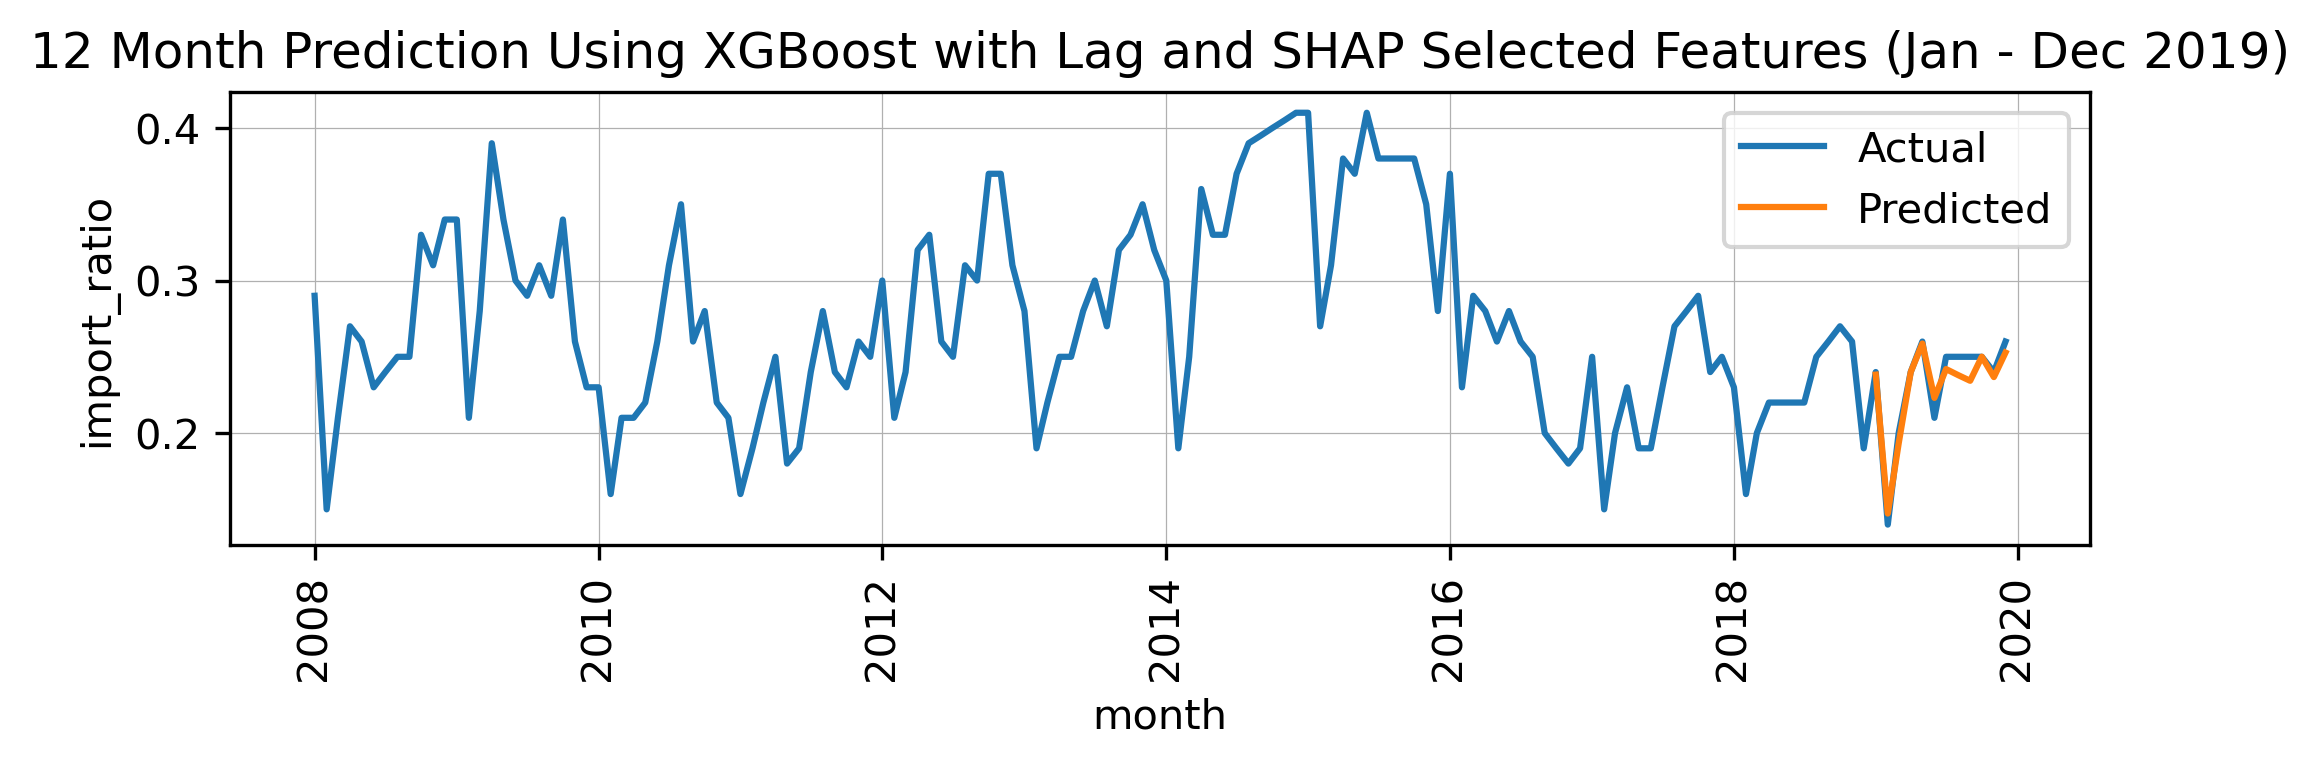

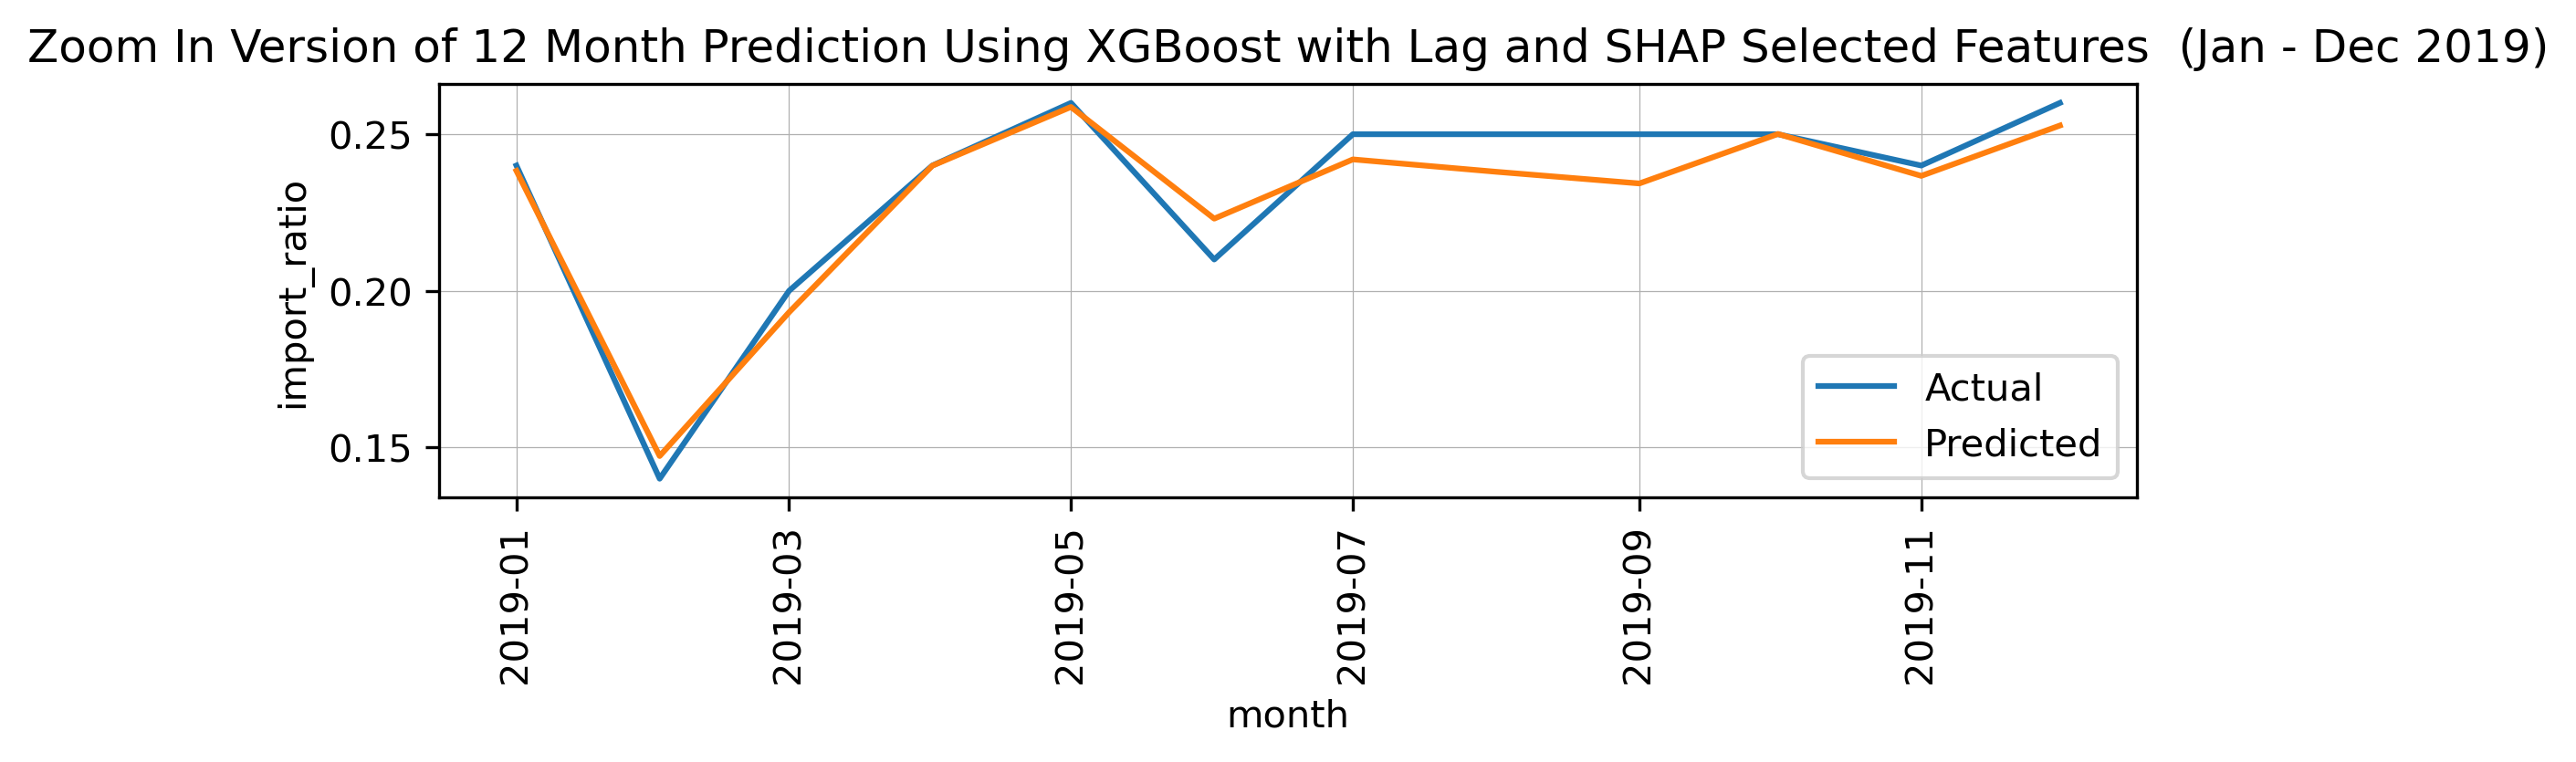

In [89]:
# HAS OUTLIER & Lag feature + shap selected features(6)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost with Lag and SHAP Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_test_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("Zoom In Version of 12 Month Prediction Using XGBoost with Lag and SHAP Selected Features  (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

## Model Output Explaination Using Shap

The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Another way to visualize the same explanation is to use a force plot which can be found under the waterfall plot.

In [36]:
shap_values_no_outlier

.values =
array([[-6.99817017e-03,  9.93637461e-03, -9.45505872e-03,
        -5.08223195e-04,  7.91750848e-03,  3.60640115e-03,
        -7.70813553e-03, -1.46679292e-02,  3.50610819e-03,
        -2.09135637e-02, -3.48788640e-03,  4.13594535e-07],
       [-1.32474275e-02, -4.36954014e-02, -1.19611230e-02,
        -6.89796463e-04,  8.28210358e-03, -1.28723439e-02,
        -1.26038874e-02, -1.22987004e-02, -1.18409200e-02,
        -1.59403849e-02, -8.48109834e-03,  5.51457144e-03],
       [-1.43767269e-02,  1.47847161e-02, -7.73285655e-03,
        -4.34117683e-04,  8.28210358e-03, -1.99507773e-02,
        -1.46090621e-02, -1.44345229e-02, -1.03930263e-02,
        -2.01362483e-02, -3.62199266e-03, -1.31141138e-03],
       [-1.57049242e-02, -9.14243399e-04, -4.77045495e-03,
        -2.44618230e-03,  3.68917431e-03, -2.93034036e-03,
         1.50666805e-02, -1.67238433e-02,  9.86725092e-04,
        -1.47020388e-02, -3.48788640e-03,  4.79707727e-03],
       [-4.19692323e-03,  4.52939188e-03, 

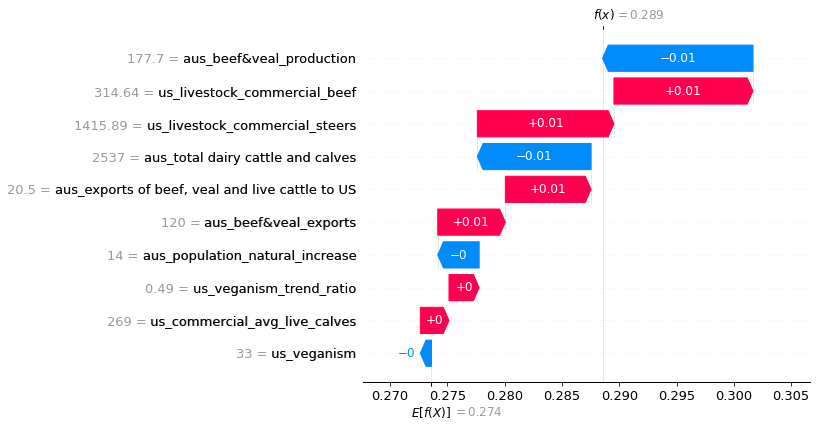

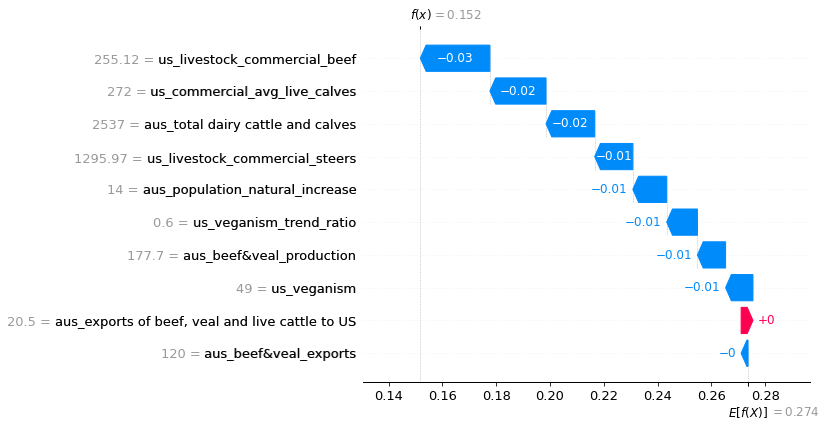

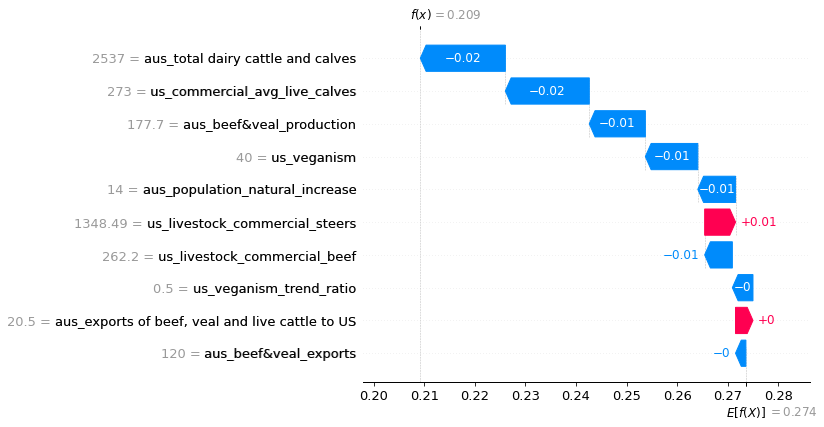

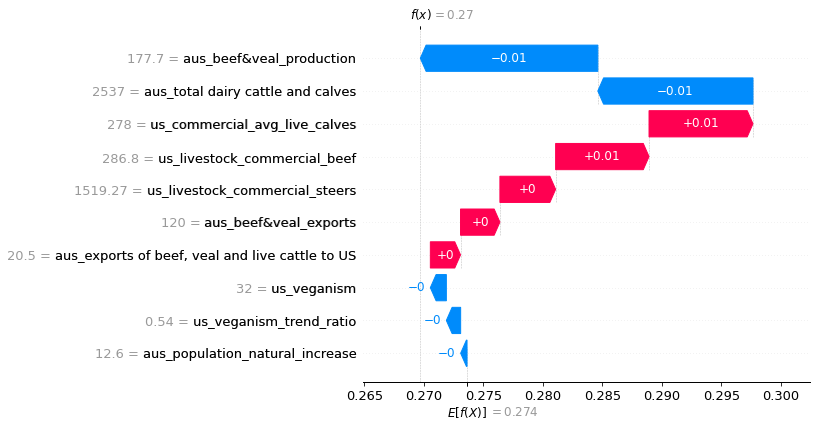

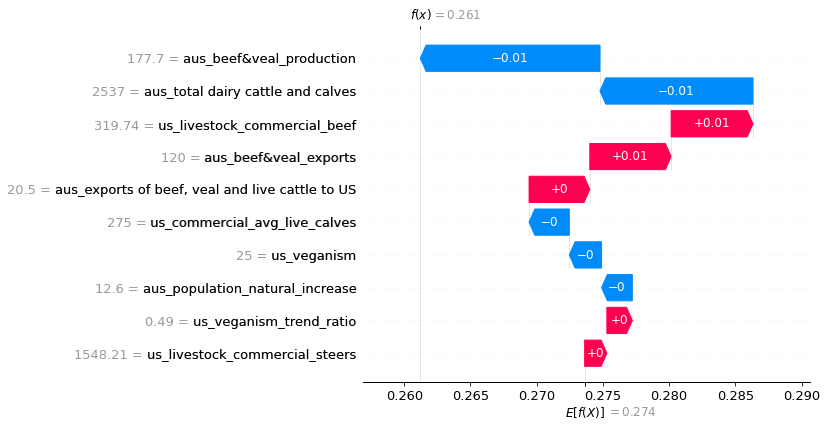

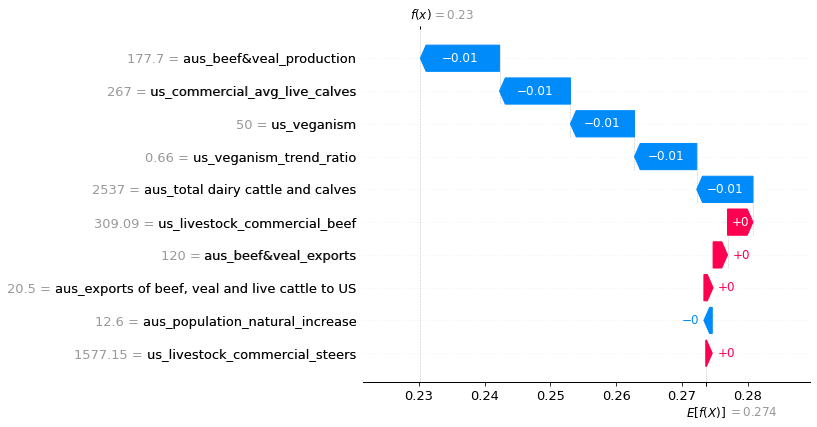

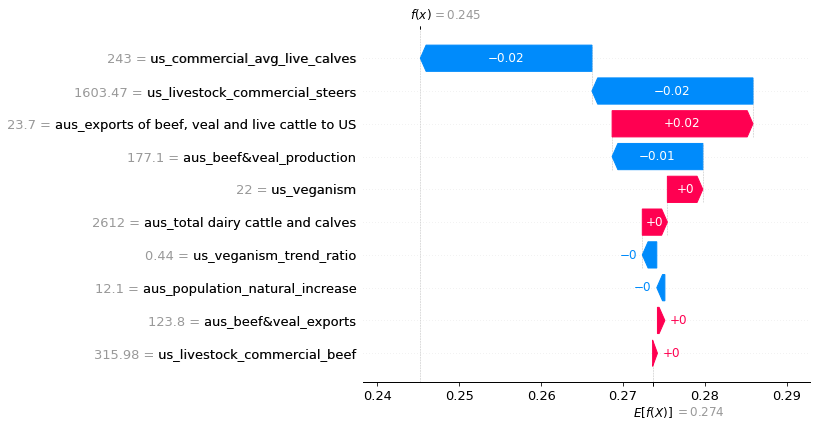

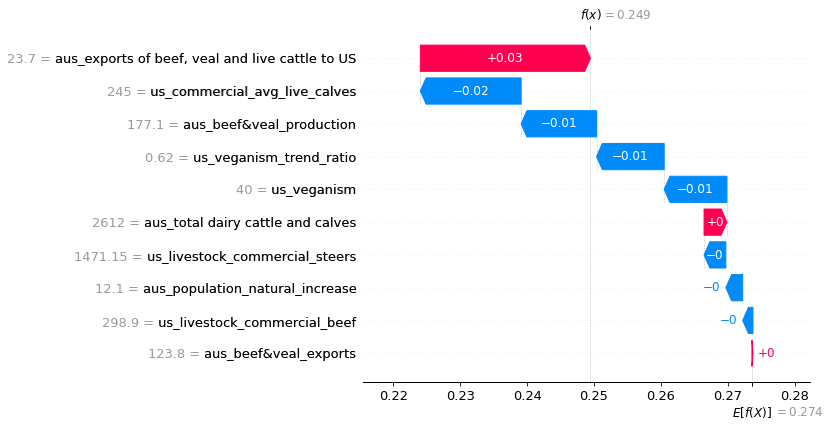

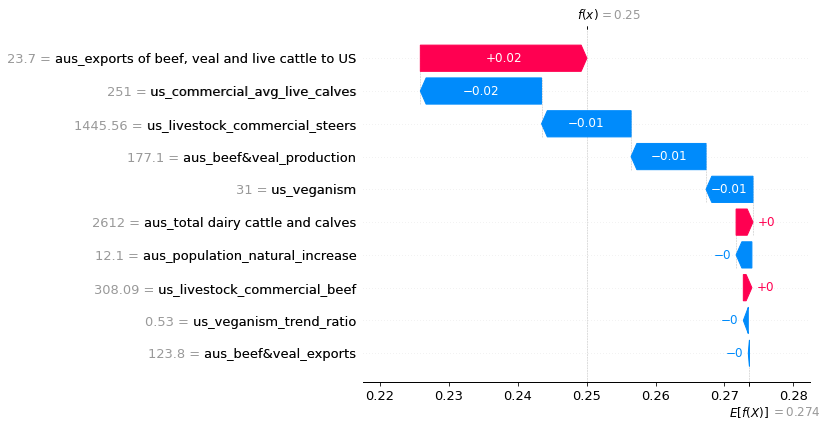

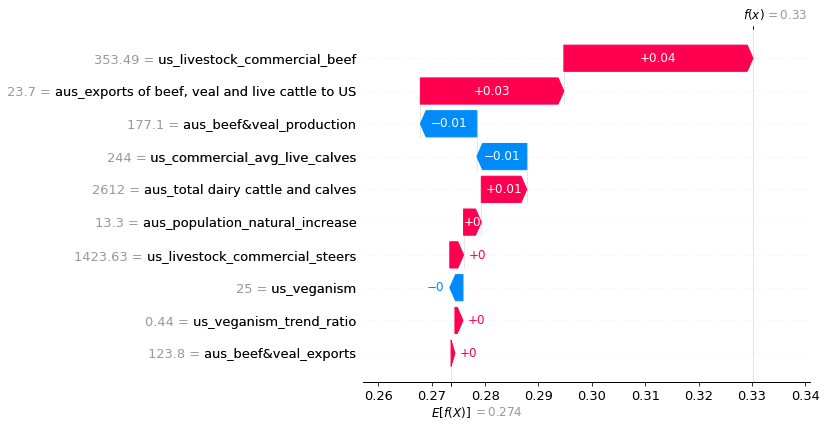

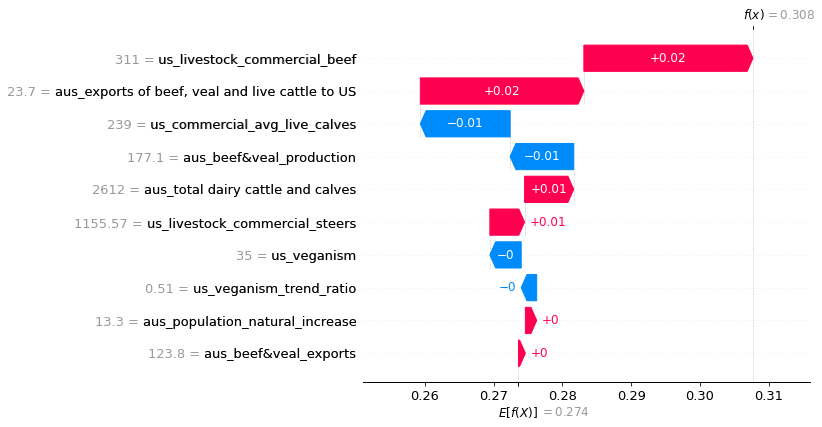

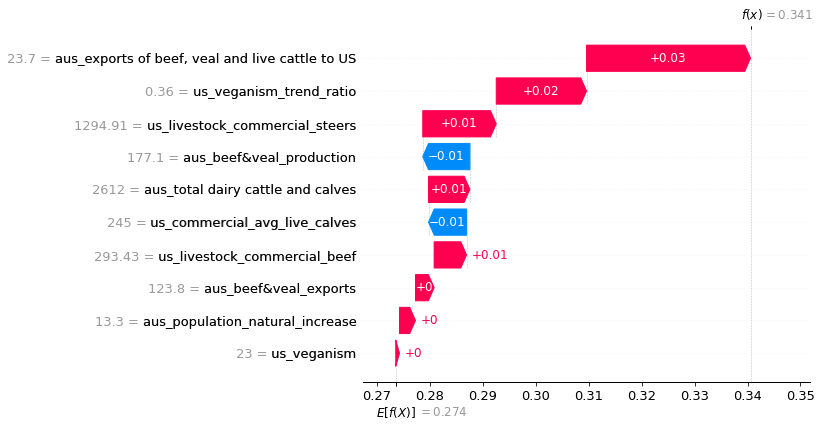

In [39]:
# compute the SHAP values for every prediction in the validation dataset
explainer_no_outlier = shap.TreeExplainer(model_shap_sel_no)
shap_values_no_outlier = explainer_no_outlier(selected_X_train_no_outlier)

#explainer_no_outlier_selected = shap.TreeExplainer(model_all_no)
#shap_values_no_outlier_selected = explainer_no_outlier_selected(X_test_no_outlier)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_no_outlier[0])
shap.plots.waterfall(shap_values_no_outlier[1])
shap.plots.waterfall(shap_values_no_outlier[2])
shap.plots.waterfall(shap_values_no_outlier[3])
shap.plots.waterfall(shap_values_no_outlier[4])
shap.plots.waterfall(shap_values_no_outlier[5])
shap.plots.waterfall(shap_values_no_outlier[6])
shap.plots.waterfall(shap_values_no_outlier[7])
shap.plots.waterfall(shap_values_no_outlier[8])
shap.plots.waterfall(shap_values_no_outlier[9])
shap.plots.waterfall(shap_values_no_outlier[10])
shap.plots.waterfall(shap_values_no_outlier[11])

In [ ]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_no_outlier[2])

In [60]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_no_outlier[3])

In [61]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_no_outlier[4])

SHAP values sum to the difference between the expected output of the model and the current output for the current player. Note that for the Tree SHAP implmementation the margin output of the model is explained, not the transformed output (such as a probability for logistic regression). This means that the units of the SHAP values for this model are log odds ratios. Large positive values mean the import ratio is more likely to increase, while large negative values mean the import ratio is more likely to decrease.

## Summarize the impact of all features over the entire dataset

A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature. In the summary plot below we plot all the SHAP values for a single feature on a row, where the x-axis is the SHAP value. By doing this for all features, we see which features drive the model's prediction a lot (such as us_total_red meat), and which only effect the prediction a little. Note that when points don't fit together on the line they pile up vertically to show density. Each dot is also colored by the value of that feature from high to low.

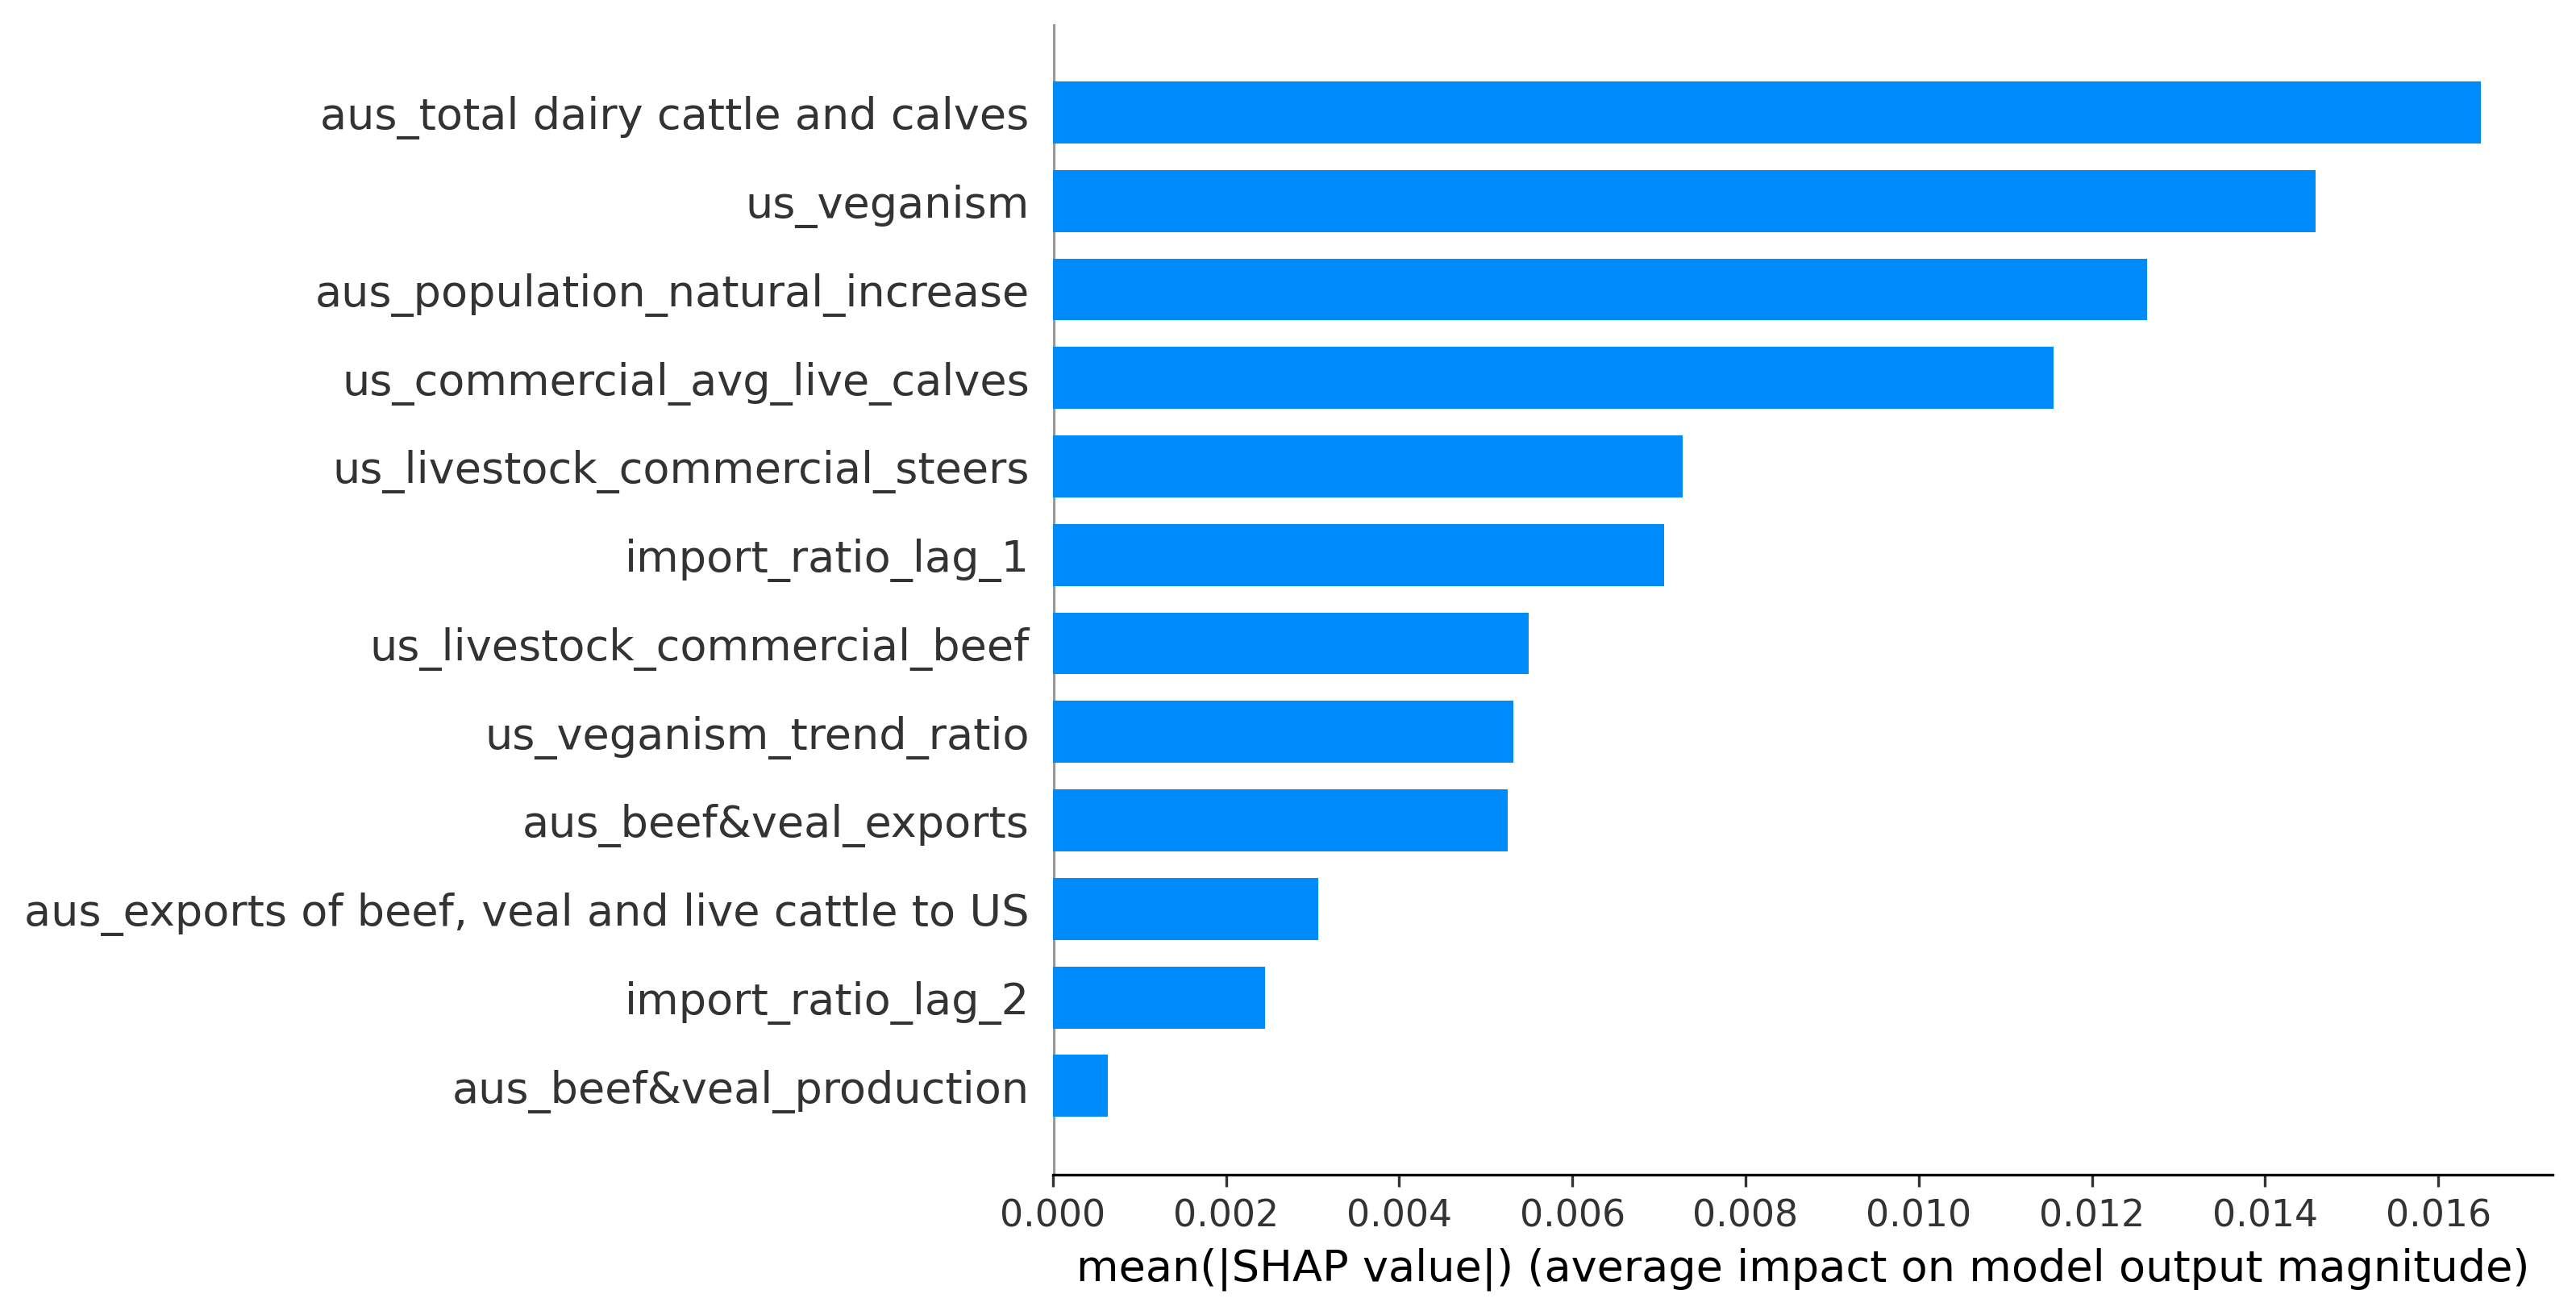

In [100]:
shap.summary_plot(shap_values_no_outlier, best_X_test_lag,plot_type="bar", show=False)
plt.savefig("all_feature_12M_shap_summary_plot.pdf", format='pdf', dpi=1000, bbox_inches='tight')

In [27]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

out1 = global_shap_importance(model_all_no, X_test_no_outlier)
out1.to_csv("old_12m_shap_rank.csv")

